In [1]:
#!conda install seaborn
import pandas as pd
pd.options.mode.chained_assignment=None
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import os
import scipy as sci
import yfinance as yf
from datetime import datetime, timedelta
import plotly.graph_objects as go
import pandas_ta as ta
import plotly.express as px
from scipy.signal import find_peaks
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings(action='ignore',category=SettingWithCopyWarning)
#from jupyterthemes import jtplot
#jtplot.style()


In [2]:
import gc
gc.collect()

0

In [3]:

SP500 = yf.Ticker('MES=F')
spdf_all1 =SP500.history(period= '730d', interval = '60m')
spdf_all1.drop(columns = ['Dividends', 'Stock Splits'], inplace=True, errors = 'ignore')
spdf_all1.index = spdf_all1.index.tz_localize(None)
directory = "/home/armonius/Documents/TradingLogs/CreatedCsvsfromdata/"
filename = 'backupoffullspdfrecent.csv'
path_way= os.path.join(directory, filename)
spdf_all1.to_csv(path_way)
dtypes ={'Open': 'float64', 'High':'float64','Low':'float64','Close':'float64',
         'Volume':'int64' }


In [61]:
spdf_all = pd.read_csv(r"/home/armonius/Documents/TradingLogs/CreatedCsvsfromdata/backupoffullspdf.csv")
spdf_all['Datetime'] =pd.to_datetime(spdf_all['Datetime'])
spdf_all.set_index(keys='Datetime',inplace=True)
# spdf_all_combined=pd.concat(axis=0,objs=[spdf_all,spdf_all1])
# spdf_all_combined.drop_duplicates(inplace=True)
# spdf_all = spdf_all_combined
# spdf_all.index = spdf_all.index.tz_localize(None)
# spdf_all.sort_index(inplace=True)

In [62]:
#start_date= spdf_all.index[0].date()
#end_date = start_date + timedelta(days=1)
start_date ='2021-11-07  00:00:00'
end_date = '2021-11-08 00:00:00'
spdf = spdf_all[start_date:end_date]
atr_val = ta.atr(high = spdf.High, low = spdf.Low, close = spdf.Close,length=2)
spdf.loc[:, 'atr' ] = atr_val
def process_df(spdf_slice):
    try:
        #Calculate the atr for every 6 candles
        atr_tru = ta.atr(high = spdf_slice.High, low = spdf_slice.Low, close = spdf_slice.Close,length=8,mamode='vidya7')
        spdf_slice.loc[:, 'atr_val'] = atr_tru
        #Calculating the ADX indicator a gauge the strength of the trend every 6 candles
        #Calculating the difference in closing prices every 6 candles
        adx_df= ta.adx(high=spdf_slice['High'],low=spdf_slice['Low'],close=spdf_slice['Close'],length=8,scalar=100,mamode='vidya7',drift=2)
        #Calculating the difference in closing prices every 6 candles
        spdf_slice['Price Difference'] = spdf_slice['Close'].shift(8) - spdf_slice['Close']
        #Fill NaN values with 0.3 and resetting indexes for further processing
        adx_df['ADX_8'] = adx_df['ADX_8'].fillna(value=0.3)
    except TypeError:
        print('Not enough data points to calculate ADX indicator')
        #IF adx_df= None
        ma=f"vidya{len(spdf_slice)-2}"
        adx_df= ta.adx(high=spdf_slice['High'],low=spdf_slice['Low'],close=spdf_slice['Close'],length=len(spdf)-1,scalar=100,mamode=ma,drift=2)
    spdf_slice['atr_val'] = spdf_slice['atr_val'].fillna(value=0.3)
    adx_col=adx_df.columns[0]
    adx_df.reset_index(inplace=True)
    spdf_slice.reset_index(inplace=True)
    lastvalADX=adx_df[adx_col].iloc[-1]
    lastvalATR =spdf_slice['atr_val'].iloc[-1]
#    print(f"Last value of the ADX indicator: {lastvalADX} ")
    lastvalDiff=spdf_slice['Price Difference'].iloc[-1]
#    print(f" Last value of the price difference between candles(6 or so) before if loop: {lastvalDiff}")
    if lastvalDiff== 0.0:
        lastvalDiff= spdf_slice.loc[spdf_slice.index[-1], 'Close'] - spdf_slice.loc[spdf_slice.index[-6], 'Close']
    adx_df.loc[adx_df.index % 8 !=0, adx_col] = 0.3
    spdf_slice.loc[spdf_slice.index % 8 !=0, 'Price Difference'] = 0.3
    spdf_slice.loc[spdf_slice.index % 8 !=0, 'atr_val'] = 0.3
    adx_df.loc[adx_df.index[-1], adx_col]=lastvalADX
    spdf_slice.loc[spdf_slice.index[-1], 'Price Difference']=lastvalDiff
    spdf_slice.loc[spdf_slice.index[-1], 'atr_val'] = lastvalATR
    spdf_slice['Price Difference'].fillna(value=0.3, inplace=True)
    print(lastvalDiff)
    if (adx_df[adx_col] == 0.3).all():
        adx_df_alt= ta.adx(high=spdf_slice['High'],low=spdf_slice['Low'],close=spdf_slice['Close'],length=5,scalar=50,mamode='rma4',drift=2)
        adx_col_alt = adx_df_alt.columns[0]
        altlastvalADX=adx_df_alt[adx_col_alt].iloc[-1]
        adx_df.loc[adx_df.index[-1], adx_col]=altlastvalADX
    if (spdf_slice['Price Difference'] == 0.3).all():
        pricediff =spdf['Close'].shift(5) - spdf['Close']
        alt_val=pricediff.loc[pricediff.last_valid_index()]
        spdf_slice.loc[spdf_slice.index[-1], 'Price Difference'] = alt_val
    if (spdf_slice['atr_val'] == 0.3).all():
        ma=f"vidya{len(spdf_slice)-1}"
        atr_tru = ta.atr(high = spdf_slice.High, low = spdf_slice.Low, close = spdf_slice.Close,length=len(spdf_slice)-1,mamode=ma)
        spdf_slice.loc[spdf_slice.index[-1], 'atr_val'] = atr_tru.iloc[-1]
    adx_df.set_index(keys='Datetime',inplace=True)
    spdf_slice.set_index(keys='Datetime', inplace=True)
    spdf_slice['adx'] = adx_df[adx_col]
    return spdf_slice

spdf = process_df(spdf)
spdf
# mamode_param= f"rma{len(spdf)-2}"
# adxvaldf= ta.adx(high=spdf['High'],low=spdf['Low'],close=spdf['Close'],length=len(spdf)-1,scalar=50,mamode=mamode_param,drift=2)
# adxvaldf.reset_index(inplace=True)
# adx_col = f"ADX_{len(spdf)-1}"
# value = adxvaldf.loc[adxvaldf.index[-1], adx_col]
# value

Not enough data points to calculate ADX indicator
nan


/tmp/ipykernel_3818/967349766.py:25: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,Open,High,Low,Close,Volume,atr,atr_val,Price Difference,adx
Datetime,,,,,,,,,
2021-11-07 18:00:00,4679.00,4689.50,4677.50,4684.50,8320,NaN,0.300000,0.3,NaN
2021-11-07 19:00:00,4684.50,4685.25,4679.25,4681.25,8408,NaN,0.300000,0.3,0.300000
2021-11-07 20:00:00,4681.25,4684.75,4676.50,4678.25,9867,7.500000,0.300000,0.3,0.300000
2021-11-07 21:00:00,4678.50,4681.50,4677.50,4680.25,5114,5.500000,0.300000,0.3,0.300000
2021-11-07 22:00:00,4680.50,4681.25,4679.50,4680.00,2798,3.500000,0.300000,0.3,0.300000
2021-11-07 23:00:00,4680.25,4681.00,4678.75,4679.75,2458,2.854839,0.300000,0.3,0.300000
2021-11-08 00:00:00,4679.50,4684.25,4679.00,4683.75,5144,4.071429,4.678571,-2.5,27.152318


In [63]:
#spdf = process_df(spdf_all, spdf)
#spdf.reset_index(inplace=True)
#index=[idx for idx,val in spdf.iterrows() if val['TrendStrength'] != 0.5]
#spdf.set_index(keys='Datetime', inplace=True)
#idx2_6 = [idx2use.append(idx) for idx in range(len(spdf)) if idx % 6 ==0]
#rel_trend_strength = [val['TrendStrength'] for idx,val in spdf.iterrows() if val['TrendStrength'] != 0.5]
#trend_pair = dict(zip(index,rel_trend_strength))
#print(trend_pair)
def get_trendstrength(pair):
    spdf.reset_index(inplace=True)
    index=[idx for idx,val in spdf.iterrows() if val['adx'] != 0.3]
    spdf.set_index(keys='Datetime', inplace=True)
    rel_trend_strength = [val['adx'] for idx,val in spdf.iterrows() if val['adx'] != 0.3]
    trend_pair = dict(zip(index,rel_trend_strength))
    max_val = max(pair['Maxindex'], pair['Minindex'])
    for key, value in trend_pair.items():
#        print(f"key: {key}")
        if key > max_val:
            print(f"key: {key}, value: {value}, max index value: {max_val}")
            return value
    return None
def get_pricediff4_6candles(pair):
    spdf.reset_index(inplace=True)
    index=[idx for idx,val in spdf.iterrows() if val['Price Difference'] != 0.3]
    spdf.set_index(keys='Datetime', inplace=True)
    rel_price_diff = [val['Price Difference'] for idx,val in spdf.iterrows() if val['Price Difference'] != 0.3]
    trend_pair = dict(zip(index,rel_price_diff))
    max_val = max(pair['Maxindex'], pair['Minindex'])
    for key, value in trend_pair.items():
#        print(f"key: {key}")
        if key > max_val:
            print(f"key: {key}, value: {value}, max index value: {max_val}")
            return value
    return None
def get_pricediff4_day(pair):
    spdf.reset_index(inplace=True)
    value= spdf.loc[spdf.index[-1], 'Close'] - spdf.loc[spdf.index[0], 'Close']
    spdf.set_index(keys='Datetime', inplace=True)
    return value
def get_trendstren4day(pair):
#    spdf.reset_index(inplace=True)
    mamode_param= f"rma{len(spdf)-2}"
    adxvaldf= ta.adx(high=spdf['High'],low=spdf['Low'],close=spdf['Close'],length=len(spdf)-1,scalar=50,mamode=mamode_param,drift=2)
    adxvaldf.reset_index(inplace=True)
    adx_col = f"ADX_{len(spdf)-1}"
    value = adxvaldf.loc[adxvaldf.index[-1], adx_col]
    return value
def get_atr4day(pair, df):
    df.reset_index(inplace=True)
    mamode_param = f"vidya{len(df)-1}"
    df['atrval'] = ta.atr(high=df['High'],low=df['Low'],close=df['Close'],length=len(df)-1,mamode=mamode_param)
    value = df.loc[df.index[-1], 'atrval']
    df.set_index(keys='Datetime', inplace=True)
    df = df.drop(labels='atrval', axis='columns')
    return value
def get_atr4_6candles(pair):
    spdf.reset_index(inplace=True)
    index=[idx for idx,val in spdf.iterrows() if val['atr_val'] != 0.3]
    spdf.set_index(keys='Datetime', inplace=True)
    rel_price_diff = [val['atr_val'] for idx,val in spdf.iterrows() if val['atr_val'] != 0.3]
    trend_pair = dict(zip(index,rel_price_diff))
    max_val = max(pair['Maxindex'], pair['Minindex'])
    for key, value in trend_pair.items():
#        print(f"key: {key}")
        if key > max_val:
            print(f"key: {key}, value: {value}, max index value: {max_val}")
            return value
def get_pointsamount4day(pair):
    value = (spdf['High'].max()) - (spdf['Low'].min())
    return value
#test_data['TrendStrength'] = test_data.apply(get_trendstrength, axis=1)
#test_data
#test_dict = {"test1": 1}
#info['Trendcheck'] = get_trendstrength(info)
#info
#pairs=[info]
#pairs

In [64]:
trendstren=[]
pairs=[]
start_date ='2021-11-02 00:00:00'
end_date = '2021-11-03 00:00:00'
spdf = spdf_all[start_date:end_date].copy()
atr_val = ta.atr(high = spdf.High, low = spdf.Low, close = spdf.Close,length=2)
spdf.loc[:, 'atr' ] = atr_val
atr_array = spdf['atr'].to_numpy()
close_check = spdf['Close'].to_numpy()
sppeaks_idx, _ = find_peaks(close_check, distance = 1,prominence=atr_array/80)
sptroughs_idx, _ = find_peaks(-1*close_check,distance=1,prominence=atr_array/80)
spdf = process_df(spdf)
columns = ['Datetime4trough', 'Datetime4peak', 'TimeDifference', 
           'Maxindex', 'Minindex', 'Maxpricepoint', 'Minpricepoint', 'Difference','ADX(TrendStrength)', 'Price Difference', 'Day ATR', 'Shorter ATR']

for idx, (peak, trough) in enumerate(zip(sppeaks_idx, sptroughs_idx)):
            if idx + 1 <= len(sppeaks_idx):
                time_diff = spdf.index[peak] - spdf.index[trough]
#                time_diff = time_diff.total_seconds()/3600
                print(f"Time Difference: {time_diff}, peak: {peak}. trough: {trough}, index value, {idx}, start_date: {start_date}")
                if time_diff > timedelta(days=18, hours=4):
                    if spdf.index[peak] > spdf.index[trough]:
                        print(f"Deleting minimum or trough at index {trough} in {idx}th iteration of loop")
                        sptroughs_idx = np.delete(sptroughs_idx, idx)
                        print(f"Pairing {peak} with {trough}")
                    else:
                        print(f"Deleting maximum or peak at index {peak}, in {idx}th iteration of loop")
                        sppeaks_idx = np.delete(sppeaks_idx, idx)
                        print(f"Pairing {peak} with {trough}")      
                elif spdf['Close'].iloc[trough] > spdf['Close'].iloc[peak]:
                    if spdf.index[trough] < spdf.index[peak]:
                        print(f"Deleting minimum (trough) and maximum (peak) at index {trough} and {peak} in {idx}th iteration of loop due to peak being lower than trough")
                        sptroughs_idx = np.delete(sptroughs_idx, idx)
                        print(f"Pairing {peak} with {trough}")
                    if spdf.index[trough] > spdf.index[peak]:
                        print(f"Deleting maximum (peak) at index {trough} and {peak} in {idx}th iteration of loop due to peak being lower than trough")
                        sppeaks_idx = np.delete(sppeaks_idx, idx)
                        print(f"Pairing {peak} with {trough}")
                else:
                    print('checking')
                    info= {'Datetime4trough' :spdf.index[trough], 'Datetime4peak': spdf.index[peak], 'TimeDifference' : time_diff.total_seconds()/3600, 'Maxindex' : peak, 'Minindex' : trough, 'Maxpricepoint' : spdf['Close'].iloc[peak],
                       'Minpricepoint' : spdf['Close'].iloc[trough], 'Difference' : spdf['Close'].iloc[peak] - spdf['Close'].iloc[trough]  }
                    info['ADX(TrendStrength)'] = get_trendstrength(info)
                    info['Price Difference'] = get_pricediff4_6candles(info)
                    info['Day ATR'] = get_atr4day(info,spdf)
                    info['Shorter ATR'] = get_atr4_6candles(info)
                    pairs.append((info))
                    print(f"Pairing {peak} with {trough}")
#test_data = pd.DataFrame(data=pairs,columns=columns)
#test_data.head()
pairs

4.75
Time Difference: -1 days +23:00:00, peak: 4. trough: 5, index value, 0, start_date: 2021-11-02 00:00:00
checking
key: 8, value: 79.32885906040268, max index value: 5
key: 8, value: -10.5, max index value: 5
key: 8, value: 5.444444444444445, max index value: 5
Pairing 4 with 5
Time Difference: -1 days +23:00:00, peak: 11. trough: 12, index value, 1, start_date: 2021-11-02 00:00:00
checking
key: 16, value: 93.52652741733658, max index value: 12
key: 16, value: -17.25, max index value: 12
key: 16, value: 7.830574314307883, max index value: 12
Pairing 11 with 12
Time Difference: -1 days +23:00:00, peak: 13. trough: 14, index value, 2, start_date: 2021-11-02 00:00:00
checking
key: 16, value: 93.52652741733658, max index value: 14
key: 16, value: -17.25, max index value: 14
key: 16, value: 7.830574314307883, max index value: 14
Pairing 13 with 14
Time Difference: -1 days +19:00:00, peak: 15. trough: 19, index value, 3, start_date: 2021-11-02 00:00:00
checking
key: 24, value: 46.35481226

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





[{'Datetime4trough': Timestamp('2021-11-02 04:00:00'),
  'Datetime4peak': Timestamp('2021-11-02 03:00:00'),
  'TimeDifference': -1.0,
  'Maxindex': 4,
  'Minindex': 5,
  'Maxpricepoint': 4604.25,
  'Minpricepoint': 4600.5,
  'Difference': 3.75,
  'ADX(TrendStrength)': 79.32885906040268,
  'Price Difference': -10.5,
  'Day ATR': 5.43,
  'Shorter ATR': 5.444444444444445},
 {'Datetime4trough': Timestamp('2021-11-02 11:00:00'),
  'Datetime4peak': Timestamp('2021-11-02 10:00:00'),
  'TimeDifference': -1.0,
  'Maxindex': 11,
  'Minindex': 12,
  'Maxpricepoint': 4620.25,
  'Minpricepoint': 4618.75,
  'Difference': 1.5,
  'ADX(TrendStrength)': 93.52652741733658,
  'Price Difference': -17.25,
  'Day ATR': 5.43,
  'Shorter ATR': 7.830574314307883},
 {'Datetime4trough': Timestamp('2021-11-02 13:00:00'),
  'Datetime4peak': Timestamp('2021-11-02 12:00:00'),
  'TimeDifference': -1.0,
  'Maxindex': 13,
  'Minindex': 14,
  'Maxpricepoint': 4624.25,
  'Minpricepoint': 4621.0,
  'Difference': 3.25,
  'A

In [65]:
#spatr = spdf.atr.iloc[-1] #Since the first ones are NaN
#sppeaks_idx, _ = find_peaks(spdf['Close'], distance = 30, width=3,prominence=spatr*2.5)
#sptroughs_idx, _ = find_peaks(-1*spdf['Close'],distance=30,width=3,prominence = spatr*2.5)
columns = ['Datetime4trough', 'Datetime4peak', 'TimeDifference', 'Maxindex', 'Minindex', 'Maxpricepoint', 'Minpricepoint', 'Difference','TrendStrength', 'Price Difference', 'Day Price Difference', 'Day TrendStrength', 'Day ATR', 'Shorter ATR', 'Range for Day']
pairs = []
#spdf.reset_index(inplace=True,drop=True)
time_sofar=0
time_forpair=0
#start_date = '2021-10-10 18:00:00'
#end_date = '2021-10-11 18:00:00'
start_date = spdf_all.index[0].date()
end_date = start_date + timedelta(days=1)
spdf= spdf_all[start_date:end_date]
while start_date <= spdf_all.index[-1].date():
    spdf = spdf_all[start_date:end_date]
    spdf['atr'] = ta.atr(high = spdf.High, low = spdf.Low, close = spdf.Close,length=2)
    spdf['atr'].fillna(value=spdf.atr.mean(), inplace=True)
    atr_array = spdf['atr'].to_numpy()
    close_check = spdf['Close'].to_numpy()
    sppeaks_idx, _ = find_peaks(close_check, distance = 1,prominence=atr_array/80)
    sptroughs_idx, _ = find_peaks(-1*close_check,distance=1,prominence=atr_array/80)
    # print(start_date)
    # print(end_date)
    # print(sppeaks_idx)
    # print(sptroughs_idx)
    # print(atr_array)
    if spdf.empty or not np.any(sppeaks_idx) or not np.any(sptroughs_idx):
        print(f"No data for {start_date}, or the peak or trough has nothing. skipping.")
        start_date = end_date
        end_date = end_date + timedelta(days=1)
        print(f"Moving to {start_date}")
        continue
    else:
        spdf = spdf_all[start_date:end_date]
        spdf['atr'] = ta.atr(high = spdf.High, low = spdf.Low, close = spdf.Close,length=2)
        spdf['atr']= spdf['atr'].fillna(value=spdf.atr.mean())
        atr_array = spdf['atr'].to_numpy()
        print(f"{atr_array} after calculated in else part")
        close_check = spdf['Close'].to_numpy()
        sppeaks_idx, _ = find_peaks(close_check, distance = 1,prominence=atr_array/80)
        sptroughs_idx, _ = find_peaks(-1*close_check,distance=1,prominence=atr_array/80)
        spdf = process_df(spdf)
        if len(sppeaks_idx) > len(sptroughs_idx):
            sppeaks_idx = sppeaks_idx[:len(sptroughs_idx)]
        elif len(sptroughs_idx) > len(sppeaks_idx):
            sptroughs_idx = sptroughs_idx[:len(sppeaks_idx)]
        for idx, (peak, trough) in enumerate(zip(sppeaks_idx, sptroughs_idx)):
            if idx + 1 <= len(sppeaks_idx):
                time_diff = spdf.index[peak] - spdf.index[trough]
#                time_diff = time_diff.total_seconds()/3600
                print(f"Time Difference: {time_diff}, peak: {peak}. trough: {trough}, index value, {idx}, start_date: {start_date}")
                if time_diff > timedelta(days=18, hours=4):
                    if spdf.index[peak] > spdf.index[trough]:
                        print(f"Deleting minimum or trough at index {trough} in {idx}th iteration of loop")
                        sptroughs_idx = np.delete(sptroughs_idx, idx)
                        print(f"Pairing {peak} with {trough}")
                    else:
                        print(f"Deleting maximum or peak at index {peak}, in {idx}th iteration of loop")
                        sppeaks_idx = np.delete(sppeaks_idx, idx)
                        print(f"Pairing {peak} with {trough}")      
                elif spdf['Close'].iloc[trough] > spdf['Close'].iloc[peak]:
                    if spdf.index[trough] < spdf.index[peak]:
                        print(f"Deleting minimum (trough) and maximum (peak) at index {trough} and {peak} in {idx}th iteration of loop due to peak being lower than trough")
                        sptroughs_idx = np.delete(sptroughs_idx, idx)
                        print(f"Pairing {peak} with {trough}")
                    if spdf.index[trough] > spdf.index[peak]:
                        print(f"Deleting maximum (peak) at index {trough} and {peak} in {idx}th iteration of loop due to peak being lower than trough")
                        sppeaks_idx = np.delete(sppeaks_idx, idx)
                        print(f"Pairing {peak} with {trough}")
                else:
                    info= {'Datetime4trough' :spdf.index[trough], 'Datetime4peak': spdf.index[peak], 'TimeDifference' : time_diff.total_seconds()/3600, 'Maxindex' : peak, 'Minindex' : trough, 'Maxpricepoint' : spdf['Close'].iloc[peak],
                       'Minpricepoint' : spdf['Close'].iloc[trough], 'Difference' : spdf['Close'].iloc[peak] - spdf['Close'].iloc[trough]  }
                    info['TrendStrength'] = get_trendstrength(info)
                    info['Price Difference'] = get_pricediff4_6candles(info)
                    info['Day Price Difference'] = get_pricediff4_day(info)
                    info['Day TrendStrength'] = get_trendstren4day(info)
                    info['Day ATR'] = get_atr4day(info,spdf)
                    info['Shorter ATR'] = get_atr4_6candles(info)
                    info['Range for Day'] = get_pointsamount4day(info)
                    pairs.append((info))
                    print(f"Pairing {peak} with {trough}")    
        start_date = end_date
        end_date = end_date + timedelta(days=1)
        time_sofar +=1
        print(f"Finished day {time_sofar}")
    #        start_date = end_date
    #        end_date = end_date + timedelta(days=1)\n",
    #        spdf = spdf_all.loc[start_date:end_date]\n",
    #        start_date =datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')\n",
    #        end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')\n",
    #        start_date = end_date\n",
    #        end_date = end_date +time_diff\n",
    #        spdf = spdf_all[start_date:end_date]\n",
    #        start_date = start_date.strftime('%Y-%m-%d %H:%M:%S')\n",
    #        end_date = end_date.strftime('%Y-%m-%d %H:%M:%S')\n",
    # then delete both the minimum and maximum\n",
    #spdf.set_index(keys='Datetime', inplace=True)\n",
    #pairs\n",
maxwidmin = pd.DataFrame(data=pairs,columns=columns)
compiled_data = pd.DataFrame(data=[], columns = columns)
    #old_week = pd.read_csv(r\"C:\\Users\\Manic\\Documents\\Data-Science-Projects\\Trading Logs\\Created Csvs from data\\calculatedmaxandmin.csv\")\n",
    #compiled_data = pd.concat([maxwidmin,old_week], ignore_index=True)\n",
    #maxwidmin.to_csv(r\"C:\\Users\\Manic\\Documents\\Data-Science-Projects\\Trading Logs\\Created Csvs from data\\calculatedmaxandmin.csv\", index=False)\n",
maxwidmin.info()


/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

No data for 2021-10-31, or the peak or trough has nothing. skipping.
Moving to 2021-11-01
[ 6.84101202  6.84101202  3.5         2.78571429  6.76666667  5.59677419
  4.27777778  4.38976378  5.8254902  10.79745597 12.65053763 11.44968246
  8.97423687 11.2373947  11.24369774 11.99687185  7.7483711   6.62417697
  5.56208443  4.15603954  5.82802136  5.41401048  4.58200504  3.29100237
  2.64550115] after calculated in else part
9.75
Time Difference: 0 days 04:00:00, peak: 6. trough: 2, index value, 0, start_date: 2021-11-01
key: 8, value: 29.541595925297116, max index value: 6
key: 8, value: -3.0, max index value: 6
key: 8, value: 5.166666666666666, max index value: 6
Pairing 6 with 2
Time Difference: 0 days 02:00:00, peak: 12. trough: 10, index value, 1, start_date: 2021-11-01
key: 16, value: 36.23583485423736, max index value: 12
key: 16, value: 3.25, max index value: 12
key: 16, value: 9.090147520566472, max index value: 12
Pairing 12 with 10
Time Difference: 0 days 05:00:00, peak: 17. tr

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

[ 9.09053702  9.09053702  2.33333333  3.57142857  5.          7.32258065
  5.38095238  6.32283465 10.42745098 13.84540117 11.17008798 10.70981925
  9.97973138 15.99059944 12.24507111 12.12253182  9.93623255] after calculated in else part
8.25
Time Difference: 0 days 03:00:00, peak: 6. trough: 3, index value, 0, start_date: 2021-11-05
key: 8, value: 75.22123893805309, max index value: 6
key: 8, value: -19.5, max index value: 6
key: 8, value: 7.138888888888888, max index value: 6
Pairing 6 with 3
Time Difference: 0 days 02:00:00, peak: 9. trough: 7, index value, 1, start_date: 2021-11-05
key: 16, value: 45.92421273448469, max index value: 9
key: 16, value: 8.25, max index value: 9
key: 16, value: 10.673994212138842, max index value: 9
Pairing 9 with 7
Time Difference: 0 days 01:00:00, peak: 14. trough: 13, index value, 2, start_date: 2021-11-05
key: 16, value: 45.92421273448469, max index value: 14
key: 16, value: 8.25, max index value: 14
key: 16, value: 10.673994212138842, max index va

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 8.197111227124593, max index value: 8
Pairing 8 with 1
Time Difference: 0 days 01:00:00, peak: 12. trough: 11, index value, 1, start_date: 2021-11-15
key: 16, value: 55.80579546400709, max index value: 12
key: 16, value: 12.75, max index value: 12
key: 16, value: 8.197111227124593, max index value: 12
Pairing 12 with 11
Time Difference: 0 days 03:00:00, peak: 16. trough: 13, index value, 2, start_date: 2021-11-15
key: 23, value: 33.60060418191155, max index value: 16
key: 23, value: 2.25, max index value: 16
key: 23, value: 5.092817363298793, max index value: 16
Pairing 16 with 13
Time Difference: 0 days 02:00:00, peak: 19. trough: 17, index value, 3, start_date: 2021-11-15
key: 23, value: 33.60060418191155, max index value: 19
key: 23, value: 2.25, max index value: 19
key: 23, value: 5.092817363298793, max index value: 19
Pairing 19 with 17
Finished day 13
[ 7.09773159  7.09773159  3.25        6.53571429  5.45        5.73387097
  8.02777778  6.75393701  8.00686275 14.6

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 10.166666666666666, max index value: 7
Pairing 1 with 7
Time Difference: -1 days +23:00:00, peak: 9. trough: 10, index value, 1, start_date: 2021-11-19
key: 16, value: 35.10109334857937, max index value: 10
key: 16, value: -4.0, max index value: 10
key: 16, value: 9.884623016156484, max index value: 10
Pairing 9 with 10
Time Difference: -1 days +21:00:00, peak: 12. trough: 15, index value, 2, start_date: 2021-11-19
key: 16, value: 35.10109334857937, max index value: 15
key: 16, value: -4.0, max index value: 15
key: 16, value: 9.884623016156484, max index value: 15
Pairing 12 with 15
Finished day 17
No data for 2021-11-20, or the peak or trough has nothing. skipping.
Moving to 2021-11-21
[3.59356375 3.59356375 5.75       3.60714286 2.88333333 3.07258065
 2.6547619 ] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: -1 days +23:00:00, peak: 3. trough: 4, index value, 0, start_date: 2021-11-21
key: 6, value: 69.811320754716

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 11.492782786199001, max index value: 13
Pairing 12 with 13
Time Difference: -1 days +23:00:00, peak: 18. trough: 19, index value, 3, start_date: 2021-11-24
key: 22, value: 75.1621231895225, max index value: 19
key: 22, value: -21.5, max index value: 19
key: 22, value: 5.527067730968303, max index value: 19
Pairing 18 with 19
Finished day 21
No data for 2021-11-25, or the peak or trough has nothing. skipping.
Moving to 2021-11-26
No data for 2021-11-26, or the peak or trough has nothing. skipping.
Moving to 2021-11-27
No data for 2021-11-27, or the peak or trough has nothing. skipping.
Moving to 2021-11-28
No data for 2021-11-28, or the peak or trough has nothing. skipping.
Moving to 2021-11-29
[13.99618598 13.99618598 10.91666667 15.53571429 15.51666667 16.15322581
 12.01190476 10.74606299 14.88921569 18.0758317  19.66446725 21.33304836
 20.04120879 14.76996093 11.63478911 16.19253365 12.72121386 11.23559559
  8.74278829  6.37138962  7.56069594  7.78034808  7.26517392 2

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: -29.25, max index value: 22
key: 23, value: 15.406563826411686, max index value: 22
Pairing 20 with 22
Finished day 24
[21.95545028 21.95545028 19.         17.42857143 16.53333333 17.03225806
 12.95238095 22.17322835 21.33333333 39.20156556 42.10361681 35.42354665
 28.08498168 24.91710414 20.83330281 24.41676077 19.33330282 25.16669591
 19.58332666 23.79167136 15.64582791 14.82291356 12.41145621 10.83072791] after calculated in else part
-1.0
Time Difference: -1 days +23:00:00, peak: 1. trough: 2, index value, 0, start_date: 2021-12-02
key: 8, value: 57.61527713088029, max index value: 2
key: 8, value: 20.75, max index value: 2
key: 8, value: 18.583333333333332, max index value: 2
Pairing 1 with 2
Time Difference: -1 days +20:00:00, peak: 4. trough: 8, index value, 1, start_date: 2021-12-02
key: 16, value: 65.26709858622486, max index value: 8
key: 16, value: -68.75, max index value: 8
key: 16, value: 22.921325159315465, max index value: 8
Pairing 4 with 8
Time Differen

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

key: 16, value: 16.47425381263199, max index value: 13
Pairing 13 with 11
Time Difference: 0 days 01:00:00, peak: 16. trough: 15, index value, 4, start_date: 2021-12-06
key: 23, value: 65.85072933024033, max index value: 16
key: 23, value: -27.25, max index value: 16
key: 23, value: 10.809743886614442, max index value: 16
Pairing 16 with 15
Time Difference: 0 days 01:00:00, peak: 19. trough: 18, index value, 5, start_date: 2021-12-06
key: 23, value: 65.85072933024033, max index value: 19
key: 23, value: -27.25, max index value: 19
key: 23, value: 10.809743886614442, max index value: 19
Pairing 19 with 18
Finished day 27
[11.75353942 11.75353942  9.         14.         11.06666667 13.09677419
  9.61904762  8.17322835  7.70980392 20.7553816  19.50146628 13.99804592
 10.62319902 10.43657673  8.84319111 15.79680776 14.14837873 11.69917068
 14.34959545 12.17479358 11.21239587  8.85619681  6.92809795  6.58904893] after calculated in else part
-17.0
Time Difference: -1 days +21:00:00, peak: 5

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 12.448251807611548, max index value: 11
Pairing 9 with 11
Time Difference: -1 days +21:00:00, peak: 12. trough: 15, index value, 3, start_date: 2021-12-09
key: 16, value: 42.33460417312313, max index value: 15
key: 16, value: 14.5, max index value: 15
key: 16, value: 12.448251807611548, max index value: 15
Pairing 12 with 15
Time Difference: -1 days +23:00:00, peak: 17. trough: 18, index value, 4, start_date: 2021-12-09
key: 23, value: 50.83515178204218, max index value: 18
key: 23, value: 0.5, max index value: 18
key: 23, value: 6.345816612734859, max index value: 18
Pairing 17 with 18
Finished day 30
[12.56579076 12.56579076  4.5         7.5         6.03333333  4.46774194
  6.64285714  6.69685039 18.39411765 18.9481409  20.85092864 22.67635564
 16.83675214 12.16780613 11.33385216 18.0421308  13.39599451] after calculated in else part
-11.0
Time Difference: -1 days +23:00:00, peak: 6. trough: 7, index value, 0, start_date: 2021-12-10
key: 8, value: 100.0, max index val

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

[14.82718489 14.82718489 10.83333333  8.92857143 10.96666667  9.0483871
  9.65873016  8.06692913  9.66470588 16.59589041 17.29863148 16.7740596
 15.01159951 13.13057014 32.19144845 43.97108371 29.1103151  19.93008751
 13.71502005 12.10750696  9.80375128  7.15187438  5.82593687  6.41296851] after calculated in else part
-23.5
Time Difference: 0 days 02:00:00, peak: 3. trough: 1, index value, 0, start_date: 2021-12-15
key: 8, value: 45.54455445544556, max index value: 3
key: 8, value: 7.5, max index value: 3
key: 8, value: 9.86111111111111, max index value: 3
Pairing 3 with 1
Time Difference: 0 days 01:00:00, peak: 5. trough: 4, index value, 1, start_date: 2021-12-15
key: 8, value: 45.54455445544556, max index value: 5
key: 8, value: 7.5, max index value: 5
key: 8, value: 9.86111111111111, max index value: 5
Pairing 5 with 4
Time Difference: 0 days 02:00:00, peak: 8. trough: 6, index value, 2, start_date: 2021-12-15
key: 16, value: 70.20693726765447, max index value: 8
key: 16, value: -7

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 15.416666666666666, max index value: 6
Pairing 6 with 3
Time Difference: 0 days 01:00:00, peak: 11. trough: 10, index value, 1, start_date: 2021-12-20
key: 16, value: 34.96919099978995, max index value: 11
key: 16, value: -18.25, max index value: 11
key: 16, value: 18.943215626497235, max index value: 11
Pairing 11 with 10
Time Difference: 0 days 06:00:00, peak: 17. trough: 12, index value, 2, start_date: 2021-12-20
key: 23, value: 69.33390128069215, max index value: 17
key: 23, value: -36.5, max index value: 17
key: 23, value: 11.029412510658634, max index value: 17
Pairing 17 with 12
Time Difference: 0 days 01:00:00, peak: 19. trough: 18, index value, 3, start_date: 2021-12-20
key: 23, value: 69.33390128069215, max index value: 19
key: 23, value: -36.5, max index value: 19
key: 23, value: 11.029412510658634, max index value: 19
Pairing 19 with 18
Finished day 39
[12.95837638 12.95837638 11.5        12.5        12.5        13.40322581
 13.83333333  9.75984252 10.5078431

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: -49.25, max index value: 13
key: 16, value: 8.719544229499952, max index value: 13
Pairing 13 with 2
Time Difference: 0 days 01:00:00, peak: 15. trough: 14, index value, 1, start_date: 2021-12-27
key: 16, value: 93.08925080337966, max index value: 15
key: 16, value: -49.25, max index value: 15
key: 16, value: 8.719544229499952, max index value: 15
Pairing 15 with 14
Time Difference: 0 days 01:00:00, peak: 18. trough: 17, index value, 2, start_date: 2021-12-27
key: 23, value: 56.37372049232088, max index value: 18
key: 23, value: 1.5, max index value: 18
key: 23, value: 4.854083543797813, max index value: 18
Pairing 18 with 17
Finished day 44
[ 8.62149313  8.62149313  5.66666667  9.71428571  8.8         6.58064516
  5.26984127  5.38582677  6.44705882 11.10763209 13.80645161 11.90229604
 16.2021978  11.8505677  10.67521211 11.46263009  8.60627146  7.8031296
  5.90155755  8.82578435  7.78789119  6.14394481  4.32197197  5.41098611] after calculated in else part
-5.75
Time D

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 9.320670224026276, max index value: 8
Pairing 6 with 8
Time Difference: -1 days +23:00:00, peak: 9. trough: 10, index value, 2, start_date: 2021-12-30
key: 16, value: 74.21839044151069, max index value: 10
key: 16, value: 17.75, max index value: 10
key: 16, value: 9.320670224026276, max index value: 10
Pairing 9 with 10
Time Difference: -1 days +21:00:00, peak: 12. trough: 15, index value, 3, start_date: 2021-12-30
key: 16, value: 74.21839044151069, max index value: 15
key: 16, value: 17.75, max index value: 15
key: 16, value: 9.320670224026276, max index value: 15
Pairing 12 with 15
Time Difference: -1 days +23:00:00, peak: 17. trough: 18, index value, 4, start_date: 2021-12-30
key: 23, value: 82.58631720976727, max index value: 18
key: 23, value: 5.75, max index value: 18
key: 23, value: 8.014070908321855, max index value: 18
Pairing 17 with 18
Time Difference: -1 days +22:00:00, peak: 19. trough: 21, index value, 5, start_date: 2021-12-30
key: 23, value: 82.586317209

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 36.0, max index value: 7
key: 8, value: 13.666666666666668, max index value: 7
Pairing 4 with 7
Time Difference: -1 days +22:00:00, peak: 8. trough: 10, index value, 2, start_date: 2022-01-10
key: 16, value: 52.925336542848854, max index value: 10
key: 16, value: -26.5, max index value: 10
key: 16, value: 23.47643398127041, max index value: 10
Pairing 8 with 10
Time Difference: -1 days +23:00:00, peak: 11. trough: 12, index value, 3, start_date: 2022-01-10
key: 16, value: 52.925336542848854, max index value: 12
key: 16, value: -26.5, max index value: 12
key: 16, value: 23.47643398127041, max index value: 12
Pairing 11 with 12
Time Difference: -1 days +23:00:00, peak: 18. trough: 19, index value, 4, start_date: 2022-01-10
key: 23, value: 35.806950308306696, max index value: 19
key: 23, value: 1.25, max index value: 19
key: 23, value: 10.606456861885867, max index value: 19
Pairing 18 with 19
Finished day 55
[13.77614933 13.77614933  9.83333333 13.5        17.5        13.2

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 11.599699863261632, max index value: 16
Pairing 13 with 16
Time Difference: -1 days +22:00:00, peak: 17. trough: 19, index value, 5, start_date: 2022-01-13
key: 23, value: 68.26821287699548, max index value: 19
key: 23, value: -4.0, max index value: 19
key: 23, value: 11.599699863261632, max index value: 19
Pairing 17 with 19
Time Difference: -1 days +23:00:00, peak: 20. trough: 21, index value, 6, start_date: 2022-01-13
key: 23, value: 68.26821287699548, max index value: 21
key: 23, value: -4.0, max index value: 21
key: 23, value: 11.599699863261632, max index value: 21
Pairing 20 with 21
Finished day 58
[21.38948001 21.38948001 12.         14.         13.46666667 11.5483871
 12.03174603 23.22834646 20.98039216 32.1369863  31.44281525 29.34538349
 28.92258852 26.21096325 21.73020814 25.365215   18.43250172] after calculated in else part
-50.75
Time Difference: -1 days +23:00:00, peak: 1. trough: 2, index value, 0, start_date: 2022-01-14
key: 8, value: 85.68181818181817

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 13.012585066776705, max index value: 18
Pairing 18 with 17
Time Difference: 0 days 03:00:00, peak: 22. trough: 19, index value, 3, start_date: 2022-01-19
key: 23, value: 34.20428532659808, max index value: 22
key: 23, value: -15.75, max index value: 22
key: 23, value: 13.012585066776705, max index value: 22
Pairing 22 with 19
Finished day 62
[21.25078498 21.25078498 11.33333333 15.28571429 15.13333333 11.19354839
  9.82539683 11.17322835 12.09019608 23.6927593  26.09872923 22.04738642
 17.77264957 17.1362471  26.44369163 51.34760582 45.67371633 31.8367526
 22.66834133 21.70916883 25.97958849 18.11479049 15.30739458 15.65369733] after calculated in else part
20.25
Time Difference: -1 days +22:00:00, peak: 1. trough: 3, index value, 0, start_date: 2022-01-20
key: 8, value: 30.67400275103163, max index value: 3
key: 8, value: -5.75, max index value: 3
key: 8, value: 12.333333333333334, max index value: 3
Pairing 1 with 3
Time Difference: -1 days +23:00:00, peak: 6. trough:

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 51.8748587623098, max index value: 14
Pairing 14 with 11
Time Difference: 0 days 02:00:00, peak: 17. trough: 16, index value, 3, start_date: 2022-01-25
key: 23, value: 14.503362024292406, max index value: 17
key: 23, value: -8.25, max index value: 17
key: 23, value: 22.408673213162977, max index value: 17
Pairing 17 with 16
Time Difference: 0 days 01:00:00, peak: 19. trough: 18, index value, 4, start_date: 2022-01-25
key: 23, value: 14.503362024292406, max index value: 19
key: 23, value: -8.25, max index value: 19
key: 23, value: 22.408673213162977, max index value: 19
Pairing 19 with 18
Time Difference: 0 days 01:00:00, peak: 21. trough: 20, index value, 5, start_date: 2022-01-25
key: 23, value: 14.503362024292406, max index value: 21
key: 23, value: -8.25, max index value: 21
key: 23, value: 22.408673213162977, max index value: 21
Pairing 21 with 20
Finished day 67
[31.28792069 31.28792069 14.25       24.39285714 26.85       22.02419355
 17.69444444 18.73031496 18.740

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 6, value: 10.821428571428571, max index value: 4
Pairing 4 with 1
Finished day 71
[16.16120015 16.16120015  9.25       14.39285714 13.91666667 12.7983871
 12.6468254  17.10826772 17.05392157 26.92123288 26.2099218  27.6056424
 23.17673993 17.08762666 14.54365806 30.14730522 21.57352178 14.91171007
  9.95583613 12.60292311  9.926459    9.83822946  7.41911415  6.45955696] after calculated in else part
7.75
Time Difference: 0 days 01:00:00, peak: 3. trough: 2, index value, 0, start_date: 2022-01-31
key: 8, value: 84.46695610226725, max index value: 3
key: 8, value: 21.25, max index value: 3
key: 8, value: 14.472222222222221, max index value: 3
Pairing 3 with 2
Time Difference: 0 days 08:00:00, peak: 15. trough: 7, index value, 1, start_date: 2022-01-31
key: 16, value: 75.15081666404079, max index value: 15
key: 16, value: -78.0, max index value: 15
key: 16, value: 21.5173994469611, max index value: 15
Pairing 15 with 7
Time Difference: 0 days 03:00:00, peak: 18. trough: 16, index val

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 14.277777777777779, max index value: 7
Pairing 7 with 5
Time Difference: 0 days 01:00:00, peak: 10. trough: 9, index value, 2, start_date: 2022-02-03
key: 16, value: 58.51835602305526, max index value: 10
key: 16, value: -10.25, max index value: 10
key: 16, value: 31.50760618006447, max index value: 10
Pairing 10 with 9
Time Difference: 0 days 01:00:00, peak: 13. trough: 12, index value, 3, start_date: 2022-02-03
key: 16, value: 58.51835602305526, max index value: 13
key: 16, value: -10.25, max index value: 13
key: 16, value: 31.50760618006447, max index value: 13
Pairing 13 with 12
Time Difference: 0 days 01:00:00, peak: 16. trough: 15, index value, 4, start_date: 2022-02-03
key: 23, value: 23.775280084938974, max index value: 16
key: 23, value: -53.75, max index value: 16
key: 23, value: 12.139152274737478, max index value: 16
Pairing 16 with 15
Finished day 75
[27.4730279  27.4730279  12.33333333 17.28571429 14.86666667 21.64516129
 24.11111111 26.19685039 31.99607843

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

key: 23, value: -19.0, max index value: 18
key: 23, value: 8.894923466407285, max index value: 18
Pairing 17 with 18
Finished day 79
[10.38494654 10.38494654  9.         16.28571429 11.06666667  9.74193548
  8.73015873  8.11023622  7.92941176 11.7221135  14.73900293 14.99462628
 14.24713065 10.87315346 10.43655008 15.4684286  12.85917449 10.30456775
  9.52728091  9.01363948  7.25681806  6.12840849  4.6892039   5.34460203] after calculated in else part
6.75
Time Difference: 0 days 01:00:00, peak: 3. trough: 2, index value, 0, start_date: 2022-02-09
key: 8, value: 65.08313539192399, max index value: 3
key: 8, value: -21.75, max index value: 3
key: 8, value: 9.277777777777777, max index value: 3
Pairing 3 with 2
Time Difference: 0 days 06:00:00, peak: 10. trough: 4, index value, 1, start_date: 2022-02-09
key: 16, value: 87.01520696778438, max index value: 10
key: 16, value: -27.75, max index value: 10
key: 16, value: 12.720657727010405, max index value: 10
Pairing 10 with 4
Time Differenc

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 27.74001862031102, max index value: 10
Pairing 9 with 10
Time Difference: -1 days +23:00:00, peak: 12. trough: 13, index value, 3, start_date: 2022-02-14
key: 16, value: 37.73857957893385, max index value: 13
key: 16, value: 3.5, max index value: 13
key: 16, value: 27.74001862031102, max index value: 13
Pairing 12 with 13
Time Difference: -1 days +23:00:00, peak: 17. trough: 18, index value, 4, start_date: 2022-02-14
key: 23, value: 25.59653677680067, max index value: 18
key: 23, value: 7.0, max index value: 18
key: 23, value: 13.535919876258198, max index value: 18
Pairing 17 with 18
Finished day 84
[16.62083206 16.62083206 12.66666667 43.28571429 27.13333333 22.29032258
 18.84126984 17.40944882 18.83529412 21.42270059 22.83773216 17.16609673
 22.45934066 20.6044439  16.80198987 20.6511124  16.4504921  13.22522144
  8.7375936   6.11879181  5.43439525  4.84219734  4.29609854  4.14804925] after calculated in else part
7.5
Time Difference: -1 days +23:00:00, peak: 1. trou

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 16.388888888888886, max index value: 7
Pairing 7 with 6
Time Difference: 0 days 01:00:00, peak: 9. trough: 8, index value, 2, start_date: 2022-02-18
key: 16, value: 51.70403412189663, max index value: 9
key: 16, value: 29.5, max index value: 9
key: 16, value: 27.011690252912775, max index value: 9
Pairing 9 with 8
Time Difference: 0 days 02:00:00, peak: 14. trough: 12, index value, 3, start_date: 2022-02-18
key: 16, value: 51.70403412189663, max index value: 14
key: 16, value: 29.5, max index value: 14
key: 16, value: 27.011690252912775, max index value: 14
Pairing 14 with 12
Finished day 88
No data for 2022-02-19, or the peak or trough has nothing. skipping.
Moving to 2022-02-20
[22.3516129  22.3516129  37.5        21.5        17.1        13.30645161] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: -1 days +23:00:00, peak: 3. trough: 4, index value, 0, start_date: 2022-02-20
key: 5, value: 82.72552783109404, max index

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 29.388888888888886, max index value: 3
Pairing 3 with 2
Time Difference: 0 days 01:00:00, peak: 6. trough: 5, index value, 1, start_date: 2022-02-24
key: 8, value: 46.48807579222477, max index value: 6
key: 8, value: 16.75, max index value: 6
key: 8, value: 29.388888888888886, max index value: 6
Pairing 6 with 5
Time Difference: 0 days 03:00:00, peak: 11. trough: 8, index value, 2, start_date: 2022-02-24
key: 16, value: 73.40975766033375, max index value: 11
key: 16, value: -152.5, max index value: 11
key: 16, value: 42.95004991333848, max index value: 11
Pairing 11 with 8
Time Difference: 0 days 03:00:00, peak: 15. trough: 12, index value, 3, start_date: 2022-02-24
key: 16, value: 73.40975766033375, max index value: 15
key: 16, value: -152.5, max index value: 15
key: 16, value: 42.95004991333848, max index value: 15
Pairing 15 with 12
Time Difference: 0 days 02:00:00, peak: 19. trough: 17, index value, 4, start_date: 2022-02-24
key: 23, value: 73.30238564901036, max ind

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 13.551800168100682, max index value: 22
Pairing 22 with 21
Finished day 95
[25.567603   25.567603   18.25       27.25       30.05       23.95967742
 25.37698413 21.15551181 28.85784314 28.30283757 34.40738025 41.95737665
 36.852442   38.30139788 37.02562107 43.76301614 28.25627146 20.75307848
 15.37651873 14.81325829 13.53162792 12.64081354 11.57040651 10.03520307] after calculated in else part
-15.75
Time Difference: -1 days +22:00:00, peak: 2. trough: 4, index value, 0, start_date: 2022-03-01
key: 8, value: 10.641139804096163, max index value: 4
key: 8, value: 9.75, max index value: 4
key: 8, value: 26.166666666666668, max index value: 4
Pairing 2 with 4
Time Difference: -1 days +23:00:00, peak: 5. trough: 6, index value, 1, start_date: 2022-03-01
key: 8, value: 10.641139804096163, max index value: 6
key: 8, value: 9.75, max index value: 6
key: 8, value: 26.166666666666668, max index value: 6
Pairing 5 with 6
Time Difference: -1 days +21:00:00, peak: 8. trough: 11, in

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 21.583333333333332, max index value: 5
Pairing 2 with 5
Time Difference: -1 days +23:00:00, peak: 7. trough: 8, index value, 1, start_date: 2022-03-04
key: 16, value: 18.102826099757323, max index value: 8
key: 16, value: -0.75, max index value: 8
key: 16, value: 25.186256406924315, max index value: 8
Pairing 7 with 8
Time Difference: -1 days +23:00:00, peak: 9. trough: 10, index value, 2, start_date: 2022-03-04
key: 16, value: 18.102826099757323, max index value: 10
key: 16, value: -0.75, max index value: 10
key: 16, value: 25.186256406924315, max index value: 10
Pairing 9 with 10
Time Difference: -1 days +22:00:00, peak: 12. trough: 14, index value, 3, start_date: 2022-03-04
key: 16, value: 18.102826099757323, max index value: 14
key: 16, value: -0.75, max index value: 14
key: 16, value: 25.186256406924315, max index value: 14
Pairing 12 with 14
Finished day 99
No data for 2022-03-05, or the peak or trough has nothing. skipping.
Moving to 2022-03-06
[15.78812084 15.788

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 6.75, max index value: 22
key: 23, value: 12.051178149689715, max index value: 22
Pairing 20 with 22
Finished day 103
[19.67528988 19.67528988  8.         20.42857143 23.93333333 20.22580645
 17.95238095 18.35433071 23.44705882 28.23287671 33.12121212 24.93160723
 22.71526252 25.35795385 26.55404993 25.15198218 17.07586786 16.91293269
 15.20645983 15.47823043 12.61411249 12.05705598  9.1535273  15.95176446] after calculated in else part
3.5
Time Difference: 0 days 01:00:00, peak: 2. trough: 1, index value, 0, start_date: 2022-03-10
key: 8, value: 99.4772218073189, max index value: 2
key: 8, value: 48.25, max index value: 2
key: 8, value: 20.13888888888889, max index value: 2
Pairing 2 with 1
Time Difference: 0 days 01:00:00, peak: 4. trough: 3, index value, 1, start_date: 2022-03-10
key: 8, value: 99.4772218073189, max index value: 4
key: 8, value: 48.25, max index value: 4
key: 8, value: 20.13888888888889, max index value: 4
Pairing 4 with 3
Time Difference: 0 days 01:

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 7.578558225508324, max index value: 2
key: 8, value: -11.75, max index value: 2
key: 8, value: 32.72222222222222, max index value: 2
Pairing 2 with 1
Time Difference: 0 days 02:00:00, peak: 6. trough: 4, index value, 1, start_date: 2022-03-15
key: 8, value: 7.578558225508324, max index value: 6
key: 8, value: -11.75, max index value: 6
key: 8, value: 32.72222222222222, max index value: 6
Pairing 6 with 4
Time Difference: 0 days 05:00:00, peak: 12. trough: 7, index value, 2, start_date: 2022-03-15
key: 16, value: 63.1506801646956, max index value: 12
key: 16, value: -64.0, max index value: 12
key: 16, value: 31.854256933736924, max index value: 12
Pairing 12 with 7
Time Difference: 0 days 02:00:00, peak: 15. trough: 13, index value, 3, start_date: 2022-03-15
key: 16, value: 63.1506801646956, max index value: 15
key: 16, value: -64.0, max index value: 15
key: 16, value: 31.854256933736924, max index value: 15
Pairing 15 with 13
Time Difference: 0 days 01:00:00, peak: 18. t

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

-91.75
Time Difference: -1 days +20:00:00, peak: 3. trough: 7, index value, 0, start_date: 2022-03-18
key: 8, value: 2.567567567567562, max index value: 7
key: 8, value: -0.75, max index value: 7
key: 8, value: 21.444444444444443, max index value: 7
Pairing 3 with 7
Finished day 111
No data for 2022-03-19, or the peak or trough has nothing. skipping.
Moving to 2022-03-20
[ 7.71277522  7.71277522  8.25       10.10714286  7.91666667  6.02419355
  6.26587302] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: 0 days 02:00:00, peak: 5. trough: 3, index value, 0, start_date: 2022-03-20
key: 6, value: 100.0, max index value: 5
key: 6, value: 12.5, max index value: 5
key: 6, value: 7.142857142857143, max index value: 5
Pairing 5 with 3
Finished day 112
[14.46947494 14.46947494  9.41666667 10.89285714 11.88333333 12.84677419
 10.38492063 12.08070866 10.03235294 18.28228963 21.14393939 17.82034685
 27.41251526 23.58078989 23.41538485 25.8327662 

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

11.0
Time Difference: -1 days +22:00:00, peak: 1. trough: 3, index value, 0, start_date: 2022-03-29
key: 8, value: 100.0, max index value: 3
key: 8, value: -35.5, max index value: 3
key: 8, value: 13.333333333333332, max index value: 3
Pairing 1 with 3
Time Difference: -1 days +23:00:00, peak: 5. trough: 6, index value, 1, start_date: 2022-03-29
key: 8, value: 100.0, max index value: 6
key: 8, value: -35.5, max index value: 6
key: 8, value: 13.333333333333332, max index value: 6
Pairing 5 with 6
Time Difference: -1 days +22:00:00, peak: 8. trough: 10, index value, 2, start_date: 2022-03-29
key: 16, value: 65.44137264680678, max index value: 10
key: 16, value: -14.75, max index value: 10
key: 16, value: 15.863062353421373, max index value: 10
Pairing 8 with 10
Time Difference: -1 days +23:00:00, peak: 11. trough: 12, index value, 3, start_date: 2022-03-29
key: 16, value: 65.44137264680678, max index value: 12
key: 16, value: -14.75, max index value: 12
key: 16, value: 15.863062353421373

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 0.25, max index value: 2
key: 8, value: 8.722222222222221, max index value: 2
Pairing 2 with 1
Time Difference: 0 days 02:00:00, peak: 5. trough: 3, index value, 1, start_date: 2022-04-01
key: 8, value: 9.97782705099778, max index value: 5
key: 8, value: 0.25, max index value: 5
key: 8, value: 8.722222222222221, max index value: 5
Pairing 5 with 3
Finished day 123
No data for 2022-04-02, or the peak or trough has nothing. skipping.
Moving to 2022-04-03
[5.72666155 5.72666155 6.25       6.53571429 4.78333333 5.7983871
 5.26587302] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: 0 days 02:00:00, peak: 3. trough: 1, index value, 0, start_date: 2022-04-03
key: 6, value: 59.595959595959584, max index value: 3
key: 6, value: -12.5, max index value: 3
key: 6, value: 5.678571428571428, max index value: 3
Pairing 3 with 1
Finished day 124
[ 9.19754745  9.19754745  8.08333333 13.03571429 11.41666667 11.97580645
 10.21031746  8.5

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 36.75, max index value: 7
key: 8, value: 12.61111111111111, max index value: 7
Pairing 4 with 7
Time Difference: -1 days +22:00:00, peak: 8. trough: 10, index value, 2, start_date: 2022-04-06
key: 16, value: 53.47832378370353, max index value: 10
key: 16, value: 8.5, max index value: 10
key: 16, value: 22.335587870779854, max index value: 10
Pairing 8 with 10
Time Difference: -1 days +23:00:00, peak: 11. trough: 12, index value, 3, start_date: 2022-04-06
key: 16, value: 53.47832378370353, max index value: 12
key: 16, value: 8.5, max index value: 12
key: 16, value: 22.335587870779854, max index value: 12
Pairing 11 with 12
Time Difference: -1 days +22:00:00, peak: 14. trough: 16, index value, 4, start_date: 2022-04-06
key: 23, value: 29.827588662700464, max index value: 16
key: 23, value: 18.25, max index value: 16
key: 23, value: 10.266840855933971, max index value: 16
Pairing 14 with 16
Time Difference: -1 days +23:00:00, peak: 17. trough: 18, index value, 5, start_date

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 8.851306830809024, max index value: 20
Pairing 17 with 20
Finished day 131
[17.15522313 17.15522313 12.         13.14285714 16.66666667 13.48387097
 11.20634921 10.5984252  30.75294118 32.50489237 31.87683284 27.56130923
 26.40537241 29.82810402 26.78886651 25.3943907  17.8220798  12.66100053
  9.33048756  7.79024084  5.77011849  5.260059    4.88002941  5.6900148 ] after calculated in else part
-21.5
Time Difference: -1 days +23:00:00, peak: 2. trough: 3, index value, 0, start_date: 2022-04-12
key: 8, value: 100.0, max index value: 3
key: 8, value: -73.0, max index value: 3
key: 8, value: 20.944444444444443, max index value: 3
Pairing 2 with 3
Time Difference: -1 days +23:00:00, peak: 9. trough: 10, index value, 1, start_date: 2022-04-12
key: 16, value: 58.62328709760476, max index value: 10
key: 16, value: 62.25, max index value: 10
key: 16, value: 22.271863861077314, max index value: 10
Pairing 9 with 10
Time Difference: -1 days +20:00:00, peak: 11. trough: 15, index 

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 21.778489896800476, max index value: 15
Pairing 13 with 15
Time Difference: -1 days +23:00:00, peak: 18. trough: 19, index value, 5, start_date: 2022-04-18
key: 23, value: 52.57021868445014, max index value: 19
key: 23, value: -21.75, max index value: 19
key: 23, value: 10.342431846219526, max index value: 19
Pairing 18 with 19
Time Difference: -1 days +23:00:00, peak: 20. trough: 21, index value, 6, start_date: 2022-04-18
key: 23, value: 52.57021868445014, max index value: 21
key: 23, value: -21.75, max index value: 21
key: 23, value: 10.342431846219526, max index value: 21
Pairing 20 with 21
Finished day 136
[14.88933456 14.88933456  9.83333333 13.64285714 18.63333333 15.20967742
 13.1984127  11.33464567 10.79019608 28.4295499  27.96432063 21.72911578
 15.86312576 14.18135759 14.46569615 18.85798212 22.80405127 16.52697774
 11.38846927  8.31922878 10.90961686  9.20480762  8.35240361  5.92620151] after calculated in else part
15.5
Time Difference: 0 days 01:00:00, peak

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

127.5
Time Difference: -1 days +22:00:00, peak: 3. trough: 5, index value, 0, start_date: 2022-04-22
key: 8, value: 44.03669724770641, max index value: 5
key: 8, value: 0.0, max index value: 5
key: 8, value: 12.916666666666668, max index value: 5
Pairing 3 with 5
Time Difference: -1 days +20:00:00, peak: 7. trough: 11, index value, 1, start_date: 2022-04-22
key: 16, value: 80.86018877183814, max index value: 11
key: 16, value: 127.5, max index value: 11
key: 16, value: 28.757702053930345, max index value: 11
Pairing 7 with 11
Finished day 140
No data for 2022-04-23, or the peak or trough has nothing. skipping.
Moving to 2022-04-24
[15.85720942 15.85720942 20.25       19.82142857 14.05       13.12096774
 12.04365079] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: 0 days 02:00:00, peak: 5. trough: 3, index value, 0, start_date: 2022-04-24
key: 6, value: 58.239700374531836, max index value: 5
key: 6, value: 19.5, max index value: 5
key

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: -26.5, max index value: 12
key: 16, value: 34.73162899691142, max index value: 12
Pairing 12 with 10
Time Difference: 0 days 01:00:00, peak: 16. trough: 15, index value, 4, start_date: 2022-04-27
key: 23, value: 19.10640087642134, max index value: 16
key: 23, value: -34.5, max index value: 16
key: 23, value: 13.10126669000017, max index value: 16
Pairing 16 with 15
Time Difference: 0 days 01:00:00, peak: 18. trough: 17, index value, 5, start_date: 2022-04-27
key: 23, value: 19.10640087642134, max index value: 18
key: 23, value: -34.5, max index value: 18
key: 23, value: 13.10126669000017, max index value: 18
Pairing 18 with 17
Time Difference: 0 days 01:00:00, peak: 21. trough: 20, index value, 6, start_date: 2022-04-27
key: 23, value: 19.10640087642134, max index value: 21
key: 23, value: -34.5, max index value: 21
key: 23, value: 13.10126669000017, max index value: 21
Pairing 21 with 20
Finished day 144
[21.71514073 21.71514073 13.         19.28571429 18.86666667 17.5

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 32.9039213859551, max index value: 10
key: 16, value: -15.25, max index value: 10
key: 16, value: 25.1201470871356, max index value: 10
Pairing 9 with 10
Time Difference: -1 days +23:00:00, peak: 11. trough: 12, index value, 3, start_date: 2022-05-03
key: 16, value: 32.9039213859551, max index value: 12
key: 16, value: -15.25, max index value: 12
key: 16, value: 25.1201470871356, max index value: 12
Pairing 11 with 12
Time Difference: -1 days +22:00:00, peak: 13. trough: 15, index value, 4, start_date: 2022-05-03
key: 16, value: 32.9039213859551, max index value: 15
key: 16, value: -15.25, max index value: 15
key: 16, value: 25.1201470871356, max index value: 15
Pairing 13 with 15
Time Difference: -1 days +22:00:00, peak: 16. trough: 17, index value, 5, start_date: 2022-05-03
key: 23, value: 14.23684482783875, max index value: 17
key: 23, value: -3.25, max index value: 17
key: 23, value: 10.626938266290438, max index value: 17
Pairing 16 with 17
Time Difference: -1 days

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 38.618520735360484, max index value: 10
Pairing 10 with 9
Time Difference: 0 days 01:00:00, peak: 12. trough: 11, index value, 2, start_date: 2022-05-06
key: 16, value: 43.435012134920115, max index value: 12
key: 16, value: 1.0, max index value: 12
key: 16, value: 38.618520735360484, max index value: 12
Pairing 12 with 11
Time Difference: 0 days 01:00:00, peak: 15. trough: 14, index value, 3, start_date: 2022-05-06
key: 16, value: 43.435012134920115, max index value: 15
key: 16, value: 1.0, max index value: 15
key: 16, value: 38.618520735360484, max index value: 15
Pairing 15 with 14
Finished day 152
No data for 2022-05-07, or the peak or trough has nothing. skipping.
Moving to 2022-05-08
[13.98705581 13.98705581 18.66666667 17.71428571 11.86666667 12.32258065
  9.36507937] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: 0 days 03:00:00, peak: 5. trough: 2, index value, 0, start_date: 2022-05-08
key: 6, value: 17.504

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 11.719738896396915, max index value: 21
Pairing 20 with 21
Finished day 160
[16.90811527 16.90811527  7.41666667 12.75       23.15       20.23387097
 16.81349206 14.51377953 15.63627451 20.45254403 28.23387097 26.24096238
 24.745116   20.87208522 31.81171031 24.15562151 16.95270085 11.22630673
  8.98814483  7.74407004  9.87203705  8.81101802 11.90550975  9.45275458] after calculated in else part
14.75
Time Difference: -1 days +22:00:00, peak: 5. trough: 7, index value, 0, start_date: 2022-05-17
key: 8, value: 62.92481977342947, max index value: 7
key: 8, value: -46.25, max index value: 7
key: 8, value: 15.722222222222221, max index value: 7
Pairing 5 with 7
Time Difference: -1 days +22:00:00, peak: 8. trough: 10, index value, 1, start_date: 2022-05-17
key: 16, value: 23.32748181485711, max index value: 10
key: 16, value: -24.25, max index value: 10
key: 16, value: 20.810144584273655, max index value: 10
Pairing 8 with 10
Time Difference: -1 days +19:00:00, peak: 16. tro

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 20.61111111111111, max index value: 4
Pairing 2 with 4
Time Difference: -1 days +21:00:00, peak: 6. trough: 9, index value, 1, start_date: 2022-05-23
key: 16, value: 28.880654937235462, max index value: 9
key: 16, value: -44.5, max index value: 9
key: 16, value: 21.99189540927971, max index value: 9
Pairing 6 with 9
Time Difference: -1 days +23:00:00, peak: 11. trough: 12, index value, 2, start_date: 2022-05-23
key: 16, value: 28.880654937235462, max index value: 12
key: 16, value: -44.5, max index value: 12
key: 16, value: 21.99189540927971, max index value: 12
Pairing 11 with 12
Time Difference: -1 days +23:00:00, peak: 13. trough: 14, index value, 3, start_date: 2022-05-23
key: 16, value: 28.880654937235462, max index value: 14
key: 16, value: -44.5, max index value: 14
key: 16, value: 21.99189540927971, max index value: 14
Pairing 13 with 14
Time Difference: -1 days +22:00:00, peak: 16. trough: 17, index value, 4, start_date: 2022-05-23
key: 23, value: 55.12410351050

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 23.98279872537042, max index value: 18
key: 23, value: 3.5, max index value: 18
key: 23, value: 9.811586395103935, max index value: 18
Pairing 18 with 16
Time Difference: 0 days 01:00:00, peak: 20. trough: 19, index value, 4, start_date: 2022-05-26
key: 23, value: 23.98279872537042, max index value: 20
key: 23, value: 3.5, max index value: 20
key: 23, value: 9.811586395103935, max index value: 20
Pairing 20 with 19
Finished day 169
[17.11839175 17.11839175 10.58333333 10.53571429 15.05       15.41129032
 12.91666667 13.84055118 22.32843137 31.30675147 24.021261   22.76001466
 16.7535409  13.12632768 12.93815235 18.46924497 16.73459602] after calculated in else part
-82.75
Time Difference: 0 days 01:00:00, peak: 2. trough: 1, index value, 0, start_date: 2022-05-27
key: 8, value: 78.81002087682673, max index value: 2
key: 8, value: -33.0, max index value: 2
key: 8, value: 16.944444444444443, max index value: 2
Pairing 2 with 1
Time Difference: 0 days 02:00:00, peak: 5. tr

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

key: 23, value: -0.75, max index value: 20
key: 23, value: 8.339662776978932, max index value: 20
Pairing 20 with 19
Finished day 173
[17.92121417 17.92121417  6.41666667 10.17857143  9.55        9.13709677
 10.71825397 12.75       21.78529412 24.14726027 28.82820137 23.78663898
 24.76855922 26.88453791 22.81702069 21.28346355 15.76664759] after calculated in else part
29.25
Time Difference: -1 days +22:00:00, peak: 1. trough: 3, index value, 0, start_date: 2022-06-03
key: 8, value: 96.41157085316735, max index value: 3
key: 8, value: 39.75, max index value: 3
key: 8, value: 14.666666666666666, max index value: 3
Pairing 1 with 3
Time Difference: -1 days +17:00:00, peak: 4. trough: 11, index value, 1, start_date: 2022-06-03
key: 16, value: 68.58629543576909, max index value: 11
key: 16, value: 29.25, max index value: 11
key: 16, value: 19.15024187711456, max index value: 11
Pairing 4 with 11
Time Difference: -1 days +23:00:00, peak: 12. trough: 13, index value, 2, start_date: 2022-06-0

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 17.98427698992967, max index value: 10
Pairing 9 with 10
Time Difference: -1 days +21:00:00, peak: 11. trough: 14, index value, 4, start_date: 2022-06-08
key: 16, value: 64.22125360523086, max index value: 14
key: 16, value: 22.5, max index value: 14
key: 16, value: 17.98427698992967, max index value: 14
Pairing 11 with 14
Time Difference: -1 days +21:00:00, peak: 18. trough: 21, index value, 5, start_date: 2022-06-08
key: 24, value: 65.69099593336053, max index value: 21
key: 24, value: 5.0, max index value: 21
key: 24, value: 7.473045170521199, max index value: 21
Pairing 18 with 21
Finished day 177
[18.51658798 18.51658798 10.5        11.78571429 17.9        12.27419355
 14.92857143 18.49212598 23.39019608 28.3297456  30.04154448 26.39399121
 24.57155067 25.66090831 27.20554843 40.10316782 24.80135042 16.65061303
 11.57528715 11.28764303  8.0188184   7.25940884  7.87970457  8.31485233] after calculated in else part
-2.75
Time Difference: 0 days 03:00:00, peak: 4. tro

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 32.87325526683747, max index value: 13
Pairing 13 with 12
Time Difference: 0 days 03:00:00, peak: 17. trough: 15, index value, 4, start_date: 2022-06-13
key: 23, value: 41.984068472788906, max index value: 17
key: 23, value: -39.5, max index value: 17
key: 23, value: 18.696631895840667, max index value: 17
Pairing 17 with 15
Time Difference: 0 days 01:00:00, peak: 19. trough: 18, index value, 5, start_date: 2022-06-13
key: 23, value: 41.984068472788906, max index value: 19
key: 23, value: -39.5, max index value: 19
key: 23, value: 18.696631895840667, max index value: 19
Pairing 19 with 18
Finished day 181
[24.68627523 24.68627523 12.66666667 19.57142857 24.2        18.29032258
 19.28571429 18.63779528 26.09803922 32.56164384 42.16520039 36.82999511
 32.41391941 37.08252961 32.54098761 41.27076022 27.76017395 21.3800383
 22.69002415 18.84500474 17.04750066 13.89874883 13.57437434 14.28718725] after calculated in else part
-4.75
Time Difference: -1 days +19:00:00, peak: 2

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 26.234906695938527, max index value: 5
key: 8, value: 13.5, max index value: 5
key: 8, value: 16.916666666666668, max index value: 5
Pairing 5 with 2
Time Difference: 0 days 01:00:00, peak: 7. trough: 6, index value, 1, start_date: 2022-06-17
key: 8, value: 26.234906695938527, max index value: 7
key: 8, value: 13.5, max index value: 7
key: 8, value: 16.916666666666668, max index value: 7
Pairing 7 with 6
Time Difference: 0 days 01:00:00, peak: 9. trough: 8, index value, 2, start_date: 2022-06-17
key: 16, value: 32.235918309086195, max index value: 9
key: 16, value: 7.25, max index value: 9
key: 16, value: 25.55617007197056, max index value: 9
Pairing 9 with 8
Time Difference: 0 days 04:00:00, peak: 14. trough: 10, index value, 3, start_date: 2022-06-17
key: 16, value: 32.235918309086195, max index value: 14
key: 16, value: 7.25, max index value: 14
key: 16, value: 25.55617007197056, max index value: 14
Pairing 14 with 10
Finished day 185
No data for 2022-06-18, or the pe

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 15.06923626835442, max index value: 16
Pairing 15 with 16
Time Difference: -1 days +23:00:00, peak: 17. trough: 18, index value, 4, start_date: 2022-06-23
key: 23, value: 64.5702455356842, max index value: 18
key: 23, value: -29.75, max index value: 18
key: 23, value: 15.06923626835442, max index value: 18
Pairing 17 with 18
Time Difference: -1 days +23:00:00, peak: 21. trough: 22, index value, 5, start_date: 2022-06-23
key: 23, value: 64.5702455356842, max index value: 22
key: 23, value: -29.75, max index value: 22
key: 23, value: 15.06923626835442, max index value: 22
Pairing 21 with 22
Finished day 189
[14.22475047 14.22475047  9.25       11.10714286 11.85        9.73387097
  8.8531746   9.68307087  8.7127451  21.50636008 27.8844086  20.9388129
 15.59310134 11.92110243 11.83554599 18.16796625 16.33395514] after calculated in else part
-90.5
Time Difference: -1 days +23:00:00, peak: 1. trough: 2, index value, 0, start_date: 2022-06-24
key: 8, value: 26.836158192090394

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

12.0
Time Difference: 0 days 02:00:00, peak: 4. trough: 2, index value, 0, start_date: 2022-06-29
key: 8, value: 8.329226219812725, max index value: 4
key: 8, value: 7.0, max index value: 4
key: 8, value: 16.72222222222222, max index value: 4
Pairing 4 with 2
Time Difference: 0 days 02:00:00, peak: 7. trough: 5, index value, 1, start_date: 2022-06-29
key: 8, value: 8.329226219812725, max index value: 7
key: 8, value: 7.0, max index value: 7
key: 8, value: 16.72222222222222, max index value: 7
Pairing 7 with 5
Time Difference: 0 days 01:00:00, peak: 9. trough: 8, index value, 2, start_date: 2022-06-29
key: 16, value: 22.53199440615718, max index value: 9
key: 16, value: 2.25, max index value: 9
key: 16, value: 18.202110827184466, max index value: 9
Pairing 9 with 8
Time Difference: 0 days 01:00:00, peak: 13. trough: 12, index value, 3, start_date: 2022-06-29
key: 16, value: 22.53199440615718, max index value: 13
key: 16, value: 2.25, max index value: 13
key: 16, value: 18.20211082718446

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 22.79411764705882, max index value: 5
key: 8, value: -2.75, max index value: 5
key: 8, value: 17.77777777777778, max index value: 5
Pairing 5 with 4
Time Difference: 0 days 02:00:00, peak: 9. trough: 7, index value, 2, start_date: 2022-07-06
key: 16, value: 44.836757399055124, max index value: 9
key: 16, value: -22.5, max index value: 9
key: 16, value: 21.80275618696047, max index value: 9
Pairing 9 with 7
Time Difference: 0 days 03:00:00, peak: 14. trough: 11, index value, 3, start_date: 2022-07-06
key: 16, value: 44.836757399055124, max index value: 14
key: 16, value: -22.5, max index value: 14
key: 16, value: 21.80275618696047, max index value: 14
Pairing 14 with 11
Time Difference: 0 days 02:00:00, peak: 17. trough: 15, index value, 4, start_date: 2022-07-06
key: 24, value: 25.764269656506265, max index value: 17
key: 24, value: -1.0, max index value: 17
key: 24, value: 10.360322094436551, max index value: 17
Pairing 17 with 15
Time Difference: 0 days 01:00:00, peak:

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 13.764895140845274, max index value: 13
Pairing 13 with 10
Time Difference: 0 days 01:00:00, peak: 16. trough: 15, index value, 3, start_date: 2022-07-11
key: 23, value: 64.02656164559355, max index value: 16
key: 23, value: 22.5, max index value: 16
key: 23, value: 9.62910465005672, max index value: 16
Pairing 16 with 15
Time Difference: 0 days 01:00:00, peak: 18. trough: 17, index value, 4, start_date: 2022-07-11
key: 23, value: 64.02656164559355, max index value: 18
key: 23, value: 22.5, max index value: 18
key: 23, value: 9.62910465005672, max index value: 18
Pairing 18 with 17
Time Difference: 0 days 01:00:00, peak: 20. trough: 19, index value, 5, start_date: 2022-07-11
key: 23, value: 64.02656164559355, max index value: 20
key: 23, value: 22.5, max index value: 20
key: 23, value: 9.62910465005672, max index value: 20
Pairing 20 with 19
Finished day 201
[14.33690831 14.33690831  8.41666667 13.32142857 11.28333333 11.78225806
 12.78174603 15.91535433 14.70294118 24.

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

[17.34950958 17.34950958 14.         17.42857143 18.8        15.16129032
 11.3968254  10.06299213 28.85490196 28.67710372 29.08895406 21.04054714
 15.89401709 13.19667928 11.97326497 14.36170537 10.3057908 ] after calculated in else part
-38.75
Time Difference: 0 days 02:00:00, peak: 4. trough: 2, index value, 0, start_date: 2022-07-15
key: 8, value: 38.63013698630136, max index value: 4
key: 8, value: -24.0, max index value: 4
key: 8, value: 21.13888888888889, max index value: 4
Pairing 4 with 2
Time Difference: 0 days 01:00:00, peak: 6. trough: 5, index value, 1, start_date: 2022-07-15
key: 8, value: 38.63013698630136, max index value: 6
key: 8, value: -24.0, max index value: 6
key: 8, value: 21.13888888888889, max index value: 6
Pairing 6 with 5
Time Difference: 0 days 04:00:00, peak: 11. trough: 7, index value, 2, start_date: 2022-07-15
key: 16, value: 77.39148447091189, max index value: 11
key: 16, value: -38.75, max index value: 11
key: 16, value: 13.896057374626876, max index va

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 16.166666666666668, max index value: 4
Pairing 1 with 4
Time Difference: -1 days +22:00:00, peak: 5. trough: 7, index value, 1, start_date: 2022-07-21
key: 8, value: 34.443288241415196, max index value: 7
key: 8, value: -11.5, max index value: 7
key: 8, value: 16.166666666666668, max index value: 7
Pairing 5 with 7
Time Difference: -1 days +22:00:00, peak: 8. trough: 10, index value, 2, start_date: 2022-07-21
key: 16, value: 53.53907751316571, max index value: 10
key: 16, value: -20.5, max index value: 10
key: 16, value: 19.72874499933843, max index value: 10
Pairing 8 with 10
Time Difference: -1 days +23:00:00, peak: 12. trough: 13, index value, 3, start_date: 2022-07-21
key: 16, value: 53.53907751316571, max index value: 13
key: 16, value: -20.5, max index value: 13
key: 16, value: 19.72874499933843, max index value: 13
Pairing 12 with 13
Time Difference: -1 days +20:00:00, peak: 15. trough: 18, index value, 4, start_date: 2022-07-21
key: 23, value: 58.63876901690061, 

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 8.555555555555555, max index value: 4
Pairing 3 with 4
Time Difference: -1 days +22:00:00, peak: 5. trough: 7, index value, 2, start_date: 2022-07-26
key: 8, value: 16.80327868852459, max index value: 7
key: 8, value: 4.5, max index value: 7
key: 8, value: 8.555555555555555, max index value: 7
Pairing 5 with 7
Time Difference: -1 days +21:00:00, peak: 8. trough: 11, index value, 3, start_date: 2022-07-26
key: 16, value: 67.82766169351423, max index value: 11
key: 16, value: 14.5, max index value: 11
key: 16, value: 17.57181581199233, max index value: 11
Pairing 8 with 11
Time Difference: -1 days +22:00:00, peak: 12. trough: 14, index value, 4, start_date: 2022-07-26
key: 16, value: 67.82766169351423, max index value: 14
key: 16, value: 14.5, max index value: 14
key: 16, value: 17.57181581199233, max index value: 14
Pairing 12 with 14
Time Difference: -1 days +22:00:00, peak: 18. trough: 20, index value, 5, start_date: 2022-07-26
key: 23, value: 48.269866694858585, max in

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

[13.69624435 13.69624435  4.83333333  8.07142857  9.5         8.98387097
  6.83333333  8.17716535 14.99019608 24.38845401 29.19892473 24.09697118
 19.92246642 24.21175681 24.60590246 19.55279702 12.52629129 10.26312838
  9.75656226  9.87828136  9.81414062  8.90706988  7.45353459  5.35176705] after calculated in else part
16.5
Time Difference: -1 days +23:00:00, peak: 3. trough: 4, index value, 0, start_date: 2022-08-01
key: 8, value: 1.7715332926084322, max index value: 4
key: 8, value: 9.0, max index value: 4
key: 8, value: 10.86111111111111, max index value: 4
Pairing 3 with 4
Time Difference: -1 days +23:00:00, peak: 5. trough: 6, index value, 1, start_date: 2022-08-01
key: 8, value: 1.7715332926084322, max index value: 6
key: 8, value: 9.0, max index value: 6
key: 8, value: 10.86111111111111, max index value: 6
Pairing 5 with 6
Time Difference: -1 days +23:00:00, peak: 7. trough: 8, index value, 2, start_date: 2022-08-01
key: 16, value: 33.29908577528106, max index value: 8
key: 16

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 10.963254367917541, max index value: 8
Pairing 8 with 7
Time Difference: 0 days 01:00:00, peak: 10. trough: 9, index value, 2, start_date: 2022-08-09
key: 16, value: 80.87692824421767, max index value: 10
key: 16, value: 2.5, max index value: 10
key: 16, value: 10.963254367917541, max index value: 10
Pairing 10 with 9
Time Difference: 0 days 01:00:00, peak: 13. trough: 12, index value, 3, start_date: 2022-08-09
key: 16, value: 80.87692824421767, max index value: 13
key: 16, value: 2.5, max index value: 13
key: 16, value: 10.963254367917541, max index value: 13
Pairing 13 with 12
Time Difference: 0 days 02:00:00, peak: 16. trough: 14, index value, 4, start_date: 2022-08-09
key: 23, value: 66.99147700735537, max index value: 16
key: 23, value: 1.5, max index value: 16
key: 23, value: 5.882993364982694, max index value: 16
Pairing 16 with 14
Time Difference: 0 days 01:00:00, peak: 18. trough: 17, index value, 5, start_date: 2022-08-09
key: 23, value: 66.99147700735537, max

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: -16.5, max index value: 4
key: 8, value: 8.63888888888889, max index value: 4
Pairing 3 with 4
Time Difference: -1 days +22:00:00, peak: 5. trough: 7, index value, 1, start_date: 2022-08-12
key: 8, value: 32.986337020169145, max index value: 7
key: 8, value: -16.5, max index value: 7
key: 8, value: 8.63888888888889, max index value: 7
Pairing 5 with 7
Time Difference: -1 days +23:00:00, peak: 9. trough: 10, index value, 2, start_date: 2022-08-12
key: 16, value: 79.7128397536817, max index value: 10
key: 16, value: -49.25, max index value: 10
key: 16, value: 10.737974637035782, max index value: 10
Pairing 9 with 10
Finished day 229
No data for 2022-08-13, or the peak or trough has nothing. skipping.
Moving to 2022-08-14
[6.09141833 6.09141833 6.16666667 7.35714286 7.56666667 5.59677419
 3.76984127] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: 0 days 02:00:00, peak: 3. trough: 1, index value, 0, start_date: 2022-08-14

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 6.468102535023969, max index value: 21
Pairing 19 with 21
Finished day 232
[12.31271231 12.31271231  8.66666667  9.28571429  9.          9.77419355
 10.26984127 11.01574803 11.50980392 14.63600783 18.32160313 19.03615046
 19.51819292 15.25857649 24.1298297  24.06491287 14.78231479 12.2661382
  8.75805572  6.75402404  6.87701214  6.18850574  5.34425267  5.42212634] after calculated in else part
6.75
Time Difference: -1 days +17:00:00, peak: 1. trough: 8, index value, 0, start_date: 2022-08-17
key: 16, value: 56.62282512760097, max index value: 8
key: 16, value: -11.5, max index value: 8
key: 16, value: 16.951609875362063, max index value: 8
Pairing 1 with 8
Time Difference: -1 days +22:00:00, peak: 9. trough: 11, index value, 1, start_date: 2022-08-17
key: 16, value: 56.62282512760097, max index value: 11
key: 16, value: -11.5, max index value: 11
key: 16, value: 16.951609875362063, max index value: 11
Pairing 9 with 11
Time Difference: -1 days +23:00:00, peak: 14. troug

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 9.805555555555555, max index value: 6
Pairing 6 with 5
Time Difference: 0 days 01:00:00, peak: 11. trough: 10, index value, 1, start_date: 2022-08-22
key: 16, value: 93.39640970694283, max index value: 11
key: 16, value: 32.5, max index value: 11
key: 16, value: 11.97472911983754, max index value: 11
Pairing 11 with 10
Time Difference: 0 days 05:00:00, peak: 18. trough: 14, index value, 2, start_date: 2022-08-22
key: 23, value: 45.96625848616231, max index value: 18
key: 23, value: 0.5, max index value: 18
key: 23, value: 7.950474034755058, max index value: 18
Pairing 18 with 14
Time Difference: 0 days 02:00:00, peak: 21. trough: 19, index value, 3, start_date: 2022-08-22
key: 23, value: 45.96625848616231, max index value: 21
key: 23, value: 0.5, max index value: 21
key: 23, value: 7.950474034755058, max index value: 21
Pairing 21 with 19
Finished day 237
[12.77218196 12.77218196 17.83333333 22.5        15.16666667 11.98387097
 11.35714286 10.16929134 11.59019608 17.0557

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 16.526099768306263, max index value: 10
Pairing 10 with 8
Time Difference: 0 days 01:00:00, peak: 13. trough: 12, index value, 3, start_date: 2022-08-25
key: 16, value: 30.607122581778626, max index value: 13
key: 16, value: -34.5, max index value: 13
key: 16, value: 16.526099768306263, max index value: 13
Pairing 13 with 12
Time Difference: 0 days 01:00:00, peak: 15. trough: 14, index value, 4, start_date: 2022-08-25
key: 16, value: 30.607122581778626, max index value: 15
key: 16, value: -34.5, max index value: 15
key: 16, value: 16.526099768306263, max index value: 15
Pairing 15 with 14
Time Difference: 0 days 04:00:00, peak: 21. trough: 17, index value, 5, start_date: 2022-08-25
key: 23, value: 53.872947086926665, max index value: 21
key: 23, value: 7.0, max index value: 21
key: 23, value: 6.121862546357764, max index value: 21
Pairing 21 with 17
Finished day 240
[19.25059822 19.25059822  4.83333333  8.35714286  8.3         7.37096774
  6.8015873   9.42125984 13.2254

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 19.5937112653585, max index value: 8
Pairing 8 with 5
Time Difference: 0 days 01:00:00, peak: 11. trough: 10, index value, 1, start_date: 2022-08-31
key: 16, value: 66.0839656244074, max index value: 11
key: 16, value: 44.0, max index value: 11
key: 16, value: 19.5937112653585, max index value: 11
Pairing 11 with 10
Time Difference: 0 days 01:00:00, peak: 16. trough: 15, index value, 2, start_date: 2022-08-31
key: 23, value: 89.47344939553446, max index value: 16
key: 23, value: 21.25, max index value: 16
key: 23, value: 11.569586224917437, max index value: 16
Pairing 16 with 15
Time Difference: 0 days 01:00:00, peak: 20. trough: 19, index value, 3, start_date: 2022-08-31
key: 23, value: 89.47344939553446, max index value: 20
key: 23, value: 21.25, max index value: 20
key: 23, value: 11.569586224917437, max index value: 20
Pairing 20 with 19
Finished day 245
[15.57176216 15.57176216 12.16666667 14.07142857 13.23333333 12.46774194
  8.92857143 14.00393701 15.50784314 15.

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

key: 8, value: 12.0, max index value: 6
Pairing 6 with 5
Time Difference: 0 days 02:00:00, peak: 11. trough: 9, index value, 2, start_date: 2022-09-06
key: 16, value: 75.64933433431406, max index value: 11
key: 16, value: 39.0, max index value: 11
key: 16, value: 20.8048123456372, max index value: 11
Pairing 11 with 9
Time Difference: 0 days 02:00:00, peak: 15. trough: 13, index value, 3, start_date: 2022-09-06
key: 16, value: 75.64933433431406, max index value: 15
key: 16, value: 39.0, max index value: 15
key: 16, value: 20.8048123456372, max index value: 15
Pairing 15 with 13
Time Difference: 0 days 02:00:00, peak: 17. trough: 16, index value, 4, start_date: 2022-09-06
key: 23, value: 88.79821509743542, max index value: 17
key: 23, value: 14.75, max index value: 17
key: 23, value: 11.674528221605263, max index value: 17
Pairing 17 with 16
Time Difference: 0 days 01:00:00, peak: 20. trough: 19, index value, 5, start_date: 2022-09-06
key: 23, value: 88.79821509743542, max index value: 

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

No data for 2022-09-10, or the peak or trough has nothing. skipping.
Moving to 2022-09-11
[7.46086022 7.46086022 7.16666667 7.5        9.1        7.37096774
 6.16666667] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: 0 days 01:00:00, peak: 3. trough: 2, index value, 0, start_date: 2022-09-11
key: 6, value: 100.0, max index value: 3
key: 6, value: 12.5, max index value: 3
key: 6, value: 6.7857142857142865, max index value: 3
Pairing 3 with 2
Finished day 253
[19.41821329 19.41821329 11.41666667 21.60714286 28.48333333 27.58870968
 25.63888889 26.70275591 29.23627451 38.76174168 35.87805474 34.31326331
 26.02960928 21.13920767 18.31943173 15.78463851 12.39226749 13.44614179
  8.22305097  6.98652313  7.11826169  7.43413099  5.96706515  4.73353243] after calculated in else part
-1.25
Time Difference: -1 days +23:00:00, peak: 5. trough: 6, index value, 0, start_date: 2022-09-12
key: 8, value: 68.95726495726495, max index value: 6
key: 8,

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 34.57943925233645, max index value: 3
key: 8, value: 8.5, max index value: 3
key: 8, value: 12.75, max index value: 3
Pairing 3 with 1
Time Difference: 0 days 01:00:00, peak: 5. trough: 4, index value, 1, start_date: 2022-09-15
key: 8, value: 34.57943925233645, max index value: 5
key: 8, value: 8.5, max index value: 5
key: 8, value: 12.75, max index value: 5
Pairing 5 with 4
Time Difference: 0 days 03:00:00, peak: 9. trough: 6, index value, 2, start_date: 2022-09-15
key: 16, value: 49.271767518964296, max index value: 9
key: 16, value: 49.0, max index value: 9
key: 16, value: 23.05878937329512, max index value: 9
Pairing 9 with 6
Time Difference: 0 days 02:00:00, peak: 13. trough: 11, index value, 3, start_date: 2022-09-15
key: 16, value: 49.271767518964296, max index value: 13
key: 16, value: 49.0, max index value: 13
key: 16, value: 23.05878937329512, max index value: 13
Pairing 13 with 11
Time Difference: 0 days 01:00:00, peak: 19. trough: 18, index value, 4, start_da

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 24.717848438960594, max index value: 10
Pairing 10 with 5
Time Difference: 0 days 01:00:00, peak: 14. trough: 13, index value, 2, start_date: 2022-09-26
key: 16, value: 25.581221973744604, max index value: 14
key: 16, value: 33.5, max index value: 14
key: 16, value: 24.717848438960594, max index value: 14
Pairing 14 with 13
Time Difference: 0 days 04:00:00, peak: 19. trough: 16, index value, 3, start_date: 2022-09-26
key: 23, value: 40.137824260748246, max index value: 19
key: 23, value: -24.0, max index value: 19
key: 23, value: 11.508803225980959, max index value: 19
Pairing 19 with 16
Finished day 266
[19.78648525 19.78648525 13.16666667 19.78571429 16.7        16.20967742
 19.15079365 17.68897638 16.96666667 22.61937378 27.31427175 36.66170005
 33.45506716 26.2266512  29.61353232 24.93162328 19.46572824  9.85779082
  9.8038952   9.65194731 11.07597501 20.41299196 21.83149632 16.91574757
 15.58287371] after calculated in else part
26.0
Time Difference: -1 days +22:00

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 5.75, max index value: 18
key: 23, value: 14.802907789170156, max index value: 18
Pairing 18 with 14
Time Difference: 0 days 01:00:00, peak: 20. trough: 19, index value, 4, start_date: 2022-09-29
key: 23, value: 35.496084154873145, max index value: 20
key: 23, value: 5.75, max index value: 20
key: 23, value: 14.802907789170156, max index value: 20
Pairing 20 with 19
Finished day 269
[23.90768214 23.90768214 15.75       19.60714286 16.35       17.2016129
 18.75       18.4980315  27.65980392 33.59148728 31.91911046 32.08463605
 24.04035409 23.77014406 25.01014771 30.50524155 23.87751965] after calculated in else part
57.0
Time Difference: -1 days +19:00:00, peak: 4. trough: 9, index value, 0, start_date: 2022-09-30
key: 16, value: 43.476052729373976, max index value: 9
key: 16, value: 57.0, max index value: 9
key: 16, value: 25.298446311650803, max index value: 9
Pairing 4 with 9
Time Difference: -1 days +19:00:00, peak: 10. trough: 15, index value, 1, start_date: 2022-09

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 20.908818894449333, max index value: 8
Pairing 6 with 8
Time Difference: -1 days +23:00:00, peak: 9. trough: 10, index value, 2, start_date: 2022-10-05
key: 16, value: 56.095508726644006, max index value: 10
key: 16, value: -30.25, max index value: 10
key: 16, value: 20.908818894449333, max index value: 10
Pairing 9 with 10
Time Difference: -1 days +22:00:00, peak: 14. trough: 16, index value, 3, start_date: 2022-10-05
key: 23, value: 69.19027584094594, max index value: 16
key: 23, value: -17.0, max index value: 16
key: 23, value: 10.5944132062724, max index value: 16
Pairing 14 with 16
Time Difference: -1 days +23:00:00, peak: 19. trough: 20, index value, 4, start_date: 2022-10-05
key: 23, value: 69.19027584094594, max index value: 20
key: 23, value: -17.0, max index value: 20
key: 23, value: 10.5944132062724, max index value: 20
Pairing 19 with 20
Finished day 274
[17.55885861 17.55885861 17.25       17.25       19.51666667 16.66935484
 12.13888889 11.43897638 20.0029

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 44.6284529663534, max index value: 13
key: 16, value: 37.25, max index value: 13
key: 16, value: 20.722832872682684, max index value: 13
Pairing 13 with 12
Time Difference: 0 days 04:00:00, peak: 18. trough: 15, index value, 5, start_date: 2022-10-10
key: 23, value: 57.729976863060514, max index value: 18
key: 23, value: 19.0, max index value: 18
key: 23, value: 13.184994812315887, max index value: 18
Pairing 18 with 15
Finished day 278
[20.65686128 20.65686128 16.5        23.5        22.7        16.79032258
 16.76984127 14.11417323 16.81764706 23.67221135 26.21358749 33.48534441
 34.61794872 25.05780735 37.65467253 31.95216224 21.35091936 14.42540684
 10.83768973 15.29385337 15.77192714 13.38596243 10.19298045 13.3464906 ] after calculated in else part
-16.5
Time Difference: -1 days +23:00:00, peak: 1. trough: 2, index value, 0, start_date: 2022-10-11
key: 8, value: 26.149208741522227, max index value: 2
key: 8, value: -9.75, max index value: 2
key: 8, value: 17.5, max

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 33.47203998676488, max index value: 14
Pairing 14 with 8
Time Difference: 0 days 02:00:00, peak: 17. trough: 16, index value, 2, start_date: 2022-10-13
key: 23, value: 62.00386924283347, max index value: 17
key: 23, value: -23.0, max index value: 17
key: 23, value: 16.13708257921394, max index value: 17
Pairing 17 with 16
Time Difference: 0 days 01:00:00, peak: 20. trough: 19, index value, 3, start_date: 2022-10-13
key: 23, value: 62.00386924283347, max index value: 20
key: 23, value: -23.0, max index value: 20
key: 23, value: 16.13708257921394, max index value: 20
Pairing 20 with 19
Time Difference: 0 days 01:00:00, peak: 22. trough: 21, index value, 4, start_date: 2022-10-13
key: 23, value: 62.00386924283347, max index value: 22
key: 23, value: -23.0, max index value: 22
key: 23, value: 16.13708257921394, max index value: 22
Pairing 22 with 21
Finished day 281
[29.74567244 29.74567244 12.83333333 19.07142857 22.9        17.66129032
 23.8015873  26.7992126  44.21764706

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 49.0, max index value: 3
key: 8, value: 20.38888888888889, max index value: 3
Pairing 3 with 2
Time Difference: 0 days 01:00:00, peak: 5. trough: 4, index value, 1, start_date: 2022-10-19
key: 8, value: 73.41772151898735, max index value: 5
key: 8, value: 49.0, max index value: 5
key: 8, value: 20.38888888888889, max index value: 5
Pairing 5 with 4
Time Difference: 0 days 02:00:00, peak: 11. trough: 9, index value, 2, start_date: 2022-10-19
key: 16, value: 44.71305450123797, max index value: 11
key: 16, value: -0.25, max index value: 11
key: 16, value: 22.051194736889613, max index value: 11
Pairing 11 with 9
Time Difference: 0 days 03:00:00, peak: 16. trough: 13, index value, 3, start_date: 2022-10-19
key: 23, value: 35.8278086331608, max index value: 16
key: 23, value: 8.75, max index value: 16
key: 23, value: 16.891329123647317, max index value: 16
Pairing 16 with 13
Time Difference: 0 days 01:00:00, peak: 21. trough: 20, index value, 4, start_date: 2022-10-19
key: 23

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 11.625712255695237, max index value: 17
Pairing 17 with 16
Time Difference: 0 days 01:00:00, peak: 19. trough: 18, index value, 5, start_date: 2022-10-24
key: 23, value: 28.85024353392685, max index value: 19
key: 23, value: -2.25, max index value: 19
key: 23, value: 11.625712255695237, max index value: 19
Pairing 19 with 18
Finished day 289
[13.85529786 13.85529786  8.66666667 11.28571429 12.06666667 12.29032258
 11.38095238 10.81102362  9.90196078 29.23874755 23.23851417 20.99316072
 16.9956044  14.9975583  15.62381737 16.4369335  21.84354925 11.1716932
 16.3358663  11.91792472 11.08396157 11.79198112  8.52098978  6.63549467
  5.44274726] after calculated in else part
17.75
Time Difference: 0 days 01:00:00, peak: 2. trough: 1, index value, 0, start_date: 2022-10-25
key: 8, value: 56.62650602409639, max index value: 2
key: 8, value: 13.0, max index value: 2
key: 8, value: 10.472222222222221, max index value: 2
Pairing 2 with 1
Time Difference: 0 days 01:00:00, peak: 6.

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 13.401173061375697, max index value: 16
Pairing 12 with 16
Time Difference: -1 days +23:00:00, peak: 17. trough: 18, index value, 5, start_date: 2022-10-27
key: 23, value: 41.663519940242146, max index value: 18
key: 23, value: 20.5, max index value: 18
key: 23, value: 13.401173061375697, max index value: 18
Pairing 17 with 18
Finished day 292
No data for 2022-10-28, or the peak or trough has nothing. skipping.
Moving to 2022-10-29
No data for 2022-10-29, or the peak or trough has nothing. skipping.
Moving to 2022-10-30
[ 9.04407578  9.04407578 10.33333333 10.71428571  8.46666667  8.48387097
  7.22222222] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: 0 days 01:00:00, peak: 3. trough: 2, index value, 0, start_date: 2022-10-30
key: 6, value: 32.03463203463204, max index value: 3
key: 6, value: 1.0, max index value: 3
key: 6, value: 8.107142857142856, max index value: 3
Pairing 3 with 2
Time Difference: 0 days 01:00:00

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 23.858820322630212, max index value: 18
key: 23, value: -8.75, max index value: 18
key: 23, value: 12.887856656709467, max index value: 18
Pairing 13 with 18
Time Difference: -1 days +18:00:00, peak: 16. trough: 21, index value, 5, start_date: 2022-11-02
Deleting maximum (peak) at index 21 and 16 in 5th iteration of loop due to peak being lower than trough
Pairing 16 with 21
Finished day 296
[16.74634236 16.74634236  8.91666667 12.67857143 16.18333333 15.83064516
 18.96428571 15.58070866 17.67352941 25.22651663 36.74951124 31.87237421
 30.06074481 24.15465145 21.07713789 24.03865932 15.64420157 12.82207925
  8.53602328  7.5180097   7.2590046   5.50450146  4.50225049  7.62612562] after calculated in else part
-10.5
Time Difference: -1 days +16:00:00, peak: 1. trough: 9, index value, 0, start_date: 2022-11-03
key: 16, value: 63.58973594017587, max index value: 9
key: 16, value: 3.25, max index value: 9
key: 16, value: 20.33565969325902, max index value: 9
Pairing 1 with 9

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 11.25, max index value: 2
Pairing 1 with 2
Time Difference: -1 days +23:00:00, peak: 4. trough: 5, index value, 1, start_date: 2022-11-08
key: 8, value: 63.73056994818652, max index value: 5
key: 8, value: -18.0, max index value: 5
key: 8, value: 11.25, max index value: 5
Pairing 4 with 5
Time Difference: -1 days +23:00:00, peak: 6. trough: 7, index value, 2, start_date: 2022-11-08
key: 8, value: 63.73056994818652, max index value: 7
key: 8, value: -18.0, max index value: 7
key: 8, value: 11.25, max index value: 7
Pairing 6 with 7
Time Difference: -1 days +23:00:00, peak: 8. trough: 9, index value, 3, start_date: 2022-11-08
key: 16, value: 44.90338451301727, max index value: 9
key: 16, value: -5.25, max index value: 9
key: 16, value: 24.243882681563598, max index value: 9
Pairing 8 with 9
Time Difference: -1 days +21:00:00, peak: 11. trough: 14, index value, 4, start_date: 2022-11-08
key: 16, value: 44.90338451301727, max index value: 14
key: 16, value: -5.25, max index 

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

key: 16, value: 15.441227889601887, max index value: 13
Pairing 12 with 13
Time Difference: -1 days +23:00:00, peak: 14. trough: 15, index value, 4, start_date: 2022-11-16
key: 16, value: 60.362214686318566, max index value: 15
key: 16, value: 11.0, max index value: 15
key: 16, value: 15.441227889601887, max index value: 15
Pairing 14 with 15
Time Difference: -1 days +22:00:00, peak: 18. trough: 20, index value, 5, start_date: 2022-11-16
key: 23, value: 48.91858076209301, max index value: 20
key: 23, value: -4.25, max index value: 20
key: 23, value: 7.399364524396124, max index value: 20
Pairing 18 with 20
Time Difference: -1 days +23:00:00, peak: 21. trough: 22, index value, 6, start_date: 2022-11-16
key: 23, value: 48.91858076209301, max index value: 22
key: 23, value: -4.25, max index value: 22
key: 23, value: 7.399364524396124, max index value: 22
Pairing 21 with 22
Finished day 307
[15.11940817 15.11940817 10.75       12.89285714 16.41666667 19.2983871
 16.98809524 16.74212598 18.

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

-0.75
Time Difference: 0 days 01:00:00, peak: 2. trough: 1, index value, 0, start_date: 2022-11-22
key: 8, value: 41.91220685508117, max index value: 2
key: 8, value: -20.5, max index value: 2
key: 8, value: 10.583333333333334, max index value: 2
Pairing 2 with 1
Time Difference: 0 days 01:00:00, peak: 4. trough: 3, index value, 1, start_date: 2022-11-22
key: 8, value: 41.91220685508117, max index value: 4
key: 8, value: -20.5, max index value: 4
key: 8, value: 10.583333333333334, max index value: 4
Pairing 4 with 3
Time Difference: 0 days 02:00:00, peak: 8. trough: 6, index value, 2, start_date: 2022-11-22
key: 16, value: 79.73737692502547, max index value: 8
key: 16, value: -31.75, max index value: 8
key: 16, value: 10.078995449696004, max index value: 8
Pairing 8 with 6
Time Difference: 0 days 01:00:00, peak: 10. trough: 9, index value, 3, start_date: 2022-11-22
key: 16, value: 79.73737692502547, max index value: 10
key: 16, value: -31.75, max index value: 10
key: 16, value: 10.0789

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: -14.0, max index value: 20
key: 23, value: 5.557240619113665, max index value: 20
Pairing 19 with 20
Finished day 314
[10.55073367 10.55073367  6.25        7.82142857 11.91666667 10.15322581
  9.18650794  8.58858268 12.43431373 13.34393346 16.42497556 24.46641426
 18.35671551 15.05295446 17.15160532 13.95070498  9.60028611  7.92513027
  7.58756385  6.4187797   4.45938798  3.72969364  3.36484673  3.93242343] after calculated in else part
-4.0
Time Difference: 0 days 02:00:00, peak: 3. trough: 1, index value, 0, start_date: 2022-11-29
key: 8, value: 58.97920604914935, max index value: 3
key: 8, value: 10.75, max index value: 3
key: 8, value: 10.5, max index value: 3
Pairing 3 with 1
Time Difference: 0 days 02:00:00, peak: 6. trough: 4, index value, 1, start_date: 2022-11-29
key: 8, value: 58.97920604914935, max index value: 6
key: 8, value: 10.75, max index value: 6
key: 8, value: 10.5, max index value: 6
Pairing 6 with 4
Time Difference: 0 days 01:00:00, peak: 10. trough

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 18.732650265174797, max index value: 12
Pairing 11 with 12
Finished day 318
No data for 2022-12-03, or the peak or trough has nothing. skipping.
Moving to 2022-12-04
[4.06460829 4.06460829 5.16666667 4.35714286 3.63333333 3.9516129
 3.21428571] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: 0 days 02:00:00, peak: 4. trough: 2, index value, 0, start_date: 2022-12-04
key: 6, value: 30.434782608695656, max index value: 4
key: 6, value: -2.5, max index value: 4
key: 6, value: 3.821428571428571, max index value: 4
Pairing 4 with 2
Finished day 319
[11.32648153 11.32648153  9.25        9.67857143 10.51666667  9.47580645
  8.72619048  9.87204724 11.81862745 14.16389432 17.58528837 24.42098192
 20.08443223 19.16710414 17.20843252 15.35415967 10.42700465  8.5884883
  6.2942354   5.64711646  5.1985578   5.22427891  5.23713946  5.24356973] after calculated in else part
-4.0
Time Difference: -1 days +23:00:00, peak: 1. trough: 2

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

-8.5
Time Difference: -1 days +21:00:00, peak: 2. trough: 5, index value, 0, start_date: 2022-12-08
key: 8, value: 100.0, max index value: 5
key: 8, value: -24.0, max index value: 5
key: 8, value: 10.166666666666666, max index value: 5
Pairing 2 with 5
Time Difference: -1 days +22:00:00, peak: 10. trough: 12, index value, 1, start_date: 2022-12-08
key: 16, value: 44.21993555672533, max index value: 12
key: 16, value: -5.75, max index value: 12
key: 16, value: 14.165562428475486, max index value: 12
Pairing 10 with 12
Time Difference: -1 days +23:00:00, peak: 13. trough: 14, index value, 2, start_date: 2022-12-08
key: 16, value: 44.21993555672533, max index value: 14
key: 16, value: -5.75, max index value: 14
key: 16, value: 14.165562428475486, max index value: 14
Pairing 13 with 14
Time Difference: -1 days +20:00:00, peak: 15. trough: 18, index value, 3, start_date: 2022-12-08
key: 23, value: 41.474654780014234, max index value: 18
key: 23, value: -8.5, max index value: 18
key: 23, val

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

key: 16, value: 61.9271048310509, max index value: 11
Pairing 11 with 10
Time Difference: 0 days 02:00:00, peak: 14. trough: 12, index value, 2, start_date: 2022-12-13
key: 16, value: 27.057605375209985, max index value: 14
key: 16, value: 89.0, max index value: 14
key: 16, value: 61.9271048310509, max index value: 14
Pairing 14 with 12
Time Difference: 0 days 01:00:00, peak: 16. trough: 15, index value, 3, start_date: 2022-12-13
key: 23, value: 32.1802367387021, max index value: 16
key: 23, value: -45.5, max index value: 16
key: 23, value: 42.97377177102301, max index value: 16
Pairing 16 with 15
Time Difference: 0 days 02:00:00, peak: 19. trough: 17, index value, 4, start_date: 2022-12-13
key: 23, value: 32.1802367387021, max index value: 19
key: 23, value: -45.5, max index value: 19
key: 23, value: 42.97377177102301, max index value: 19
Pairing 19 with 17
Finished day 327
[49.90771928 49.90771928 41.25       40.82142857 42.11666667 40.89516129
 41.96428571 45.25787402 43.99901961 52

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 1.5, max index value: 6
key: 8, value: 10.055555555555555, max index value: 6
Pairing 5 with 6
Time Difference: -1 days +20:00:00, peak: 7. trough: 11, index value, 3, start_date: 2022-12-19
key: 16, value: 74.27947408253263, max index value: 11
key: 16, value: 37.5, max index value: 11
key: 16, value: 14.37955632491084, max index value: 11
Pairing 7 with 11
Time Difference: -1 days +22:00:00, peak: 12. trough: 14, index value, 4, start_date: 2022-12-19
key: 16, value: 74.27947408253263, max index value: 14
key: 16, value: 37.5, max index value: 14
key: 16, value: 14.37955632491084, max index value: 14
Pairing 12 with 14
Time Difference: -1 days +23:00:00, peak: 15. trough: 16, index value, 5, start_date: 2022-12-19
key: 23, value: 66.82663369097132, max index value: 16
key: 23, value: 31.0, max index value: 16
key: 23, value: 14.78489060967906, max index value: 16
Pairing 15 with 16
Time Difference: -1 days +21:00:00, peak: 19. trough: 22, index value, 6, start_date: 20

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 9.480825001126748, max index value: 17
Pairing 17 with 16
Time Difference: 0 days 01:00:00, peak: 19. trough: 18, index value, 3, start_date: 2022-12-22
key: 23, value: 18.141247933599267, max index value: 19
key: 23, value: -2.5, max index value: 19
key: 23, value: 9.480825001126748, max index value: 19
Pairing 19 with 18
Time Difference: 0 days 01:00:00, peak: 21. trough: 20, index value, 4, start_date: 2022-12-22
key: 23, value: 18.141247933599267, max index value: 21
key: 23, value: -2.5, max index value: 21
key: 23, value: 9.480825001126748, max index value: 21
Pairing 21 with 20
Finished day 335
[17.83727347 17.83727347  6.08333333  8.17857143  8.35       11.65322581
 12.46428571  9.83661417 28.49117647 31.00048924 38.007087   29.74951148
 22.2479243  18.24847393 17.24917598 15.99954985  9.99968338] after calculated in else part
-20.0
Time Difference: -1 days +23:00:00, peak: 1. trough: 2, index value, 0, start_date: 2022-12-23
key: 8, value: 45.3968253968254, max

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: -34.0, max index value: 12
key: 16, value: 10.285365641180636, max index value: 12
Pairing 11 with 12
Time Difference: -1 days +19:00:00, peak: 13. trough: 17, index value, 1, start_date: 2022-12-29
key: 23, value: 28.771491640047326, max index value: 17
key: 23, value: 8.75, max index value: 17
key: 23, value: 5.4896108204412, max index value: 17
Pairing 13 with 17
Time Difference: -1 days +23:00:00, peak: 18. trough: 19, index value, 2, start_date: 2022-12-29
key: 23, value: 28.771491640047326, max index value: 19
key: 23, value: 8.75, max index value: 19
key: 23, value: 5.4896108204412, max index value: 19
Pairing 18 with 19
Finished day 339
[13.21179777 13.21179777  7.08333333  8.46428571  8.61666667  8.68548387
  8.46428571  9.99409449  8.49117647 17.38796477 18.69525904 15.72117733
 11.60958486 18.93068612 14.34006287 24.79535051 16.89755474] after calculated in else part
-20.5
Time Difference: 0 days 01:00:00, peak: 2. trough: 1, index value, 0, start_date: 2022-

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 9.98285716797387, max index value: 16
Pairing 15 with 16
Time Difference: -1 days +23:00:00, peak: 17. trough: 18, index value, 5, start_date: 2023-01-04
key: 23, value: 47.946090800889664, max index value: 18
key: 23, value: 1.5, max index value: 18
key: 23, value: 9.98285716797387, max index value: 18
Pairing 17 with 18
Time Difference: -1 days +23:00:00, peak: 19. trough: 20, index value, 6, start_date: 2023-01-04
key: 23, value: 47.946090800889664, max index value: 20
key: 23, value: 1.5, max index value: 20
key: 23, value: 9.98285716797387, max index value: 20
Pairing 19 with 20
Finished day 342
[12.92076668 12.92076668  8.66666667 10.28571429 10.93333333 10.19354839
  8.44444444 10.23622047 19.90588235 24.71232877 25.8572825  21.05129458
 17.52478632 21.51287999 19.13129463 19.44065676 12.72022583  9.36008728
  7.05503485  6.77751689  4.63875641  4.81937829  4.65968911  6.32984475] after calculated in else part
-12.5
Time Difference: 0 days 04:00:00, peak: 6. trou

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 13.973803057561057, max index value: 14
Pairing 13 with 14
Time Difference: -1 days +23:00:00, peak: 15. trough: 16, index value, 4, start_date: 2023-01-10
key: 23, value: 74.3534108184158, max index value: 16
key: 23, value: -1.25, max index value: 16
key: 23, value: 6.00537264436232, max index value: 16
Pairing 15 with 16
Time Difference: -1 days +22:00:00, peak: 18. trough: 20, index value, 5, start_date: 2023-01-10
key: 23, value: 74.3534108184158, max index value: 20
key: 23, value: -1.25, max index value: 20
key: 23, value: 6.00537264436232, max index value: 20
Pairing 18 with 20
Time Difference: -1 days +23:00:00, peak: 21. trough: 22, index value, 6, start_date: 2023-01-10
key: 23, value: 74.3534108184158, max index value: 22
key: 23, value: -1.25, max index value: 22
key: 23, value: 6.00537264436232, max index value: 22
Pairing 21 with 22
Finished day 347
[ 8.70634421  8.70634421  5.16666667  6.07142857 10.16666667  9.82258065
  9.02380952  8.75984252  8.880392

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 8.166666666666666, max index value: 3
Pairing 3 with 1
Time Difference: 0 days 02:00:00, peak: 6. trough: 4, index value, 1, start_date: 2023-01-17
key: 8, value: 79.59927140255009, max index value: 6
key: 8, value: -3.0, max index value: 6
key: 8, value: 8.166666666666666, max index value: 6
Pairing 6 with 4
Time Difference: 0 days 02:00:00, peak: 9. trough: 7, index value, 2, start_date: 2023-01-17
key: 16, value: 45.28251496348445, max index value: 9
key: 16, value: -1.25, max index value: 9
key: 16, value: 10.940014993631378, max index value: 9
Pairing 9 with 7
Time Difference: 0 days 01:00:00, peak: 13. trough: 12, index value, 3, start_date: 2023-01-17
key: 16, value: 45.28251496348445, max index value: 13
key: 16, value: -1.25, max index value: 13
key: 16, value: 10.940014993631378, max index value: 13
Pairing 13 with 12
Time Difference: 0 days 02:00:00, peak: 20. trough: 18, index value, 4, start_date: 2023-01-17
key: 23, value: 50.57136880721976, max index value

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 10.0, max index value: 7
Pairing 7 with 6
Finished day 354
No data for 2023-01-21, or the peak or trough has nothing. skipping.
Moving to 2023-01-22
[3.55970814 3.55970814 4.08333333 4.17857143 3.01666667 3.00806452
 3.51190476] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: 0 days 01:00:00, peak: 2. trough: 1, index value, 0, start_date: 2023-01-22
key: 6, value: 100.0, max index value: 2
key: 6, value: -2.0, max index value: 2
key: 6, value: 3.6785714285714284, max index value: 2
Pairing 2 with 1
Finished day 355
[11.65376238 11.65376238  7.75       10.17857143  8.21666667  8.10483871
  6.78174603  8.52952756 10.39705882 18.3390411  22.67375367 22.46177333
 17.97979243 15.23956171 24.24533053 21.99759667 14.24868009 10.37431049
  6.81214166  6.15606958  5.07803376  3.53901615  3.26950801  4.00975409] after calculated in else part
-1.25
Time Difference: -1 days +23:00:00, peak: 2. trough: 3, index value, 0, start_dat

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 58.263123784834725, max index value: 4
key: 8, value: -13.5, max index value: 4
key: 8, value: 11.277777777777777, max index value: 4
Pairing 1 with 4
Time Difference: -1 days +23:00:00, peak: 5. trough: 6, index value, 1, start_date: 2023-01-26
key: 8, value: 58.263123784834725, max index value: 6
key: 8, value: -13.5, max index value: 6
key: 8, value: 11.277777777777777, max index value: 6
Pairing 5 with 6
Time Difference: -1 days +22:00:00, peak: 8. trough: 10, index value, 2, start_date: 2023-01-26
key: 16, value: 52.23377842727755, max index value: 10
key: 16, value: -12.5, max index value: 10
key: 16, value: 15.463742955267396, max index value: 10
Pairing 8 with 10
Time Difference: -1 days +21:00:00, peak: 15. trough: 17, index value, 3, start_date: 2023-01-26
key: 23, value: 42.77435131508139, max index value: 17
key: 23, value: 9.75, max index value: 17
key: 23, value: 5.78888829607923, max index value: 17
Pairing 15 with 17
Time Difference: -1 days +23:00:00, pe

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 6, value: 3.75, max index value: 2
key: 6, value: 5.857142857142858, max index value: 2
Pairing 2 with 1
Finished day 366
[10.09784007 10.09784007  5.66666667  7.71428571 10.66666667  9.41935484
  9.07936508  9.54330709 10.77647059 14.14481409 20.20332356 18.85100147
 15.2996337  13.52460017 13.63730696 14.94369335  9.47176318  8.23587216
  6.61792991  5.4339627   4.59198055  4.54599025  5.2729953   4.51149756] after calculated in else part
-6.75
Time Difference: 0 days 01:00:00, peak: 2. trough: 1, index value, 0, start_date: 2023-02-06
key: 8, value: 26.160567995630803, max index value: 2
key: 8, value: 16.75, max index value: 2
key: 8, value: 9.5, max index value: 2
Pairing 2 with 1
Time Difference: 0 days 02:00:00, peak: 7. trough: 5, index value, 1, start_date: 2023-02-06
key: 8, value: 26.160567995630803, max index value: 7
key: 8, value: 16.75, max index value: 7
key: 8, value: 9.5, max index value: 7
Pairing 7 with 5
Time Difference: 0 days 01:00:00, peak: 9. trough: 8, in

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 16.455513138206793, max index value: 15
Pairing 8 with 15
Time Difference: -1 days +21:00:00, peak: 16. trough: 18, index value, 2, start_date: 2023-02-09
key: 23, value: 88.53901944314265, max index value: 18
key: 23, value: 4.75, max index value: 18
key: 23, value: 7.158683478061062, max index value: 18
Pairing 16 with 18
Time Difference: -1 days +21:00:00, peak: 19. trough: 22, index value, 3, start_date: 2023-02-09
key: 23, value: 88.53901944314265, max index value: 22
key: 23, value: 4.75, max index value: 22
key: 23, value: 7.158683478061062, max index value: 22
Pairing 19 with 22
Finished day 370
[14.17323091 14.17323091  5.          8.14285714 14.86666667 13.12903226
 12.93650794 11.45669291 13.36078431 16.43639922 23.72531769 18.86028334
 17.804884   16.40227079 14.70103156 15.85055086  9.92518502] after calculated in else part
-28.0
Time Difference: -1 days +20:00:00, peak: 3. trough: 7, index value, 0, start_date: 2023-02-10
key: 8, value: 65.7370517928287, m

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 44.89488623955776, max index value: 11
key: 16, value: -31.0, max index value: 11
key: 16, value: 13.461299117042826, max index value: 11
Pairing 11 with 9
Time Difference: 0 days 01:00:00, peak: 13. trough: 12, index value, 3, start_date: 2023-02-15
key: 16, value: 44.89488623955776, max index value: 13
key: 16, value: -31.0, max index value: 13
key: 16, value: 13.461299117042826, max index value: 13
Pairing 13 with 12
Time Difference: 0 days 02:00:00, peak: 16. trough: 14, index value, 4, start_date: 2023-02-15
key: 23, value: 72.98062361533131, max index value: 16
key: 23, value: -5.5, max index value: 16
key: 23, value: 5.426894290710812, max index value: 16
Pairing 16 with 14
Time Difference: 0 days 03:00:00, peak: 20. trough: 17, index value, 5, start_date: 2023-02-15
key: 23, value: 72.98062361533131, max index value: 20
key: 23, value: -5.5, max index value: 20
key: 23, value: 5.426894290710812, max index value: 20
Pairing 20 with 17
Time Difference: 0 days 01:0

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 23.25, max index value: 6
key: 8, value: 11.36111111111111, max index value: 6
Pairing 6 with 5
Time Difference: 0 days 01:00:00, peak: 12. trough: 11, index value, 2, start_date: 2023-02-21
key: 16, value: 100.0, max index value: 12
key: 16, value: 41.25, max index value: 12
key: 16, value: 11.185075390398364, max index value: 12
Pairing 12 with 11
Time Difference: 0 days 01:00:00, peak: 14. trough: 13, index value, 3, start_date: 2023-02-21
key: 16, value: 100.0, max index value: 14
key: 16, value: 41.25, max index value: 14
key: 16, value: 11.185075390398364, max index value: 14
Pairing 14 with 13
Time Difference: 0 days 07:00:00, peak: 21. trough: 15, index value, 4, start_date: 2023-02-21
key: 23, value: 50.25214222091417, max index value: 21
key: 23, value: -6.25, max index value: 21
key: 23, value: 4.8645730386784525, max index value: 21
Pairing 21 with 15
Finished day 379
[11.39199919 11.39199919  5.75       12.46428571 11.68333333 10.04032258
 11.41666667 14.482

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 6, value: 1.75, max index value: 2
key: 6, value: 5.571428571428571, max index value: 2
Pairing 2 with 1
Finished day 383
[ 9.44912633  9.44912633  7.5         9.35714286  8.23333333  6.43548387
  5.32539683  5.79133858 13.92745098 13.462818   20.48826979 20.11895457
 16.43357753 13.71645709 15.73335164 14.99165319  9.74574655  4.8728361
  4.81141781  4.65570861  5.57785518  4.91392728  3.70696335  3.60348166
  3.92674085] after calculated in else part
4.25
Time Difference: -1 days +23:00:00, peak: 6. trough: 7, index value, 0, start_date: 2023-02-27
key: 8, value: 95.46191247974068, max index value: 7
key: 8, value: -34.0, max index value: 7
key: 8, value: 10.0, max index value: 7
Pairing 6 with 7
Time Difference: -1 days +22:00:00, peak: 9. trough: 11, index value, 1, start_date: 2023-02-27
key: 16, value: 35.73243346646149, max index value: 11
key: 16, value: 18.5, max index value: 11
key: 16, value: 12.474771562739935, max index value: 11
Pairing 9 with 11
Time Difference: -1 

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 91.34020618556703, max index value: 2
key: 8, value: -27.25, max index value: 2
key: 8, value: 8.75, max index value: 2
Pairing 1 with 2
Time Difference: -1 days +23:00:00, peak: 6. trough: 7, index value, 1, start_date: 2023-03-03
key: 8, value: 91.34020618556703, max index value: 7
key: 8, value: -27.25, max index value: 7
key: 8, value: 8.75, max index value: 7
Pairing 6 with 7
Time Difference: -1 days +23:00:00, peak: 12. trough: 13, index value, 2, start_date: 2023-03-03
key: 16, value: 97.52201552596074, max index value: 13
key: 16, value: -46.0, max index value: 13
key: 16, value: 10.836219854004677, max index value: 13
Pairing 12 with 13
Finished day 388
No data for 2023-03-04, or the peak or trough has nothing. skipping.
Moving to 2023-03-05
[ 7.25761905  7.25761905  6.58333333 11.67857143  7.05        6.25
  4.72619048] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: -1 days +23:00:00, peak: 4. trough: 5, ind

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 14.343760856179188, max index value: 10
Pairing 9 with 10
Time Difference: -1 days +22:00:00, peak: 11. trough: 13, index value, 3, start_date: 2023-03-08
key: 16, value: 29.19667758190382, max index value: 13
key: 16, value: -7.0, max index value: 13
key: 16, value: 14.343760856179188, max index value: 13
Pairing 11 with 13
Time Difference: -1 days +20:00:00, peak: 16. trough: 19, index value, 4, start_date: 2023-03-08
key: 23, value: 21.327660226260114, max index value: 19
key: 23, value: 3.75, max index value: 19
key: 23, value: 6.076476211068979, max index value: 19
Pairing 16 with 19
Finished day 392
[13.22556003 13.22556003  4.5         5.64285714  6.76666667  6.88709677
  5.92857143  6.97244094 14.64117647 17.95205479 18.47653959 14.36126038
 15.30586081 25.15413258 23.20194714 27.72611164 19.61293202 16.68144365
 13.2157086  10.48284909 11.74142574  9.62071186  8.81035574  7.28017769] after calculated in else part
28.5
Time Difference: -1 days +21:00:00, peak: 1

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

-39.0
Time Difference: 0 days 03:00:00, peak: 4. trough: 1, index value, 0, start_date: 2023-03-14
key: 8, value: 49.61832061068702, max index value: 4
key: 8, value: 8.0, max index value: 4
key: 8, value: 54.888888888888886, max index value: 4
Pairing 4 with 1
Time Difference: 0 days 05:00:00, peak: 10. trough: 5, index value, 1, start_date: 2023-03-14
key: 16, value: 38.49499219006728, max index value: 10
key: 16, value: -55.25, max index value: 10
key: 16, value: 58.85521373522401, max index value: 10
Pairing 10 with 5
Time Difference: 0 days 01:00:00, peak: 13. trough: 12, index value, 2, start_date: 2023-03-14
key: 16, value: 38.49499219006728, max index value: 13
key: 16, value: -55.25, max index value: 13
key: 16, value: 58.85521373522401, max index value: 13
Pairing 13 with 12
Time Difference: 0 days 02:00:00, peak: 16. trough: 14, index value, 3, start_date: 2023-03-14
key: 23, value: 27.25434371784673, max index value: 16
key: 23, value: -39.0, max index value: 16
key: 23, va

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 14.333333333333332, max index value: 4
Pairing 4 with 3
Time Difference: 0 days 01:00:00, peak: 9. trough: 8, index value, 2, start_date: 2023-03-17
key: 16, value: 76.52820630875453, max index value: 9
key: 16, value: 14.25, max index value: 9
key: 16, value: 19.688166442069615, max index value: 9
Pairing 9 with 8
Time Difference: 0 days 02:00:00, peak: 13. trough: 11, index value, 3, start_date: 2023-03-17
key: 16, value: 76.52820630875453, max index value: 13
key: 16, value: 14.25, max index value: 13
key: 16, value: 19.688166442069615, max index value: 13
Pairing 13 with 11
Finished day 400
No data for 2023-03-18, or the peak or trough has nothing. skipping.
Moving to 2023-03-19
[11.67384025 11.67384025  9.91666667 14.67857143 10.85       11.95967742
 10.96428571] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: -1 days +23:00:00, peak: 2. trough: 3, index value, 0, start_date: 2023-03-19
key: 6, value: 89.959839357

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 36.48398819230062, max index value: 10
key: 16, value: 64.0, max index value: 10
key: 16, value: 28.6374975795356, max index value: 10
Pairing 10 with 9
Time Difference: 0 days 02:00:00, peak: 14. trough: 12, index value, 4, start_date: 2023-03-22
key: 16, value: 36.48398819230062, max index value: 14
key: 16, value: 64.0, max index value: 14
key: 16, value: 28.6374975795356, max index value: 14
Pairing 14 with 12
Time Difference: 0 days 03:00:00, peak: 17. trough: 15, index value, 5, start_date: 2023-03-22
key: 23, value: 25.478907314530545, max index value: 17
key: 23, value: -21.75, max index value: 17
key: 23, value: 9.877047325446494, max index value: 17
Pairing 17 with 15
Time Difference: 0 days 03:00:00, peak: 21. trough: 18, index value, 6, start_date: 2023-03-22
key: 23, value: 25.478907314530545, max index value: 21
key: 23, value: -21.75, max index value: 21
key: 23, value: 9.877047325446494, max index value: 21
Pairing 21 with 18
Finished day 404
[15.8062664

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 8.777777777777777, max index value: 6
Pairing 2 with 6
Time Difference: -1 days +21:00:00, peak: 7. trough: 10, index value, 1, start_date: 2023-03-28
key: 16, value: 50.07620780394282, max index value: 10
key: 16, value: -6.5, max index value: 10
key: 16, value: 12.01660540209581, max index value: 10
Pairing 7 with 10
Time Difference: -1 days +22:00:00, peak: 11. trough: 13, index value, 2, start_date: 2023-03-28
key: 16, value: 50.07620780394282, max index value: 13
key: 16, value: -6.5, max index value: 13
key: 16, value: 12.01660540209581, max index value: 13
Pairing 11 with 13
Finished day 409
[ 7.40967089  7.40967089  7.          7.42857143  7.86666667  5.87096774
  4.79365079  4.64566929  5.0745098   7.91780822 11.83773216 11.91890572
  9.33382173 10.54205836 12.77116523 14.01062044  9.00523384  6.62759878
  5.31379438  4.40689546  4.32844766  5.03922417  3.76961178  3.50980586] after calculated in else part
0.5
Time Difference: -1 days +23:00:00, peak: 1. trough:

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

[ 7.37574226  7.37574226  2.83333333  3.21428571  3.23333333  3.37096774
  2.67460317  7.12204724 13.08431373 11.9148728  13.08357771 12.04127992
 16.64676435 11.94780857  9.84877617 10.42440565  8.33717098  6.04356799
  4.64677867  5.5733911   4.28669432  3.89334697  4.19667356  3.84833674] after calculated in else part
-0.75
Time Difference: 0 days 03:00:00, peak: 5. trough: 2, index value, 0, start_date: 2023-04-10
key: 8, value: 72.53484770263293, max index value: 5
key: 8, value: 23.25, max index value: 5
key: 8, value: 7.5, max index value: 5
Pairing 5 with 2
Time Difference: 0 days 10:00:00, peak: 18. trough: 9, index value, 1, start_date: 2023-04-10
key: 23, value: 54.798281943475686, max index value: 18
key: 23, value: -0.75, max index value: 18
key: 23, value: 4.916596480727181, max index value: 18
Pairing 18 with 9
Time Difference: 0 days 02:00:00, peak: 21. trough: 19, index value, 2, start_date: 2023-04-10
key: 23, value: 54.798281943475686, max index value: 21
key: 23, va

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 4.497986112312425, max index value: 17
Pairing 17 with 16
Time Difference: 0 days 01:00:00, peak: 19. trough: 18, index value, 5, start_date: 2023-04-13
key: 23, value: 82.7280716565933, max index value: 19
key: 23, value: 2.5, max index value: 19
key: 23, value: 4.497986112312425, max index value: 19
Pairing 19 with 18
Time Difference: 0 days 01:00:00, peak: 22. trough: 21, index value, 6, start_date: 2023-04-13
key: 23, value: 82.7280716565933, max index value: 22
key: 23, value: 2.5, max index value: 22
key: 23, value: 4.497986112312425, max index value: 22
Pairing 22 with 21
Finished day 421
[13.45972219 13.45972219  3.33333333  5.14285714  6.          4.83870968
  6.95238095  7.1023622  15.33333333 20.67710372 26.84457478 19.54372252
 18.64664225 16.82309852 16.16150888 18.8308359  15.66536965] after calculated in else part
-4.75
Time Difference: -1 days +23:00:00, peak: 1. trough: 2, index value, 0, start_date: 2023-04-14
key: 8, value: 38.84555382215288, max inde

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

key: 16, value: -20.0, max index value: 14
key: 16, value: 8.715574363311488, max index value: 14
Pairing 14 with 8
Time Difference: 0 days 02:00:00, peak: 20. trough: 18, index value, 2, start_date: 2023-04-19
key: 23, value: 15.3860924758931, max index value: 20
key: 23, value: 9.75, max index value: 20
key: 23, value: 5.152309529475235, max index value: 20
Pairing 20 with 18
Time Difference: 0 days 01:00:00, peak: 22. trough: 21, index value, 3, start_date: 2023-04-19
key: 23, value: 15.3860924758931, max index value: 22
key: 23, value: 9.75, max index value: 22
key: 23, value: 5.152309529475235, max index value: 22
Pairing 22 with 21
Finished day 426
[ 8.84201662  8.84201662  4.75       13.46428571 10.01666667  7.55645161
  6.51190476  6.63188976  7.56960784  9.91438356 12.7099218  11.6044211
 13.42765568  9.8383897  15.79455838 16.64730522 11.19856947  7.34925537
  5.92462225  6.46231215  5.48115514  4.24057698  3.62028834  3.81014419] after calculated in else part
2.25
Time Diffe

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

-17.25
Time Difference: -1 days +22:00:00, peak: 2. trough: 4, index value, 0, start_date: 2023-04-25
key: 8, value: 32.553191489361716, max index value: 4
key: 8, value: 6.0, max index value: 4
key: 8, value: 6.638888888888889, max index value: 4
Pairing 2 with 4
Time Difference: -1 days +16:00:00, peak: 7. trough: 15, index value, 1, start_date: 2023-04-25
key: 16, value: 82.46004487410656, max index value: 15
key: 16, value: 31.25, max index value: 15
key: 16, value: 14.085101041855328, max index value: 15
Pairing 7 with 15
Time Difference: -1 days +23:00:00, peak: 21. trough: 22, index value, 2, start_date: 2023-04-25
key: 23, value: 56.16023508568276, max index value: 22
key: 23, value: -17.25, max index value: 22
key: 23, value: 8.488555825327879, max index value: 22
Pairing 21 with 22
Finished day 430
[10.43453926 10.43453926  5.16666667  9.21428571 10.83333333 10.40322581
 11.46825397 13.5        12.49607843 12.74853229 16.37781036 15.06326331
 14.40647131 17.45360762 15.226667

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

Not enough data points to calculate ADX indicator
nan
Time Difference: 0 days 01:00:00, peak: 2. trough: 1, index value, 0, start_date: 2023-04-30
key: 6, value: 71.77419354838712, max index value: 2
key: 6, value: -9.0, max index value: 2
key: 6, value: 4.142857142857143, max index value: 2
Pairing 2 with 1
Time Difference: 0 days 01:00:00, peak: 4. trough: 3, index value, 1, start_date: 2023-04-30
key: 6, value: 71.77419354838712, max index value: 4
key: 6, value: -9.0, max index value: 4
key: 6, value: 4.142857142857143, max index value: 4
Pairing 4 with 3
Finished day 434
[ 7.99634395  7.99634395  7.41666667  6.32142857  6.55        5.75
  5.36904762  5.56102362  5.65588235 10.46232877 11.73240469 14.11736688
 13.80860806 10.65391894 13.95216078 11.85101627 11.05049592  7.52522106
  5.01260095  5.38130118  6.06565124  4.78282501  3.5164122   3.38320609] after calculated in else part
0.5
Time Difference: -1 days +22:00:00, peak: 2. trough: 4, index value, 0, start_date: 2023-05-01
k

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 20.75, max index value: 11
key: 16, value: 16.635058213841653, max index value: 11
Pairing 8 with 11
Time Difference: -1 days +21:00:00, peak: 13. trough: 16, index value, 2, start_date: 2023-05-04
key: 23, value: 30.803123607694396, max index value: 16
key: 23, value: -15.0, max index value: 16
key: 23, value: 6.80213393534472, max index value: 16
Pairing 13 with 16
Time Difference: -1 days +23:00:00, peak: 17. trough: 18, index value, 3, start_date: 2023-05-04
key: 23, value: 30.803123607694396, max index value: 18
key: 23, value: -15.0, max index value: 18
key: 23, value: 6.80213393534472, max index value: 18
Pairing 17 with 18
Time Difference: -1 days +23:00:00, peak: 20. trough: 21, index value, 4, start_date: 2023-05-04
key: 23, value: 30.803123607694396, max index value: 21
key: 23, value: -15.0, max index value: 21
key: 23, value: 6.80213393534472, max index value: 21
Pairing 20 with 21
Finished day 438
[11.42975805 11.42975805  5.58333333  8.10714286  9.65     

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 14.36111111111111, max index value: 5
Pairing 5 with 4
Time Difference: 0 days 02:00:00, peak: 8. trough: 6, index value, 2, start_date: 2023-05-10
key: 16, value: 44.99931216249921, max index value: 8
key: 16, value: 14.0, max index value: 8
key: 16, value: 16.672140177516525, max index value: 8
Pairing 8 with 6
Time Difference: 0 days 01:00:00, peak: 11. trough: 10, index value, 3, start_date: 2023-05-10
key: 16, value: 44.99931216249921, max index value: 11
key: 16, value: 14.0, max index value: 11
key: 16, value: 16.672140177516525, max index value: 11
Pairing 11 with 10
Time Difference: 0 days 07:00:00, peak: 19. trough: 13, index value, 4, start_date: 2023-05-10
key: 23, value: 67.67891181351055, max index value: 19
key: 23, value: -9.25, max index value: 19
key: 23, value: 6.061935972868001, max index value: 19
Pairing 19 with 13
Finished day 443
[ 9.69694318  9.69694318  5.5         8.64285714  7.36666667  7.30645161
  7.65873016 11.35826772 15.06862745 19.668297

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

key: 8, value: 8.5, max index value: 3
Pairing 3 with 2
Time Difference: 0 days 01:00:00, peak: 6. trough: 5, index value, 1, start_date: 2023-05-16
key: 8, value: 42.42728184553661, max index value: 6
key: 8, value: 3.0, max index value: 6
key: 8, value: 8.5, max index value: 6
Pairing 6 with 5
Time Difference: 0 days 02:00:00, peak: 12. trough: 10, index value, 2, start_date: 2023-05-16
key: 16, value: 52.43652852984976, max index value: 12
key: 16, value: 11.5, max index value: 12
key: 16, value: 11.32023874710457, max index value: 12
Pairing 12 with 10
Time Difference: 0 days 01:00:00, peak: 16. trough: 15, index value, 3, start_date: 2023-05-16
key: 23, value: 29.10720068367747, max index value: 16
key: 23, value: -8.0, max index value: 16
key: 23, value: 4.4512580739090595, max index value: 16
Pairing 16 with 15
Time Difference: 0 days 04:00:00, peak: 21. trough: 17, index value, 4, start_date: 2023-05-16
key: 23, value: 29.10720068367747, max index value: 21
key: 23, value: -8.0

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 6, value: -4.0, max index value: 3
key: 6, value: 3.8928571428571423, max index value: 3
Pairing 2 with 3
Finished day 452
[ 8.03226613  8.03226613  4.25        5.10714286  5.31666667  4.25
  4.88492063  6.83267717  6.41470588 12.21868885 16.48851417 13.2426722
 10.2456044  11.49795507 11.4989776  13.62455367  8.8122034   5.90607953
  8.20304853  5.6015193   6.30076032  5.40037973  5.57518991  5.03759489] after calculated in else part
-4.75
Time Difference: 0 days 02:00:00, peak: 4. trough: 2, index value, 0, start_date: 2023-05-22
key: 8, value: 4.109589041095888, max index value: 4
key: 8, value: -2.25, max index value: 4
key: 8, value: 5.416666666666666, max index value: 4
Pairing 4 with 2
Time Difference: 0 days 01:00:00, peak: 7. trough: 6, index value, 1, start_date: 2023-05-22
key: 8, value: 4.109589041095888, max index value: 7
key: 8, value: -2.25, max index value: 7
key: 8, value: 5.416666666666666, max index value: 7
Pairing 7 with 6
Time Difference: 0 days 01:00:00, pe

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 11.055555555555555, max index value: 3
Pairing 2 with 3
Time Difference: -1 days +23:00:00, peak: 5. trough: 6, index value, 1, start_date: 2023-05-25
key: 8, value: 71.54471544715447, max index value: 6
key: 8, value: -23.75, max index value: 6
key: 8, value: 11.055555555555555, max index value: 6
Pairing 5 with 6
Time Difference: -1 days +23:00:00, peak: 8. trough: 9, index value, 2, start_date: 2023-05-25
key: 16, value: 62.618405620432384, max index value: 9
key: 16, value: 5.25, max index value: 9
key: 16, value: 14.567380456741926, max index value: 9
Pairing 8 with 9
Time Difference: -1 days +23:00:00, peak: 10. trough: 11, index value, 3, start_date: 2023-05-25
key: 16, value: 62.618405620432384, max index value: 11
key: 16, value: 5.25, max index value: 11
key: 16, value: 14.567380456741926, max index value: 11
Pairing 10 with 11
Time Difference: -1 days +23:00:00, peak: 13. trough: 14, index value, 4, start_date: 2023-05-25
key: 16, value: 62.618405620432384, ma

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 5.75, max index value: 13
key: 16, value: 11.446407278810698, max index value: 13
Pairing 13 with 11
Time Difference: 0 days 03:00:00, peak: 18. trough: 16, index value, 2, start_date: 2023-05-31
key: 23, value: 20.74064669386769, max index value: 18
key: 23, value: -2.0, max index value: 18
key: 23, value: 7.843737141012957, max index value: 18
Pairing 18 with 16
Time Difference: 0 days 03:00:00, peak: 22. trough: 19, index value, 3, start_date: 2023-05-31
key: 23, value: 20.74064669386769, max index value: 22
key: 23, value: -2.0, max index value: 22
key: 23, value: 7.843737141012957, max index value: 22
Pairing 22 with 19
Finished day 460
[ 8.41895785  8.41895785  4.5         6.07142857  7.9         5.88709677
  5.81746032  6.53937008  9.02941176 12.3962818  18.95454545 19.22740596
 13.61233211 11.05585399  9.4028261  14.95158238 10.4757229   6.36283007
  4.55640814  3.27820163  3.38910092  3.31955043  4.90977559  3.57988764] after calculated in else part
-7.0
Time D

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 52.45520603132066, max index value: 11
Pairing 9 with 11
Time Difference: -1 days +22:00:00, peak: 16. trough: 17, index value, 2, start_date: 2023-06-12
key: 23, value: 88.81212771457967, max index value: 17
key: 23, value: 37.0, max index value: 17
key: 23, value: 49.43468904788049, max index value: 17
Pairing 16 with 17
Time Difference: -1 days +23:00:00, peak: 18. trough: 19, index value, 3, start_date: 2023-06-12
key: 23, value: 88.81212771457967, max index value: 19
key: 23, value: 37.0, max index value: 19
key: 23, value: 49.43468904788049, max index value: 19
Pairing 18 with 19
Time Difference: -1 days +23:00:00, peak: 20. trough: 21, index value, 4, start_date: 2023-06-12
key: 23, value: 88.81212771457967, max index value: 21
key: 23, value: 37.0, max index value: 21
key: 23, value: 49.43468904788049, max index value: 21
Pairing 20 with 21
Finished day 469
[54.07239195 54.07239195 49.66666667 50.42857143 50.6        50.67741935
 50.71428571 50.60629921 62.85098

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 8.305555555555555, max index value: 3
Pairing 3 with 2
Time Difference: 0 days 08:00:00, peak: 14. trough: 6, index value, 1, start_date: 2023-06-15
key: 16, value: 82.35639466073272, max index value: 14
key: 16, value: -62.75, max index value: 14
key: 16, value: 15.246410509925301, max index value: 14
Pairing 14 with 6
Time Difference: 0 days 01:00:00, peak: 18. trough: 17, index value, 2, start_date: 2023-06-15
key: 23, value: 52.19571111402279, max index value: 18
key: 23, value: 7.0, max index value: 18
key: 23, value: 5.72383119158318, max index value: 18
Pairing 18 with 17
Finished day 472
[11.53366081 11.53366081  6.66666667  6.71428571  9.          6.67741935
  6.96825397  6.85826772  9.69019608 17.36007828 16.42913001 16.71470445
 15.60708181 14.55341228 14.40169688 14.32584613 11.03787289] after calculated in else part
23.75
Time Difference: -1 days +22:00:00, peak: 1. trough: 3, index value, 0, start_date: 2023-06-16
key: 8, value: 76.7741935483871, max index 

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

key: 23, value: 5.0, max index value: 18
key: 23, value: 5.684590443597266, max index value: 18
Pairing 18 with 17
Time Difference: 0 days 01:00:00, peak: 22. trough: 21, index value, 5, start_date: 2023-06-21
key: 23, value: 50.16015512903576, max index value: 22
key: 23, value: 5.0, max index value: 22
key: 23, value: 5.684590443597266, max index value: 22
Pairing 22 with 21
Finished day 476
[ 8.60981535  8.60981535  6.25        7.25        7.11666667  6.15322581
  7.09126984  7.29724409  7.65       11.70792564 15.98313783 14.99108451
 11.74474969 12.62248199 11.31116096 12.15560625  9.45276188  6.60135919
  4.55067177  4.27533536  7.01267029  6.5063349   5.8781673   5.81408364] after calculated in else part
20.5
Time Difference: 0 days 02:00:00, peak: 5. trough: 3, index value, 0, start_date: 2023-06-22
key: 8, value: 60.04813477737666, max index value: 5
key: 8, value: 6.5, max index value: 5
key: 8, value: 7.027777777777778, max index value: 5
Pairing 5 with 3
Time Difference: 0 d

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 4.719497019720247, max index value: 20
Pairing 20 with 19
Finished day 480
[ 7.71761652  7.71761652  4.08333333  6.03571429  6.68333333  4.65322581
  4.95634921  7.24606299  8.62843137 11.06898239 13.41177908 15.95713239
 14.47820513 14.98916494 10.24429286  8.74710074  6.99852369  5.87425327
  4.81212258  5.28106219  4.14053001  4.82026533  3.53513236  3.14256613] after calculated in else part
8.25
Time Difference: -1 days +20:00:00, peak: 1. trough: 5, index value, 0, start_date: 2023-06-27
key: 8, value: 47.19999999999999, max index value: 5
key: 8, value: 2.75, max index value: 5
key: 8, value: 6.75, max index value: 5
Pairing 1 with 5
Time Difference: -1 days +23:00:00, peak: 6. trough: 7, index value, 1, start_date: 2023-06-27
key: 8, value: 47.19999999999999, max index value: 7
key: 8, value: 2.75, max index value: 7
key: 8, value: 6.75, max index value: 7
Pairing 6 with 7
Time Difference: -1 days +16:00:00, peak: 13. trough: 20, index value, 2, start_date: 2023-

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

[ 6.61651246  6.61651246  7.          6.          5.06666667  9.03225806
  6.98412698  6.36220472  5.05098039 11.66340509 10.45552297  8.85197851
  7.8007326   6.02514955  9.63779528  8.31885739  5.4093843   4.079682
  3.66483942  4.08242051  3.79120998  4.0206051   6.26030308  6.00515151] after calculated in else part
16.0
Time Difference: 0 days 01:00:00, peak: 3. trough: 2, index value, 0, start_date: 2023-07-05
key: 8, value: 100.0, max index value: 3
key: 8, value: 20.0, max index value: 3
key: 8, value: 5.75, max index value: 3
Pairing 3 with 2
Time Difference: 0 days 01:00:00, peak: 6. trough: 5, index value, 1, start_date: 2023-07-05
key: 8, value: 100.0, max index value: 6
key: 8, value: 20.0, max index value: 6
key: 8, value: 5.75, max index value: 6
Pairing 6 with 5
Time Difference: 0 days 02:00:00, peak: 10. trough: 8, index value, 2, start_date: 2023-07-05
key: 16, value: 30.197200773346417, max index value: 10
key: 16, value: -14.0, max index value: 10
key: 16, value: 6.9

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 8.941404687814538, max index value: 15
Pairing 15 with 11
Time Difference: 0 days 04:00:00, peak: 19. trough: 16, index value, 3, start_date: 2023-07-10
key: 23, value: 62.02634136597466, max index value: 19
key: 23, value: -1.75, max index value: 19
key: 23, value: 4.013241511876169, max index value: 19
Pairing 19 with 16
Time Difference: 0 days 01:00:00, peak: 21. trough: 20, index value, 4, start_date: 2023-07-10
key: 23, value: 62.02634136597466, max index value: 21
key: 23, value: -1.75, max index value: 21
key: 23, value: 4.013241511876169, max index value: 21
Pairing 21 with 20
Finished day 490
[ 8.11105978  8.11105978  6.91666667  7.67857143  7.85        9.34677419
  6.75793651  6.87992126  6.94019608 10.72749511 12.24022483 11.86993161
 12.43510379 10.46731168 11.23370262 15.36697745  9.18339437  7.59168504
  6.29583758  4.64791565  3.82395704  4.03697862  3.01848907  3.13424455] after calculated in else part
-3.25
Time Difference: -1 days +22:00:00, peak: 2. t

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 52.28071070263647, max index value: 19
key: 23, value: 2.0, max index value: 19
key: 23, value: 4.118509599570571, max index value: 19
Pairing 17 with 19
Finished day 493
[ 7.71097339  7.71097339  6.33333333  5.57142857  4.2         3.96774194
  5.63492063  5.06299213  5.40784314  7.2074364  12.98435973 10.49096238
 10.24542125  9.99768038 10.49887078 10.62443922  7.43717098] after calculated in else part
16.5
Time Difference: -1 days +23:00:00, peak: 1. trough: 2, index value, 0, start_date: 2023-07-14
key: 8, value: 59.85663082437275, max index value: 2
key: 8, value: -11.0, max index value: 2
key: 8, value: 5.166666666666666, max index value: 2
Pairing 1 with 2
Time Difference: -1 days +23:00:00, peak: 3. trough: 4, index value, 1, start_date: 2023-07-14
key: 8, value: 59.85663082437275, max index value: 4
key: 8, value: -11.0, max index value: 4
key: 8, value: 5.166666666666666, max index value: 4
Pairing 3 with 4
Time Difference: -1 days +23:00:00, peak: 9. trough:

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 4.5, max index value: 3
Pairing 2 with 3
Time Difference: -1 days +21:00:00, peak: 4. trough: 7, index value, 1, start_date: 2023-07-19
key: 8, value: 9.199999999999998, max index value: 7
key: 8, value: -3.75, max index value: 7
key: 8, value: 4.5, max index value: 7
Pairing 4 with 7
Time Difference: -1 days +23:00:00, peak: 9. trough: 10, index value, 2, start_date: 2023-07-19
key: 16, value: 45.153677133290465, max index value: 10
key: 16, value: -6.0, max index value: 10
key: 16, value: 10.052446422109595, max index value: 10
Pairing 9 with 10
Time Difference: -1 days +22:00:00, peak: 11. trough: 13, index value, 3, start_date: 2023-07-19
key: 16, value: 45.153677133290465, max index value: 13
key: 16, value: -6.0, max index value: 13
key: 16, value: 10.052446422109595, max index value: 13
Pairing 11 with 13
Time Difference: -1 days +20:00:00, peak: 14. trough: 17, index value, 4, start_date: 2023-07-19
key: 23, value: 20.17046295776948, max index value: 17
key: 23, 

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 5.611111111111112, max index value: 5
Pairing 5 with 2
Time Difference: 0 days 01:00:00, peak: 8. trough: 7, index value, 1, start_date: 2023-07-24
key: 16, value: 55.784502830353006, max index value: 8
key: 16, value: -11.75, max index value: 8
key: 16, value: 8.554774228783755, max index value: 8
Pairing 8 with 7
Time Difference: 0 days 02:00:00, peak: 11. trough: 9, index value, 2, start_date: 2023-07-24
key: 16, value: 55.784502830353006, max index value: 11
key: 16, value: -11.75, max index value: 11
key: 16, value: 8.554774228783755, max index value: 11
Pairing 11 with 9
Time Difference: 0 days 01:00:00, peak: 13. trough: 12, index value, 3, start_date: 2023-07-24
key: 16, value: 55.784502830353006, max index value: 13
key: 16, value: -11.75, max index value: 13
key: 16, value: 8.554774228783755, max index value: 13
Pairing 13 with 12
Time Difference: 0 days 01:00:00, peak: 16. trough: 15, index value, 4, start_date: 2023-07-24
key: 23, value: 31.448662254091907, m

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

[10.63504942 10.63504942  3.83333333  7.35714286  5.83333333  4.62903226
  4.18253968  5.72834646  8.12352941  8.06164384 13.03567937 11.39203713
 11.94615385 20.72414846 27.86250992 25.68118839 16.34045167 10.17017876
  7.21007809  6.60503789  5.05251746  3.90125818 12.20063107 14.10031576] after calculated in else part
-9.25
Time Difference: 0 days 04:00:00, peak: 5. trough: 1, index value, 0, start_date: 2023-07-27
key: 8, value: 100.0, max index value: 5
key: 8, value: -20.5, max index value: 5
key: 8, value: 6.444444444444444, max index value: 5
Pairing 5 with 1
Time Difference: 0 days 02:00:00, peak: 8. trough: 6, index value, 1, start_date: 2023-07-27
key: 16, value: 71.70531457157571, max index value: 8
key: 16, value: 62.5, max index value: 8
key: 16, value: 17.094669470359378, max index value: 8
Pairing 8 with 6
Time Difference: 0 days 01:00:00, peak: 12. trough: 11, index value, 2, start_date: 2023-07-27
key: 16, value: 71.70531457157571, max index value: 12
key: 16, value: 

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 9.277777777777777, max index value: 4
Pairing 3 with 4
Time Difference: -1 days +23:00:00, peak: 5. trough: 6, index value, 2, start_date: 2023-08-07
key: 8, value: 25.49019607843137, max index value: 6
key: 8, value: -4.5, max index value: 6
key: 8, value: 9.277777777777777, max index value: 6
Pairing 5 with 6
Time Difference: -1 days +23:00:00, peak: 8. trough: 9, index value, 3, start_date: 2023-08-07
key: 16, value: 79.37360061799812, max index value: 9
key: 16, value: -21.75, max index value: 9
key: 16, value: 9.86418446624799, max index value: 9
Pairing 8 with 9
Time Difference: -1 days +23:00:00, peak: 13. trough: 14, index value, 4, start_date: 2023-08-07
key: 16, value: 79.37360061799812, max index value: 14
key: 16, value: -21.75, max index value: 14
key: 16, value: 9.86418446624799, max index value: 14
Pairing 13 with 14
Time Difference: -1 days +22:00:00, peak: 16. trough: 17, index value, 5, start_date: 2023-08-07
key: 23, value: 54.65062436998823, max index

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

-16.0
Time Difference: -1 days +21:00:00, peak: 2. trough: 5, index value, 0, start_date: 2023-08-11
key: 8, value: 55.84229390681003, max index value: 5
key: 8, value: 16.5, max index value: 5
key: 8, value: 10.75, max index value: 5
Pairing 2 with 5
Time Difference: -1 days +23:00:00, peak: 7. trough: 8, index value, 1, start_date: 2023-08-11
key: 16, value: 27.105163895937505, max index value: 8
key: 16, value: -16.0, max index value: 8
key: 16, value: 11.505357765809851, max index value: 8
Pairing 7 with 8
Time Difference: -1 days +23:00:00, peak: 11. trough: 12, index value, 2, start_date: 2023-08-11
key: 16, value: 27.105163895937505, max index value: 12
key: 16, value: -16.0, max index value: 12
key: 16, value: 11.505357765809851, max index value: 12
Pairing 11 with 12
Time Difference: -1 days +23:00:00, peak: 14. trough: 15, index value, 3, start_date: 2023-08-11
key: 16, value: 27.105163895937505, max index value: 15
key: 16, value: -16.0, max index value: 15
key: 16, value: 1

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 8.833333333333332, max index value: 7
Pairing 7 with 6
Time Difference: 0 days 02:00:00, peak: 10. trough: 8, index value, 2, start_date: 2023-08-16
key: 16, value: 51.44019560325994, max index value: 10
key: 16, value: 26.0, max index value: 10
key: 16, value: 14.88680555560395, max index value: 10
Pairing 10 with 8
Time Difference: 0 days 01:00:00, peak: 13. trough: 12, index value, 3, start_date: 2023-08-16
key: 16, value: 51.44019560325994, max index value: 13
key: 16, value: 26.0, max index value: 13
key: 16, value: 14.88680555560395, max index value: 13
Pairing 13 with 12
Time Difference: 0 days 02:00:00, peak: 17. trough: 16, index value, 4, start_date: 2023-08-16
key: 23, value: 55.485136924431906, max index value: 17
key: 23, value: -2.0, max index value: 17
key: 23, value: 6.519154108604666, max index value: 17
Pairing 17 with 16
Time Difference: 0 days 03:00:00, peak: 22. trough: 19, index value, 5, start_date: 2023-08-16
key: 23, value: 55.485136924431906, ma

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 12.27349991419788, max index value: 9
Pairing 9 with 8
Time Difference: 0 days 04:00:00, peak: 15. trough: 11, index value, 3, start_date: 2023-08-21
key: 16, value: 37.480612706997114, max index value: 15
key: 16, value: -14.25, max index value: 15
key: 16, value: 12.27349991419788, max index value: 15
Pairing 15 with 11
Time Difference: 0 days 01:00:00, peak: 19. trough: 18, index value, 4, start_date: 2023-08-21
key: 23, value: 17.487595071966926, max index value: 19
key: 23, value: 4.75, max index value: 19
key: 23, value: 5.692372131167538, max index value: 19
Pairing 19 with 18
Time Difference: 0 days 02:00:00, peak: 22. trough: 20, index value, 5, start_date: 2023-08-21
key: 23, value: 17.487595071966926, max index value: 22
key: 23, value: 4.75, max index value: 22
key: 23, value: 5.692372131167538, max index value: 22
Pairing 22 with 20
Finished day 522
[ 9.22592263  9.22592263  7.08333333  9.75        6.81666667  7.04032258
  5.62301587  7.82874016  8.54215686

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 6.395864051287508, max index value: 16
Pairing 12 with 16
Time Difference: -1 days +23:00:00, peak: 17. trough: 18, index value, 4, start_date: 2023-08-24
key: 23, value: 78.64720021685007, max index value: 18
key: 23, value: -2.25, max index value: 18
key: 23, value: 6.395864051287508, max index value: 18
Pairing 17 with 18
Finished day 525
[17.26207603 17.26207603  9.75       10.60714286  9.48333333  7.68548387
  7.71825397  6.72637795  8.49509804 11.75391389 36.52614858 37.26343429
 29.62985348 23.93923208 24.34464079 21.42223121 13.58599603] after calculated in else part
-10.0
Time Difference: -1 days +23:00:00, peak: 1. trough: 2, index value, 0, start_date: 2023-08-25
key: 8, value: 58.04195804195805, max index value: 2
key: 8, value: -16.25, max index value: 2
key: 8, value: 8.63888888888889, max index value: 2
Pairing 1 with 2
Time Difference: -1 days +23:00:00, peak: 4. trough: 5, index value, 1, start_date: 2023-08-25
key: 8, value: 58.04195804195805, max inde

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 4.621636531620408, max index value: 21
Pairing 20 with 21
Finished day 529
[ 8.53622336  8.53622336  5.33333333  7.42857143  8.26666667  6.19354839
  6.47619048  5.1023622   9.44313725 15.35812133 21.93548387 18.34098681
 13.79438339 12.52203638 12.63602515 10.69295328  7.7214313   5.36069764
  3.43034145  3.46517079  3.35758529  4.17879304  3.83939644  2.91969811] after calculated in else part
-3.25
Time Difference: 0 days 01:00:00, peak: 3. trough: 2, index value, 0, start_date: 2023-08-30
key: 8, value: 13.95348837209302, max index value: 3
key: 8, value: 1.75, max index value: 3
key: 8, value: 7.916666666666667, max index value: 3
Pairing 3 with 2
Time Difference: 0 days 01:00:00, peak: 6. trough: 5, index value, 1, start_date: 2023-08-30
key: 8, value: 13.95348837209302, max index value: 6
key: 8, value: 1.75, max index value: 6
key: 8, value: 7.916666666666667, max index value: 6
Pairing 6 with 5
Time Difference: 0 days 02:00:00, peak: 9. trough: 7, index value, 2

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 10.39267456308951, max index value: 15
Pairing 15 with 14
Finished day 532
No data for 2023-09-02, or the peak or trough has nothing. skipping.
Moving to 2023-09-03
[3.84654378 3.84654378 3.58333333 4.10714286 4.31666667 3.37903226] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: -1 days +23:00:00, peak: 2. trough: 3, index value, 0, start_date: 2023-09-03
key: 5, value: 100.0, max index value: 3
key: 5, value: -3.75, max index value: 3
key: 5, value: 3.458333333333334, max index value: 3
Pairing 2 with 3
Finished day 533
No data for 2023-09-04, or the peak or trough has nothing. skipping.
Moving to 2023-09-05
[ 7.88903366  7.88903366  4.91666667  7.10714286  9.18333333  8.18548387
  6.82142857  6.91141732  9.96764706 13.24021526 13.11999022 12.55972154
  9.02899878  8.88948236  9.31976744 12.1599704   8.82993439  6.53994972
  4.39496668  3.94748249  5.09874234  5.29937127  4.27468539  3.76234263] after calculated in 

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 11.017124565396955, max index value: 13
Pairing 13 with 11
Time Difference: 0 days 03:00:00, peak: 17. trough: 15, index value, 4, start_date: 2023-09-07
key: 23, value: 31.587305848294175, max index value: 17
key: 23, value: 0.75, max index value: 17
key: 23, value: 4.930438252048195, max index value: 17
Pairing 17 with 15
Time Difference: 0 days 03:00:00, peak: 22. trough: 19, index value, 5, start_date: 2023-09-07
key: 23, value: 31.587305848294175, max index value: 22
key: 23, value: 0.75, max index value: 22
key: 23, value: 4.930438252048195, max index value: 22
Pairing 22 with 19
Finished day 536
[10.38935081 10.38935081  6.91666667  8.96428571 12.71666667  9.50806452
  8.74206349  8.49409449  9.75196078 11.50440313 12.62829912 12.18893503
 12.21947497  9.60941887 11.80484344 11.52741325  9.26367208] after calculated in else part
-8.75
Time Difference: -1 days +21:00:00, peak: 2. trough: 5, index value, 0, start_date: 2023-09-08
key: 8, value: 2.5210084033613525, 

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 17.37894581899617, max index value: 9
Pairing 9 with 8
Time Difference: 0 days 02:00:00, peak: 12. trough: 10, index value, 4, start_date: 2023-09-12
key: 16, value: 59.09772235428873, max index value: 12
key: 16, value: -36.25, max index value: 12
key: 16, value: 17.37894581899617, max index value: 12
Pairing 12 with 10
Time Difference: 0 days 01:00:00, peak: 16. trough: 15, index value, 5, start_date: 2023-09-12
key: 23, value: 69.00831088741884, max index value: 16
key: 23, value: 2.0, max index value: 16
key: 23, value: 7.017368328461582, max index value: 16
Pairing 16 with 15
Time Difference: 0 days 01:00:00, peak: 18. trough: 17, index value, 6, start_date: 2023-09-12
key: 23, value: 69.00831088741884, max index value: 18
key: 23, value: 2.0, max index value: 18
key: 23, value: 7.017368328461582, max index value: 18
Pairing 18 with 17
Finished day 540
[ 9.5092057   9.5092057   6.58333333  8.53571429  7.98333333  6.7016129
  6.21825397  8.25       16.40686275 16.95

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 6, value: 2.642857142857143, max index value: 3
Pairing 1 with 3
Finished day 544
[ 6.74870845  6.74870845  4.25        6.53571429  5.18333333  4.95967742
  4.98015873 10.91141732  9.70098039 11.10322896 11.55205279 13.52699072
 10.26269841  8.38111952 11.06572362  8.53278451  5.89135195  4.19566304
  2.97282685  3.11141369  3.55570727  2.77785326  2.26392651  2.75696331] after calculated in else part
2.25
Time Difference: 0 days 01:00:00, peak: 3. trough: 2, index value, 0, start_date: 2023-09-18
key: 8, value: 100.0, max index value: 3
key: 8, value: 10.5, max index value: 3
key: 8, value: 7.055555555555555, max index value: 3
Pairing 3 with 2
Time Difference: 0 days 01:00:00, peak: 6. trough: 5, index value, 1, start_date: 2023-09-18
key: 8, value: 100.0, max index value: 6
key: 8, value: 10.5, max index value: 6
key: 8, value: 7.055555555555555, max index value: 6
Pairing 6 with 5
Time Difference: 0 days 01:00:00, peak: 8. trough: 7, index value, 2, start_date: 2023-09-18
key:

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

25.0
Time Difference: -1 days +22:00:00, peak: 1. trough: 3, index value, 0, start_date: 2023-09-22
key: 8, value: 22.4376731301939, max index value: 3
key: 8, value: -7.0, max index value: 3
key: 8, value: 6.75, max index value: 3
Pairing 1 with 3
Time Difference: -1 days +23:00:00, peak: 5. trough: 6, index value, 1, start_date: 2023-09-22
key: 8, value: 22.4376731301939, max index value: 6
key: 8, value: -7.0, max index value: 6
key: 8, value: 6.75, max index value: 6
Pairing 5 with 6
Time Difference: -1 days +23:00:00, peak: 8. trough: 9, index value, 2, start_date: 2023-09-22
key: 16, value: 54.81610765342463, max index value: 9
key: 16, value: 25.0, max index value: 9
key: 16, value: 15.134159724964881, max index value: 9
Pairing 8 with 9
Time Difference: -1 days +23:00:00, peak: 10. trough: 11, index value, 3, start_date: 2023-09-22
key: 16, value: 54.81610765342463, max index value: 11
key: 16, value: 25.0, max index value: 11
key: 16, value: 15.134159724964881, max index value

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

[11.62862371 11.62862371  4.75        7.60714286  6.35        6.68548387
  5.70238095  6.60826772  7.68333333 10.59735812 16.17913001 15.83939912
 13.66916972 18.96023074 28.48069645 27.86532945 18.68252461 14.59123109
  9.92059773  8.46029608  6.60514627  8.05257383  5.77628637  6.7631433 ] after calculated in else part
-0.5
Time Difference: -1 days +22:00:00, peak: 3. trough: 5, index value, 0, start_date: 2023-09-27
key: 8, value: 51.78807947019868, max index value: 5
key: 8, value: -6.0, max index value: 5
key: 8, value: 6.861111111111112, max index value: 5
Pairing 3 with 5
Time Difference: -1 days +19:00:00, peak: 8. trough: 13, index value, 1, start_date: 2023-09-27
key: 16, value: 42.18209218834445, max index value: 13
key: 16, value: 10.75, max index value: 13
key: 16, value: 18.885835060339307, max index value: 13
Pairing 8 with 13
Time Difference: -1 days +22:00:00, peak: 16. trough: 17, index value, 2, start_date: 2023-09-27
key: 23, value: 27.85972679428494, max index valu

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

Time Difference: -1 days +20:00:00, peak: 4. trough: 8, index value, 0, start_date: 2023-10-03
key: 16, value: 64.61694222977265, max index value: 8
key: 16, value: 31.5, max index value: 8
key: 16, value: 15.35711090643944, max index value: 8
Pairing 4 with 8
Time Difference: -1 days +22:00:00, peak: 9. trough: 11, index value, 1, start_date: 2023-10-03
key: 16, value: 64.61694222977265, max index value: 11
key: 16, value: 31.5, max index value: 11
key: 16, value: 15.35711090643944, max index value: 11
Pairing 9 with 11
Time Difference: -1 days +23:00:00, peak: 12. trough: 13, index value, 2, start_date: 2023-10-03
key: 16, value: 64.61694222977265, max index value: 13
key: 16, value: 31.5, max index value: 13
key: 16, value: 15.35711090643944, max index value: 13
Pairing 12 with 13
Time Difference: -1 days +23:00:00, peak: 15. trough: 16, index value, 3, start_date: 2023-10-03
key: 23, value: 70.34817182852021, max index value: 16
key: 23, value: 10.25, max index value: 16
key: 23, v

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 18.388888888888886, max index value: 6
Pairing 6 with 4
Time Difference: 0 days 03:00:00, peak: 11. trough: 8, index value, 2, start_date: 2023-10-06
key: 16, value: 52.85673939754516, max index value: 11
key: 16, value: -95.0, max index value: 11
key: 16, value: 18.651473083293745, max index value: 11
Pairing 11 with 8
Time Difference: 0 days 02:00:00, peak: 14. trough: 12, index value, 3, start_date: 2023-10-06
key: 16, value: 52.85673939754516, max index value: 14
key: 16, value: -95.0, max index value: 14
key: 16, value: 18.651473083293745, max index value: 14
Pairing 14 with 12
Finished day 560
No data for 2023-10-07, or the peak or trough has nothing. skipping.
Moving to 2023-10-08
[6.25504864 6.25504864 8.08333333 6.75       5.01666667 6.04032258
 5.38492063] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: -1 days +22:00:00, peak: 1. trough: 3, index value, 0, start_date: 2023-10-08
key: 6, value: 100.0, max ind

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

-3.25
Time Difference: 0 days 01:00:00, peak: 2. trough: 1, index value, 0, start_date: 2023-10-12
key: 8, value: 44.336084021005256, max index value: 2
key: 8, value: 8.5, max index value: 2
key: 8, value: 8.86111111111111, max index value: 2
Pairing 2 with 1
Time Difference: 0 days 04:00:00, peak: 7. trough: 3, index value, 1, start_date: 2023-10-12
key: 8, value: 44.336084021005256, max index value: 7
key: 8, value: 8.5, max index value: 7
key: 8, value: 8.86111111111111, max index value: 7
Pairing 7 with 3
Time Difference: 0 days 02:00:00, peak: 11. trough: 9, index value, 2, start_date: 2023-10-12
key: 16, value: 72.94732605730557, max index value: 11
key: 16, value: 33.75, max index value: 11
key: 16, value: 15.354821420531533, max index value: 11
Pairing 11 with 9
Time Difference: 0 days 08:00:00, peak: 20. trough: 13, index value, 3, start_date: 2023-10-12
key: 23, value: 42.77616586599009, max index value: 20
key: 23, value: -3.25, max index value: 20
key: 23, value: 5.7788689

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 6, value: 4.428571428571429, max index value: 4
Pairing 3 with 4
Finished day 572
[13.45369817 13.45369817  3.66666667 12.14285714  9.93333333 18.09677419
 12.96825397 11.97637795 12.74117647 21.1369863  18.69110459 18.72056668
 22.23614164 20.24282749 16.87120796 22.93578906 17.46781109 10.85885512
  7.05441305  8.02720838  8.76360489  9.75680292  6.62840071  5.06420017] after calculated in else part
-13.75
Time Difference: -1 days +22:00:00, peak: 1. trough: 3, index value, 0, start_date: 2023-10-23
key: 8, value: 56.055734190782424, max index value: 3
key: 8, value: 26.5, max index value: 3
key: 8, value: 11.722222222222221, max index value: 3
Pairing 1 with 3
Time Difference: -1 days +23:00:00, peak: 4. trough: 5, index value, 1, start_date: 2023-10-23
key: 8, value: 56.055734190782424, max index value: 5
key: 8, value: 26.5, max index value: 5
key: 8, value: 11.722222222222221, max index value: 5
Pairing 4 with 5
Time Difference: -1 days +21:00:00, peak: 12. trough: 15, index

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 23.111755292322705, max index value: 10
Pairing 10 with 9
Time Difference: 0 days 02:00:00, peak: 14. trough: 12, index value, 3, start_date: 2023-10-26
key: 16, value: 26.936564921962102, max index value: 14
key: 16, value: 37.25, max index value: 14
key: 16, value: 23.111755292322705, max index value: 14
Pairing 14 with 12
Time Difference: 0 days 04:00:00, peak: 18. trough: 15, index value, 4, start_date: 2023-10-26
key: 23, value: 19.653184090537845, max index value: 18
key: 23, value: -25.5, max index value: 18
key: 23, value: 8.999898345296682, max index value: 18
Pairing 18 with 15
Finished day 576
[13.96206784 13.96206784  4.83333333  6.21428571  7.96666667  8.88709677
  8.43650794 11.11417323 14.44509804 18.22994129 20.74242424 19.49560332
 19.37277167 19.4363936  19.718214   18.60907315 11.92943465] after calculated in else part
37.0
Time Difference: -1 days +22:00:00, peak: 1. trough: 3, index value, 0, start_date: 2023-10-27
key: 8, value: 75.7847533632287, m

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 12.0, max index value: 6
Pairing 6 with 5
Time Difference: 0 days 03:00:00, peak: 10. trough: 7, index value, 2, start_date: 2023-11-01
key: 16, value: 70.33898943360387, max index value: 10
key: 16, value: -44.25, max index value: 10
key: 16, value: 15.530877473803407, max index value: 10
Pairing 10 with 7
Time Difference: 0 days 09:00:00, peak: 20. trough: 12, index value, 3, start_date: 2023-11-01
key: 23, value: 79.88502493232832, max index value: 20
key: 23, value: -9.75, max index value: 20
key: 23, value: 5.36602054652842, max index value: 20
Pairing 20 with 12
Time Difference: 0 days 01:00:00, peak: 22. trough: 21, index value, 4, start_date: 2023-11-01
key: 23, value: 79.88502493232832, max index value: 22
key: 23, value: -9.75, max index value: 22
key: 23, value: 5.36602054652842, max index value: 22
Pairing 22 with 21
Finished day 581
[ 8.9409181   8.9409181   3.66666667  4.28571429  8.53333333  6.96774194
  5.84126984  5.66929134 12.8627451  15.43639922 20.72

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 40.54794520547945, max index value: 3
key: 8, value: -6.0, max index value: 3
key: 8, value: 6.694444444444445, max index value: 3
Pairing 3 with 2
Time Difference: 0 days 01:00:00, peak: 5. trough: 4, index value, 1, start_date: 2023-11-07
key: 8, value: 40.54794520547945, max index value: 5
key: 8, value: -6.0, max index value: 5
key: 8, value: 6.694444444444445, max index value: 5
Pairing 5 with 4
Time Difference: 0 days 04:00:00, peak: 10. trough: 6, index value, 2, start_date: 2023-11-07
key: 16, value: 71.11744891755383, max index value: 10
key: 16, value: -16.5, max index value: 10
key: 16, value: 8.71593426425622, max index value: 10
Pairing 10 with 6
Time Difference: 0 days 01:00:00, peak: 13. trough: 12, index value, 3, start_date: 2023-11-07
key: 16, value: 71.11744891755383, max index value: 13
key: 16, value: -16.5, max index value: 13
key: 16, value: 8.71593426425622, max index value: 13
Pairing 13 with 12
Time Difference: 0 days 02:00:00, peak: 16. trough:

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

[11.52650991 11.52650991  5.58333333  6.53571429  7.58333333  7.7983871
  7.13888889 10.34448819 11.92843137 12.96624266 13.60874878 14.67989741
 19.21605617 17.60783177 12.05357688 12.6518067  13.20091173] after calculated in else part
-43.0
Time Difference: -1 days +21:00:00, peak: 2. trough: 5, index value, 0, start_date: 2023-11-10
key: 8, value: 48.148148148148145, max index value: 5
key: 8, value: -14.75, max index value: 5
key: 8, value: 9.0, max index value: 5
Pairing 2 with 5
Time Difference: -1 days +23:00:00, peak: 9. trough: 10, index value, 1, start_date: 2023-11-10
key: 16, value: 81.05713214591633, max index value: 10
key: 16, value: -43.0, max index value: 10
key: 16, value: 13.26198043051874, max index value: 10
Pairing 9 with 10
Finished day 589
No data for 2023-11-11, or the peak or trough has nothing. skipping.
Moving to 2023-11-12
No data for 2023-11-12, or the peak or trough has nothing. skipping.
Moving to 2023-11-13
[ 6.89666729  6.89666729  4.5         5.928571

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 5.704559201599347, max index value: 20
Pairing 18 with 20
Finished day 592
[ 7.75218352  7.75218352  3.58333333  4.25        5.71666667  5.60483871
  4.91666667  7.1003937  10.81470588 13.287182   15.77101662 13.75952614
 13.2546398  11.87715175 11.18853385 10.59424879  8.92209888  6.96103448
  5.23051064  4.24025343  3.62012612  3.31006291  3.03003139  3.51501575] after calculated in else part
-3.5
Time Difference: -1 days +23:00:00, peak: 1. trough: 2, index value, 0, start_date: 2023-11-16
key: 8, value: 48.368794326241144, max index value: 2
key: 8, value: -7.25, max index value: 2
key: 8, value: 7.444444444444445, max index value: 2
Pairing 1 with 2
Time Difference: -1 days +23:00:00, peak: 3. trough: 4, index value, 1, start_date: 2023-11-16
key: 8, value: 48.368794326241144, max index value: 4
key: 8, value: -7.25, max index value: 4
key: 8, value: 7.444444444444445, max index value: 4
Pairing 3 with 4
Time Difference: -1 days +23:00:00, peak: 6. trough: 7, index

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 9.461784565684136, max index value: 13
Pairing 12 with 13
Time Difference: -1 days +20:00:00, peak: 14. trough: 17, index value, 3, start_date: 2023-11-21
key: 23, value: 26.291394040185523, max index value: 17
key: 23, value: 2.0, max index value: 17
key: 23, value: 4.652148058366511, max index value: 17
Pairing 14 with 17
Finished day 597
[ 7.15640505  7.15640505  4.08333333  4.89285714  5.21666667  6.13709677
  5.30555556  5.90748031  6.45588235 13.74217221 15.12243402 13.18527113
 13.34267399  9.67088878 13.4606757  10.10523545  6.42756161  4.71376773
  3.8568806   4.42844139  3.33921966  2.66960951  2.33480467  3.04240242] after calculated in else part
-2.75
Time Difference: 0 days 01:00:00, peak: 2. trough: 1, index value, 0, start_date: 2023-11-22
key: 8, value: 87.9310344827586, max index value: 2
key: 8, value: -16.25, max index value: 2
key: 8, value: 5.638888888888888, max index value: 2
Pairing 2 with 1
Time Difference: 0 days 02:00:00, peak: 5. trough: 3, i

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

-6.5
Time Difference: -1 days +23:00:00, peak: 1. trough: 2, index value, 0, start_date: 2023-11-28
key: 8, value: 79.54545454545453, max index value: 2
key: 8, value: 8.5, max index value: 2
key: 8, value: 6.166666666666667, max index value: 2
Pairing 1 with 2
Time Difference: -1 days +21:00:00, peak: 4. trough: 7, index value, 1, start_date: 2023-11-28
key: 8, value: 79.54545454545453, max index value: 7
key: 8, value: 8.5, max index value: 7
key: 8, value: 6.166666666666667, max index value: 7
Pairing 4 with 7
Time Difference: -1 days +23:00:00, peak: 8. trough: 9, index value, 2, start_date: 2023-11-28
key: 16, value: 24.599522267801866, max index value: 9
key: 16, value: -10.5, max index value: 9
key: 16, value: 9.242343572851151, max index value: 9
Pairing 8 with 9
Time Difference: -1 days +22:00:00, peak: 11. trough: 13, index value, 3, start_date: 2023-11-28
key: 16, value: 24.599522267801866, max index value: 13
key: 16, value: -10.5, max index value: 13
key: 16, value: 9.2423

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 34.35969209237229, max index value: 3
key: 8, value: 7.75, max index value: 3
key: 8, value: 5.5, max index value: 3
Pairing 3 with 2
Time Difference: 0 days 05:00:00, peak: 12. trough: 7, index value, 1, start_date: 2023-12-01
key: 16, value: 65.77070024797786, max index value: 12
key: 16, value: -37.5, max index value: 12
key: 16, value: 10.892321937831223, max index value: 12
Pairing 12 with 7
Time Difference: 0 days 01:00:00, peak: 14. trough: 13, index value, 2, start_date: 2023-12-01
key: 16, value: 65.77070024797786, max index value: 14
key: 16, value: -37.5, max index value: 14
key: 16, value: 10.892321937831223, max index value: 14
Pairing 14 with 13
Finished day 605
No data for 2023-12-02, or the peak or trough has nothing. skipping.
Moving to 2023-12-03
[2.75460317 2.75460317 3.5        2.78571429 2.23333333 2.5
 2.75396825] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: 0 days 02:00:00, peak: 5. trough: 3,

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 4.25, max index value: 22
key: 23, value: 4.165436744379669, max index value: 22
Pairing 22 with 19
Finished day 609
[ 6.77981383  6.77981383  4.91666667  5.67857143  6.65        5.41129032
  4.31349206  4.91141732  8.72058824  9.86252446 13.8101173  15.15571568
 11.70201465  8.97567452  9.23785326  7.49387341  6.49692149  5.12345027
  4.68672347  4.0933606   3.6716799   3.21083973  2.35541966  2.67770987] after calculated in else part
0.5
Time Difference: 0 days 01:00:00, peak: 2. trough: 1, index value, 0, start_date: 2023-12-07
key: 8, value: 90.45454545454547, max index value: 2
key: 8, value: -17.25, max index value: 2
key: 8, value: 6.805555555555555, max index value: 2
Pairing 2 with 1
Time Difference: 0 days 10:00:00, peak: 13. trough: 3, index value, 1, start_date: 2023-12-07
key: 16, value: 91.09547299678424, max index value: 13
key: 16, value: -16.25, max index value: 13
key: 16, value: 8.066667388492197, max index value: 13
Pairing 13 with 3
Time Difference:

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

key: 8, value: 7.0, max index value: 4
key: 8, value: 9.055555555555555, max index value: 4
Pairing 4 with 3
Time Difference: 0 days 01:00:00, peak: 7. trough: 6, index value, 2, start_date: 2023-12-12
key: 8, value: 93.94594594594595, max index value: 7
key: 8, value: 7.0, max index value: 7
key: 8, value: 9.055555555555555, max index value: 7
Pairing 7 with 6
Time Difference: 0 days 01:00:00, peak: 10. trough: 9, index value, 3, start_date: 2023-12-12
key: 16, value: 55.39313998113887, max index value: 10
key: 16, value: -26.5, max index value: 10
key: 16, value: 7.657212049257415, max index value: 10
Pairing 10 with 9
Time Difference: 0 days 07:00:00, peak: 17. trough: 11, index value, 4, start_date: 2023-12-12
key: 23, value: 76.24208502243044, max index value: 17
key: 23, value: -5.25, max index value: 17
key: 23, value: 3.346516333825621, max index value: 17
Pairing 17 with 11
Time Difference: 0 days 01:00:00, peak: 22. trough: 21, index value, 5, start_date: 2023-12-12
key: 23, 

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 3.5, max index value: 10
key: 16, value: 11.210301838217958, max index value: 10
Pairing 10 with 9
Finished day 617
No data for 2023-12-16, or the peak or trough has nothing. skipping.
Moving to 2023-12-17
[3.09834101 3.09834101 3.83333333 2.92857143 3.1        3.17741935
 2.45238095] after calculated in else part
Not enough data points to calculate ADX indicator
nan
Time Difference: -1 days +23:00:00, peak: 1. trough: 2, index value, 0, start_date: 2023-12-17
key: 6, value: 100.0, max index value: 2
key: 6, value: -5.0, max index value: 2
key: 6, value: 2.9285714285714284, max index value: 2
Pairing 1 with 2
Finished day 618
[5.5259739  5.5259739  3.5        5.78571429 5.1        5.0483871
 5.78571429 5.64173228 6.44901961 7.2260274  7.86363636 9.55764533
 8.27851038 6.76407032 7.38207288 7.9410535  6.47050431 4.61023796
 3.43011448 3.34005707 3.54502873 3.27251423 2.63625697 1.9431284 ] after calculated in else part
-1.75
Time Difference: 0 days 02:00:00, peak: 4. tro

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 9.277777777777779, max index value: 5
Pairing 3 with 5
Time Difference: -1 days +20:00:00, peak: 8. trough: 12, index value, 1, start_date: 2023-12-21
key: 16, value: 46.17774775971838, max index value: 12
key: 16, value: -9.75, max index value: 12
key: 16, value: 13.571012914342791, max index value: 12
Pairing 8 with 12
Time Difference: -1 days +20:00:00, peak: 16. trough: 19, index value, 2, start_date: 2023-12-21
key: 23, value: 24.466106262824436, max index value: 19
key: 23, value: 8.25, max index value: 19
key: 23, value: 5.2917234438518435, max index value: 19
Pairing 16 with 19
Finished day 622
[ 9.34105395  9.34105395  3.          5.          6.06666667  5.38709677
  3.92063492  3.96062992 11.13333333 13.94716243 12.84750733 12.29848559
 10.8989011   8.19912099 17.2251114  13.98745689 12.24370184] after calculated in else part
8.5
Time Difference: -1 days +22:00:00, peak: 1. trough: 3, index value, 0, start_date: 2023-12-22
key: 8, value: 100.0, max index value:

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 4.055555555555555, max index value: 5
Pairing 1 with 5
Time Difference: -1 days +23:00:00, peak: 7. trough: 8, index value, 1, start_date: 2023-12-28
key: 16, value: 37.055550223958875, max index value: 8
key: 16, value: -3.75, max index value: 8
key: 16, value: 6.594699250663534, max index value: 8
Pairing 7 with 8
Time Difference: -1 days +22:00:00, peak: 9. trough: 11, index value, 2, start_date: 2023-12-28
key: 16, value: 37.055550223958875, max index value: 11
key: 16, value: -3.75, max index value: 11
key: 16, value: 6.594699250663534, max index value: 11
Pairing 9 with 11
Time Difference: -1 days +23:00:00, peak: 12. trough: 13, index value, 3, start_date: 2023-12-28
key: 16, value: 37.055550223958875, max index value: 13
key: 16, value: -3.75, max index value: 13
key: 16, value: 6.594699250663534, max index value: 13
Pairing 12 with 13
Time Difference: -1 days +23:00:00, peak: 14. trough: 15, index value, 4, start_date: 2023-12-28
key: 16, value: 37.0555502239588

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 5.0, max index value: 3
key: 8, value: 7.527777777777779, max index value: 3
Pairing 1 with 3
Time Difference: -1 days +22:00:00, peak: 4. trough: 6, index value, 1, start_date: 2024-01-04
key: 8, value: 36.285362853628534, max index value: 6
key: 8, value: 5.0, max index value: 6
key: 8, value: 7.527777777777779, max index value: 6
Pairing 4 with 6
Time Difference: -1 days +23:00:00, peak: 7. trough: 8, index value, 2, start_date: 2024-01-04
key: 16, value: 39.77720340402993, max index value: 8
key: 16, value: 11.0, max index value: 8
key: 16, value: 11.101141173124688, max index value: 8
Pairing 7 with 8
Time Difference: -1 days +19:00:00, peak: 10. trough: 15, index value, 3, start_date: 2024-01-04
key: 16, value: 39.77720340402993, max index value: 15
key: 16, value: 11.0, max index value: 15
key: 16, value: 11.101141173124688, max index value: 15
Pairing 10 with 15
Time Difference: -1 days +23:00:00, peak: 17. trough: 18, index value, 4, start_date: 2024-01-04
key: 

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 12.105020822737128, max index value: 9
Pairing 7 with 9
Time Difference: -1 days +22:00:00, peak: 10. trough: 12, index value, 3, start_date: 2024-01-16
key: 16, value: 20.350559318717014, max index value: 12
key: 16, value: -4.0, max index value: 12
key: 16, value: 12.105020822737128, max index value: 12
Pairing 10 with 12
Time Difference: -1 days +20:00:00, peak: 17. trough: 21, index value, 4, start_date: 2024-01-16
key: 23, value: 45.85368144301795, max index value: 21
key: 23, value: 14.0, max index value: 21
key: 23, value: 6.222479941521552, max index value: 21
Pairing 17 with 21
Finished day 638
[ 9.15486697  9.15486697  7.75        6.89285714  8.41666667  7.68548387
  8.09920635  7.54527559 11.4127451  12.33317025 12.79203324 10.51990718
 11.26013431 16.75573801 14.75274675 17.25144963 10.3756199   8.18779326
  6.21888912  5.48444316  4.74222087  4.49611032  4.12305507  4.31152756] after calculated in else part
1.75
Time Difference: 0 days 01:00:00, peak: 4. tr

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: -7.0, max index value: 5
key: 8, value: 4.944444444444445, max index value: 5
Pairing 4 with 5
Time Difference: -1 days +22:00:00, peak: 8. trough: 10, index value, 2, start_date: 2024-01-23
key: 16, value: 42.987486950117045, max index value: 10
key: 16, value: -12.75, max index value: 10
key: 16, value: 8.14259273726744, max index value: 10
Pairing 8 with 10
Time Difference: -1 days +23:00:00, peak: 18. trough: 19, index value, 3, start_date: 2024-01-23
key: 23, value: 75.39781492394344, max index value: 19
key: 23, value: -12.0, max index value: 19
key: 23, value: 3.701141749115965, max index value: 19
Pairing 18 with 19
Finished day 644
[ 8.30909053  8.30909053  5.75        4.03571429  4.01666667  4.65322581
  3.81349206  3.52952756  5.77352941  7.76565558 15.26515152 12.2561065
 11.00274725 14.75183128 14.50090032 16.75051881 14.62522698  9.43757391
  6.84377706  7.79689035  7.02344444  5.01172126  4.13086042  4.0654302 ] after calculated in else part
-2.5
Time Diff

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 25.696594427244573, max index value: 4
key: 8, value: -2.75, max index value: 4
key: 8, value: 5.277777777777778, max index value: 4
Pairing 3 with 4
Time Difference: -1 days +22:00:00, peak: 6. trough: 8, index value, 1, start_date: 2024-01-29
key: 16, value: 67.68507703760744, max index value: 8
key: 16, value: -34.25, max index value: 8
key: 16, value: 10.963927742861324, max index value: 8
Pairing 6 with 8
Time Difference: -1 days +23:00:00, peak: 9. trough: 10, index value, 2, start_date: 2024-01-29
key: 16, value: 67.68507703760744, max index value: 10
key: 16, value: -34.25, max index value: 10
key: 16, value: 10.963927742861324, max index value: 10
Pairing 9 with 10
Time Difference: -1 days +23:00:00, peak: 15. trough: 16, index value, 3, start_date: 2024-01-29
key: 23, value: 84.60830052977998, max index value: 16
key: 23, value: 0.75, max index value: 16
key: 23, value: 4.4975254794959465, max index value: 16
Pairing 15 with 16
Time Difference: -1 days +23:00:0

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 23, value: 6.927263520543937, max index value: 22
Pairing 22 with 21
Finished day 651
[10.92644681 10.92644681  7.66666667  6.71428571  5.53333333  4.87096774
  3.92063492  6.22834646  8.37254902 11.19178082 16.47605083 18.36394724
 22.18290598 18.09095349 16.54538241 14.02261422 26.13649195 17.5681806
 11.28406633  8.14202717  5.82101137  4.53550507  3.64275232  3.07137609] after calculated in else part
-25.75
Time Difference: 0 days 06:00:00, peak: 7. trough: 1, index value, 0, start_date: 2024-02-01
key: 8, value: 67.24313326551373, max index value: 7
key: 8, value: -9.5, max index value: 7
key: 8, value: 6.888888888888888, max index value: 7
Pairing 7 with 1
Time Difference: 0 days 02:00:00, peak: 12. trough: 10, index value, 1, start_date: 2024-02-01
key: 16, value: 68.08617565209497, max index value: 12
key: 16, value: -70.0, max index value: 12
key: 16, value: 19.89134865941486, max index value: 12
Pairing 12 with 10
Time Difference: 0 days 03:00:00, peak: 16. trough: 13, i

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

key: 16, value: 10.81879898458339, max index value: 11
Pairing 8 with 11
Time Difference: -1 days +23:00:00, peak: 13. trough: 14, index value, 2, start_date: 2024-02-06
key: 16, value: 29.440370501900304, max index value: 14
key: 16, value: -4.0, max index value: 14
key: 16, value: 10.81879898458339, max index value: 14
Pairing 13 with 14
Time Difference: -1 days +23:00:00, peak: 15. trough: 16, index value, 3, start_date: 2024-02-06
key: 23, value: 49.119696475794996, max index value: 16
key: 23, value: 1.5, max index value: 16
key: 23, value: 4.719503653935612, max index value: 16
Pairing 15 with 16
Finished day 656
[ 7.13587251  7.13587251  4.33333333  3.85714286  4.06666667  5.32258065
  4.77777778  8.92125984  9.21176471 10.10763209 17.93646139 14.0913532
 12.54529915 13.14772311  9.44863578  9.34931486  6.54961471  5.52479954
  4.012394    3.63119627  3.56559807  2.40779848  1.95389913  2.2269496 ] after calculated in else part
2.0
Time Difference: 0 days 02:00:00, peak: 4. trou

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 3.3611111111111116, max index value: 3
Pairing 2 with 3
Time Difference: -1 days +21:00:00, peak: 5. trough: 8, index value, 1, start_date: 2024-02-12
key: 16, value: 43.651269224611326, max index value: 8
key: 16, value: 5.75, max index value: 8
key: 16, value: 11.181527082967467, max index value: 8
Pairing 5 with 8
Time Difference: -1 days +21:00:00, peak: 11. trough: 14, index value, 2, start_date: 2024-02-12
key: 16, value: 43.651269224611326, max index value: 14
key: 16, value: 5.75, max index value: 14
key: 16, value: 11.181527082967467, max index value: 14
Pairing 11 with 14
Time Difference: -1 days +20:00:00, peak: 15. trough: 18, index value, 3, start_date: 2024-02-12
key: 23, value: 36.22317644682655, max index value: 18
key: 23, value: 7.25, max index value: 18
key: 23, value: 4.039976917786479, max index value: 18
Pairing 15 with 18
Time Difference: -1 days +23:00:00, peak: 20. trough: 21, index value, 4, start_date: 2024-02-12
key: 23, value: 36.223176446826

/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 6, value: 4.2857142857142865, max index value: 2
Pairing 1 with 2
Time Difference: -1 days +23:00:00, peak: 3. trough: 4, index value, 1, start_date: 2024-02-18
key: 6, value: 59.53757225433526, max index value: 4
key: 6, value: 2.5, max index value: 4
key: 6, value: 4.2857142857142865, max index value: 4
Pairing 3 with 4
Finished day 665
[ 5.15742385  5.15742385  4.83333333  5.78571429  4.3         4.14516129
  4.32539683  3.27952756  3.89215686  4.57240705  4.78641251  3.64264778
  3.1962149   7.84867538  6.17423549 10.71225623  7.73108263  4.9905204
  4.49525831  4.12262845] after calculated in else part
19.25
Time Difference: -1 days +23:00:00, peak: 1. trough: 2, index value, 0, start_date: 2024-02-19
key: 8, value: 70.1657458563536, max index value: 2
key: 8, value: 0.0, max index value: 2
key: 8, value: 4.194444444444445, max index value: 2
Pairing 1 with 2
Time Difference: -1 days +22:00:00, peak: 4. trough: 6, index value, 1, start_date: 2024-02-19
key: 8, value: 70.16574

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 9.277777777777779, max index value: 7
Pairing 6 with 7
Time Difference: -1 days +23:00:00, peak: 9. trough: 10, index value, 2, start_date: 2024-02-22
key: 16, value: 60.78921290801471, max index value: 10
key: 16, value: -28.5, max index value: 10
key: 16, value: 24.583348557747545, max index value: 10
Pairing 9 with 10
Time Difference: -1 days +21:00:00, peak: 13. trough: 16, index value, 3, start_date: 2024-02-22
key: 23, value: 16.67464470840659, max index value: 16
key: 23, value: -6.0, max index value: 16
key: 23, value: 7.133716656180104, max index value: 16
Pairing 13 with 16
Time Difference: -1 days +20:00:00, peak: 15. trough: 18, index value, 4, start_date: 2024-02-22
key: 23, value: 16.67464470840659, max index value: 18
key: 23, value: -6.0, max index value: 18
key: 23, value: 7.133716656180104, max index value: 18
Pairing 15 with 18
Finished day 669
[ 8.84343125  8.84343125  4.          4.85714286  5.06666667  5.93548387
  4.95238095  5.22834646  7.37254902

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 8.527777777777779, max index value: 5
Pairing 5 with 4
Time Difference: 0 days 01:00:00, peak: 8. trough: 7, index value, 1, start_date: 2024-02-28
key: 16, value: 33.96481571111128, max index value: 8
key: 16, value: 6.5, max index value: 8
key: 16, value: 12.10017511812598, max index value: 8
Pairing 8 with 7
Time Difference: 0 days 02:00:00, peak: 11. trough: 9, index value, 2, start_date: 2024-02-28
key: 16, value: 33.96481571111128, max index value: 11
key: 16, value: 6.5, max index value: 11
key: 16, value: 12.10017511812598, max index value: 11
Pairing 11 with 9
Time Difference: 0 days 01:00:00, peak: 13. trough: 12, index value, 3, start_date: 2024-02-28
key: 16, value: 33.96481571111128, max index value: 13
key: 16, value: 6.5, max index value: 13
key: 16, value: 12.10017511812598, max index value: 13
Pairing 13 with 12
Time Difference: 0 days 01:00:00, peak: 15. trough: 14, index value, 4, start_date: 2024-02-28
key: 16, value: 33.96481571111128, max index valu

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' 

key: 8, value: 6.75, max index value: 6
Pairing 6 with 4
Time Difference: 0 days 01:00:00, peak: 12. trough: 11, index value, 2, start_date: 2024-03-05
key: 16, value: 89.47771559503762, max index value: 12
key: 16, value: 25.0, max index value: 12
key: 16, value: 14.476349040615661, max index value: 12
Pairing 12 with 11
Time Difference: 0 days 02:00:00, peak: 16. trough: 14, index value, 3, start_date: 2024-03-05
key: 23, value: 46.879016481134855, max index value: 16
key: 23, value: -5.0, max index value: 16
key: 23, value: 5.47681846107632, max index value: 16
Pairing 16 with 14
Time Difference: 0 days 03:00:00, peak: 21. trough: 18, index value, 4, start_date: 2024-03-05
key: 23, value: 46.879016481134855, max index value: 21
key: 23, value: -5.0, max index value: 21
key: 23, value: 5.47681846107632, max index value: 21
Pairing 21 with 18
Finished day 679
[10.19525115 10.19525115  4.          7.42857143  6.93333333  6.32258065
  5.3968254   6.45669291  8.8627451  10.68493151 16.34

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 8, value: 59.77777777777778, max index value: 5
Pairing 3 with 5
Time Difference: -1 days +22:00:00, peak: 6. trough: 8, index value, 1, start_date: 2024-03-11
key: 16, value: 70.2035260115603, max index value: 8
key: 16, value: -82.5, max index value: 8
key: 16, value: 20.820192160771338, max index value: 8
Pairing 6 with 8
Time Difference: -1 days +23:00:00, peak: 14. trough: 15, index value, 2, start_date: 2024-03-11
key: 16, value: 70.2035260115603, max index value: 15
key: 16, value: -82.5, max index value: 15
key: 16, value: 20.820192160771338, max index value: 15
Pairing 14 with 15
Time Difference: -1 days +23:00:00, peak: 18. trough: 19, index value, 3, start_date: 2024-03-11
key: 23, value: 87.16371089005438, max index value: 19
key: 23, value: -17.5, max index value: 19
key: 23, value: 6.625122076404448, max index value: 19
Pairing 18 with 19
Finished day 684
[12.37631162 12.37631162  5.33333333  4.14285714  8.6         6.87096774
  6.93650794  6.08661417 25.74509804 27.

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

key: 16, value: 16.08425109648757, max index value: 9
Pairing 5 with 9
Time Difference: -1 days +23:00:00, peak: 11. trough: 12, index value, 1, start_date: 2024-03-14
key: 16, value: 74.59845298393041, max index value: 12
key: 16, value: 24.5, max index value: 12
key: 16, value: 16.08425109648757, max index value: 12
Pairing 11 with 12
Time Difference: -1 days +23:00:00, peak: 13. trough: 14, index value, 2, start_date: 2024-03-14
key: 16, value: 74.59845298393041, max index value: 14
key: 16, value: 24.5, max index value: 14
key: 16, value: 16.08425109648757, max index value: 14
Pairing 13 with 14
Time Difference: -1 days +20:00:00, peak: 15. trough: 18, index value, 3, start_date: 2024-03-14
key: 23, value: 65.6838725434339, max index value: 18
key: 23, value: 7.0, max index value: 18
key: 23, value: 6.406362324479767, max index value: 18
Pairing 15 with 18
Time Difference: -1 days +22:00:00, peak: 19. trough: 21, index value, 4, start_date: 2024-03-14
key: 23, value: 65.68387254343

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

[ 8.65175545  8.65175545  3.08333333  4.03571429  5.35        5.2983871
  4.89285714  5.70275591  7.73431373  7.99266145  9.74804497  8.87359551
  8.31166056  9.65599438 26.07899957 22.28938414 17.51961929 11.88476665
  8.9423721   5.97118038  4.98558925  4.99279463  3.74639702  3.24819845] after calculated in else part
-20.75
Time Difference: -1 days +23:00:00, peak: 3. trough: 4, index value, 0, start_date: 2024-03-20
key: 8, value: 75.79250720461094, max index value: 4
key: 8, value: -3.0, max index value: 4
key: 8, value: 5.916666666666666, max index value: 4
Pairing 3 with 4
Time Difference: -1 days +23:00:00, peak: 7. trough: 8, index value, 1, start_date: 2024-03-20
key: 16, value: 66.72895522912901, max index value: 8
key: 16, value: -58.25, max index value: 8
key: 16, value: 15.704320415407867, max index value: 8
Pairing 7 with 8
Time Difference: -1 days +23:00:00, peak: 12. trough: 13, index value, 2, start_date: 2024-03-20
key: 16, value: 66.72895522912901, max index value: 

/tmp/ipykernel_3818/1992557093.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' o

In [69]:
#maxwidmin.head(20)
def comp_stren(row):
    perc_range= (row['Day Price Difference'] / row['Range for Day']) * 100
    avg= abs(perc_range) + row['Day TrendStrength']
#    print(f"Day Price Diff value: {row['Day Price Difference']}, Range for day value: {row['Range for Day']}, perc_range:{perc_range},avg: {avg}")
    value = avg/2
    return value
maxwidmin['Composite Strength Measure'] = maxwidmin.apply(comp_stren,axis=1)
def build_midterm(row):
    if row['Day Price Difference'] > 0:
        return 'Uptrend Day'
    if row['Day Price Difference'] < 0:
        return 'Downtrend Day'
    if row['Day Price Difference'] == 0 and row['Composite Strength Measure'] < 5 and row['Range for Day'] > 75:
        return 'Outlier Day'
    if row['Day ATR'] < 6 and row['Shorter ATR'] < 6 and row['Day Price Difference'] == 0:
        return 'Choppy Market'
    if row['Day Price Difference'] == 0 and row['Range for Day'] > 35 and row ['Day ATR'] > 10:
        return 'Volatility but still ended up nowhere'
maxwidmin['Mid Term (Day)']= maxwidmin.apply(build_midterm,axis=1)

def build_shortterm(row): 
    if row['TimeDifference'] > 0 and row['Mid Term (Day)'] == 'Uptrend Day':
        return 'Up Move: Swing'
    elif row['TimeDifference'] < 0 and row['Mid Term (Day)'] == 'Uptrend Day':
        return 'Up Move: Pullback'
    elif row['TimeDifference'] < 0 and row['Mid Term (Day)'] == 'Downtrend Day':
        return 'Down Move: Swing'
    elif row['TimeDifference'] > 0 and row['Mid Term (Day)'] == 'Downtrend Day':
        return 'Down Move: Pullback'
    elif (0 <= row['Difference'] <= 5.5) and (0<=row['Price Difference']<=5) and row['Shorter ATR'] < 7.5:
        return 'Choppy Move'
    elif (0 <= row['Difference'] <= 5.5) and (0<=row['Price Difference']<=5) and row['Shorter ATR'] < 10:
        return 'Fairly Choppy Move'
    elif row['TimeDifference'] > 0:
        return 'Up Move'
    elif row['TimeDifference'] < 0:
        return 'Down Move'
#    elif row['Price Difference'] == 
#    elif (0 <= row['Price Difference'] <= 5) and row['Difference'] < 10 or (0 <= row['Price Difference'] <= 5) and row['TrendStrength'] < 10:
#        return 'Choppy Market'

    
def build_counter(row,df):
    if row.name == df.index[-1]:
        return None
    if row['Short Term'] == 'Up Move: Swing':
        val = row['Maxpricepoint'] - df.loc[row.name + 1 ,'Minpricepoint']
        return val
    elif row['Short Term'] == 'Up Move: Pullback':
        val = df.loc[row.name + 1 ,'Maxpricepoint'] - row['Minpricepoint']
        return val
    elif row['Short Term'] == 'Down Move: Swing':
        val = val = df.loc[row.name + 1, 'Maxpricepoint'] - row['Minpricepoint']
        return val
    elif row['Short Term'] == 'Down Move: Pullback':
        val = row['Maxpricepoint'] - df.loc[row.name + 1, 'Minpricepoint']
        return val
    elif row['TimeDifference'] > 0:
        val = row['Maxpricepoint'] - df.loc[row.name + 1 ,'Minpricepoint']
        return val
    elif row['TimeDifference'] < 0:
        val = df.loc[row.name + 1 ,'Maxpricepoint'] - row['Minpricepoint']
        return val
maxwidmin['Short Term']= maxwidmin.apply(build_shortterm,axis=1)
#maxwidmin['Composite Strength Measure'] = (((maxwidmin['Day Price Difference'] / maxwidmin['Range for Day']) * 100) + maxwidmin['Day TrendStrength']) / 2
maxwidmin['Counter Move'] = maxwidmin.apply(build_counter,axis=1,args=(maxwidmin,))
maxwidmin['Short Term'].value_counts()
#filtered_df = maxwidmin.loc[(maxwidmin['Difference'].between(0,5, inclusive='both')) & (maxwidmin['Price Difference'].between(0,5, inclusive='both'))]
#filtered_df[filtered_df['Shorter ATR'] < 7.5]
maxwidmin.describe()

,Datetime4trough,Datetime4peak,TimeDifference,Maxindex,Minindex,Maxpricepoint,Minpricepoint,Difference,TrendStrength,Price Difference,Day Price Difference,Day TrendStrength,Day ATR,Shorter ATR,Range for Day,Composite Strength Measure,Counter Move
count,3049,3049,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3048.000000
mean,2023-01-10 13:33:54.371925248,2023-01-10 13:32:30.541161216,-0.023286,10.271564,10.288291,4318.684159,4304.910954,13.773204,53.339405,-0.849377,2.218514,20.787913,13.429809,13.540811,68.982617,33.987930,13.373770
min,2021-11-01 02:00:00,2021-11-01 06:00:00,-14.000000,1.000000,1.000000,3598.250000,3520.500000,0.250000,0.604433,-159.750000,-188.000000,0.023935,2.464286,2.464286,6.250000,0.146409,-98.000000
25%,2022-06-07 11:00:00,2022-06-07 15:00:00,-2.000000,5.000000,5.000000,4018.000000,4004.750000,3.250000,34.330444,-14.000000,-23.500000,10.217539,8.395833,7.584583,41.750000,18.967172,3.250000
50%,2023-01-06 05:00:00,2023-01-06 06:00:00,-1.000000,10.000000,10.000000,4295.250000,4285.000000,7.500000,51.404607,-0.750000,1.250000,19.682684,11.250000,11.029413,61.000000,33.190880,7.750000
75%,2023-08-20 21:00:00,2023-08-20 20:00:00,1.000000,15.000000,15.000000,4564.750000,4554.250000,17.250000,71.705315,10.750000,30.500000,30.301368,15.947917,16.672140,87.750000,49.192305,18.000000
max,2024-03-28 13:00:00,2024-03-28 11:00:00,11.000000,23.000000,23.000000,5319.000000,5309.250000,170.250000,100.000000,158.000000,220.250000,50.000000,55.333333,65.775702,240.000000,71.653376,189.250000
std,NaN,NaN,2.415321,6.113245,6.090136,365.364077,367.750233,17.395474,24.627153,28.745804,46.834923,12.976874,7.674237,9.106070,37.679285,18.299057,17.935033


In [46]:
#     if len(spdf_slice) < 8:
#         ma=f"vidya{len(spdf_slice)-1}"
#         adx_col=f"ADX_{len(spdf)}"
#         adx_df= ta.adx(high=spdf_slice['High'],low=spdf_slice['Low'],close=spdf_slice['Close'],length=len(spdf),scalar=100,mamode=ma,drift=2)
# spdf_chec=spdf_all.loc['2021-10-31':'2021-11-01']
start_date ='2021-11-07  00:00:00'
end_date = '2021-11-08 00:00:00'
spdf_chec = spdf_all[start_date:end_date]
adx_chec= ta.adx(high=spdf_chec['High'],low=spdf_chec['Low'],close=spdf_chec['Close'],length=6,scalar=50,mamode='fwma5',drift=2)
# spdf_chec = process_df(spdf_chec)
#spdf_chec['Price Difference'] = spdf_chec['Close'].shift(6) - spdf_chec['Close']
#spdf_chec['atr'] = ta.atr(spdf_chec['High'], low=spdf_chec['Low'], close=spdf_chec['Close'],length=6,mamode='vidya6')
#spdf_chec
# mamode_param = f"vidya{len(spdf-1)}"
# spdf['atrval'] = ta.atr(high=spdf['High'],low=spdf['Low'],close=spdf['Close'],length=len(spdf)-1,mamode=mamode_param)
len(spdf_chec)

7

## Plots to present Data

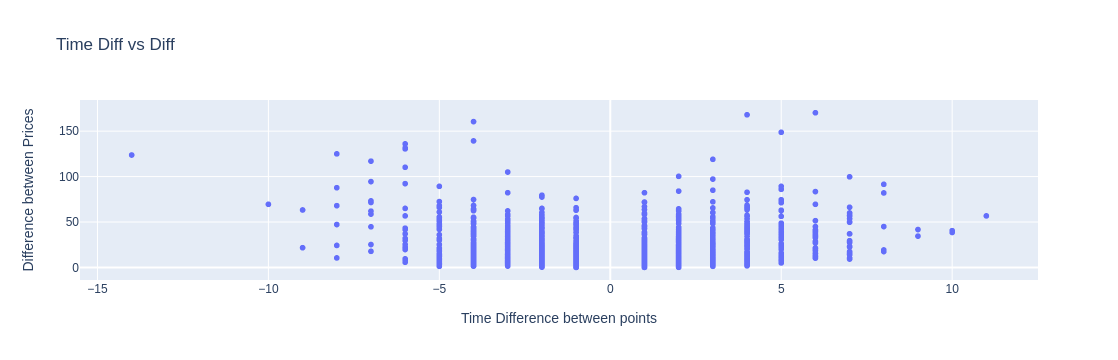

In [71]:
fig = px.scatter(data_frame=maxwidmin,x='TimeDifference',y='Difference', title='Time Diff vs Diff')
fig.update_xaxes(title_text='Time Difference between points')
fig.update_yaxes(title_text='Difference between Prices')
fig.show()

In [51]:
start_date ='2022-01-25 00:00:00'
end_date = '2022-01-26 00:00:00'
spdf = spdf_all[start_date:end_date]
spdf = process_df(spdf)
spdf['atr'] = ta.atr(high=spdf['High'],low=spdf['Low'],close=spdf['Close'],length=2)
spdf

-8.25


/tmp/ipykernel_3818/967349766.py:42: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,Open,High,Low,Close,Volume,atr_val,Price Difference,adx,atr
Datetime,,,,,,,,,
2022-01-25 00:00:00,4344.50,4367.25,4344.50,4359.50,20797,0.300000,0.30,0.300000,NaN
2022-01-25 01:00:00,4359.00,4366.50,4351.75,4359.25,15532,0.300000,0.30,0.300000,NaN
2022-01-25 02:00:00,4359.25,4365.75,4328.75,4354.25,38610,0.300000,0.30,0.300000,29.583333
2022-01-25 03:00:00,4354.00,4358.00,4329.75,4342.75,64485,0.300000,0.30,0.300000,28.821429
2022-01-25 04:00:00,4342.75,4380.75,4337.00,4374.50,43331,0.300000,0.30,0.300000,36.783333
2022-01-25 05:00:00,4374.50,4383.25,4352.25,4358.00,29978,0.300000,0.30,0.300000,33.798387
2022-01-25 06:00:00,4357.50,4370.00,4342.25,4346.00,29402,0.300000,0.30,0.300000,30.726190
2022-01-25 07:00:00,4345.75,4352.00,4334.50,4340.00,29172,0.300000,0.30,0.300000,24.061024
2022-01-25 08:00:00,4340.25,4342.25,4319.00,4337.25,55073,27.388889,22.25,40.637345,23.653922


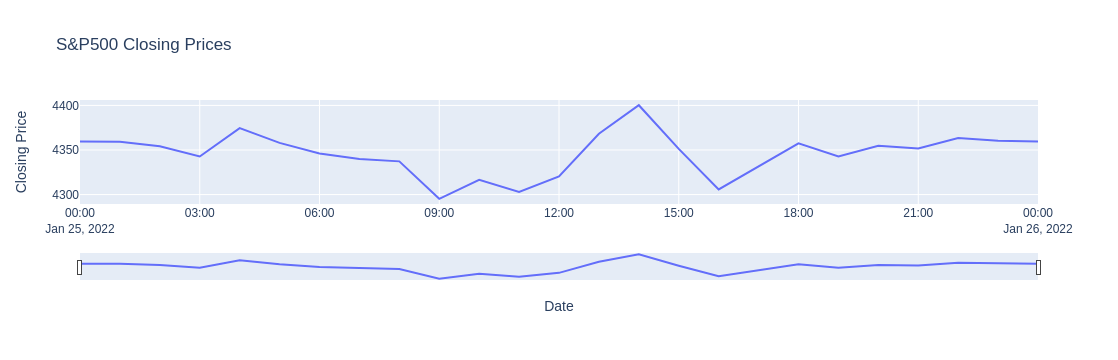

In [52]:
#plt.figure(figsize=(30,10))\n",
#fig, ax = plt.subplots(figsize=(30,10))
#plt.xticks(rotation=30)
#Co
#spdf['Close smooth'] = savgol_filter(spdf.Close, 12, 10)
#nqdf['Close smooth'] = savgol_filter(nqdf.Close, 49, 10)
#rusdf['Close smooth'] = savgol_filter(rusdf.Close, 49, 10)
#pricesp = ax.plot(spdf.index, spdf.Close, c='pink', lw=6, alpha = 0.7, zorder=4)
line_trace=go.Scatter(x=spdf.index,y=spdf.Close,mode='lines',name='Closing Prices')
fig = go.Figure(data=line_trace)
fig.update_layout(title='S&P500 Closing Prices',xaxis_title='Date',yaxis_title='Closing Price',
                  xaxis_rangeslider_visible=True)
fig.show()
#pricespsmooth = ax.plot(spdf.index, spdf['Close smooth'], c='pink', lw =2,alpha = 0.5, zorder=5)
#pricenq = ax.plot(nqdf.index, nqdf.Close, c='green', lw=2, alpha = 0.4, zorder=4)
#pricerus = ax.plot(rusdf.index, rusdf.Close, c='red', lw=2, alpha = 0.5, zorder=5)
#plt.show()

<class 'pandas.core.series.Series'>
RangeIndex: 24 entries, 0 to 23
Series name: atr
Non-Null Count  Dtype  
--------------  -----  
24 non-null     float64
dtypes: float64(1)
memory usage: 324.0 bytes
24


/tmp/ipykernel_3818/1877092290.py:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/home/armonius/anaconda3/envs/preedimarket/lib/python3.12/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



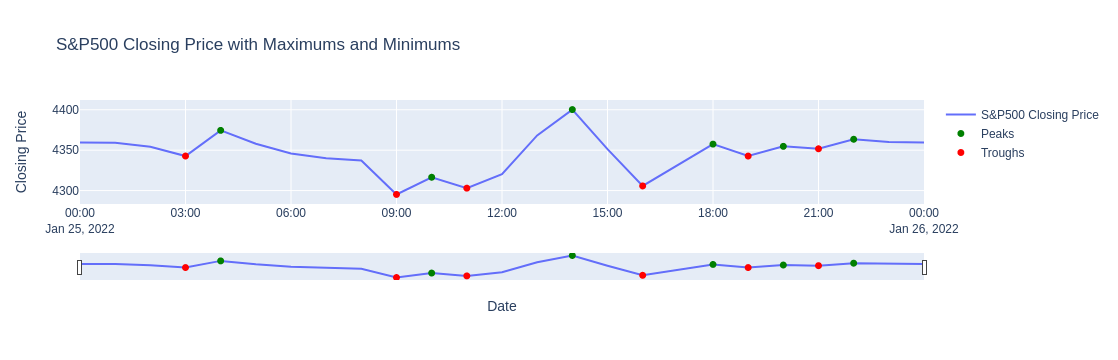

6
6


In [53]:
#fig, ax = plt.subplots(figsize=(30,10))
#plt.xticks(rotation=30)
#spdf = spdf.iloc[0:500],
#spdf['close smooth'] = savgol_filter(spdf.Close, 52, 10)
#spatr = spdf.atr.iloc[-1] #Since the first ones are NaN
spdf.reset_index(inplace=True)
spdf['atr'].fillna(value=spdf.atr.mean(), inplace=True)
spdf['atr'].info()
atr_array = spdf['atr'].to_numpy()
close_check = spdf['Close'].to_numpy()
print(len(atr_array))
sppeaks_idx, _ = find_peaks(close_check, distance = 1,prominence=atr_array/80)
sptroughs_idx, _ = find_peaks(-1*close_check,distance=1,prominence=atr_array/80)
#pricesp = ax.plot(spdf.Datetime, spdf.Close, c='pink', lw=6, alpha = 0.7, zorder=4)
peaks_dates=[spdf.Datetime[idx] for idx in sppeaks_idx]
peaks_val = spdf.Close.iloc[sppeaks_idx]
troughs_dates=[spdf.Datetime[idx] for idx in sptroughs_idx]
troughs_val = spdf.Close.iloc[sptroughs_idx]
line_trace = go.Scatter(x=spdf.Datetime, y=spdf.Close, mode='lines', name = 'S&P500 Closing Price')
peak_trace=go.Scatter(x=peaks_dates,y=peaks_val,mode='markers',
                      marker=dict(color='green',size=7),name='Peaks')
trough_trace=go.Scatter(x=troughs_dates,y=troughs_val,mode='markers',
                        marker=dict(color='red',size=7),name='Troughs')
fig=go.Figure(data=[line_trace,peak_trace,trough_trace])
fig.update_layout(title='S&P500 Closing Price with Maximums and Minimums',
                 xaxis_title='Date',
                 yaxis_title='Closing Price',
                 xaxis_rangeslider_visible=True)
fig.show()
#pricespsmooth = ax.plot(spdf.index, spdf['close smooth'], c='pink', lw =2,alpha = 0.5, zorder=5)
#peaks4sp = ax.plot(spdf.Datetime[sppeaks_idx], spdf['Close'].iloc[sppeaks_idx], c='green', linestyle='None', 
#                 markersize=7.0, marker = "o",zorder =10)
#troughs4sp = ax.plot(spdf.Datetime[sptroughs_idx], spdf['Close'].iloc[sptroughs_idx], c='red', linestyle='None', 
#                     markersize=7.0, marker="o",zorder =10)
#plt.show()
print(len(sppeaks_idx))
print(len(sptroughs_idx))
if len(sppeaks_idx) > len(sptroughs_idx):
    sppeaks_idx = sppeaks_idx[:len(sptroughs_idx)]
elif len(sptroughs_idx) > len(sppeaks_idx):
    sptroughs_idx = sptroughs_idx[:len(sppeaks_idx)]
    print(len(sppeaks_idx))
    print(len(sptroughs_idx))

#price_diff = []
#spdf.reset_index(inplace=True)
spdf.set_index(keys='Datetime',  inplace=True)
#print(spdf.Close.iloc[sptroughs_idx[0]]) # Here is where I test indexing through the S&P500 data with the
#                                           indexes collected from the find peaks functions on the peaks and troughs 
#                                           using the method above to gauge the trend
#print(spdf.Close.iloc[23])"

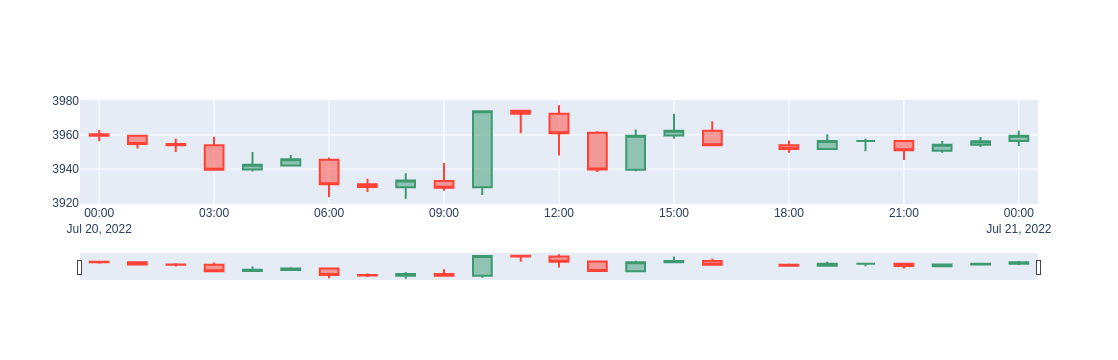

In [40]:
#spdf_all.index = spdf_all.index.tz_localize(None)
start_date='2022-01-25 00:00:00'
end_date='2022-01-26 00:00:00'
#spdfslice[start_date:end_date]
spdfslice = spdf
dailyplot = go.Figure(data =[go.Candlestick(x=spdfslice.index,
                                            open=spdfslice['Open'],
                                            high=spdfslice['High'],
                                            close=spdfslice['Close'],
                                            low=spdfslice['Low'])])
dailyplot.show()

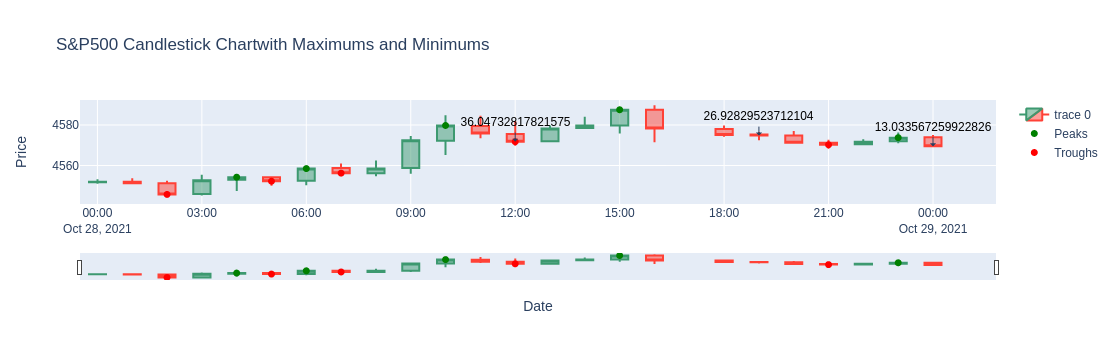

[36.04732817821575, 26.92829523712104, 13.033567259922826]
[12, 18, 23]


In [18]:
spdf.reset_index(inplace=True)
index4use=[idx for idx,val in spdf.iterrows() if val['adx'] != 0.5]
spdf.set_index(keys='Datetime', inplace=True)
#sixmulcloseval = [0,6,12,18,-1]
close_val = [spdf.Close.iloc[idx] for idx in index4use]
peaks_dates=[spdf.index[idx] for idx in sppeaks_idx]
peaks_val = spdf.Close.iloc[sppeaks_idx]
troughs_dates=[spdf.index[idx] for idx in sptroughs_idx]
troughs_val = spdf.Close.iloc[sptroughs_idx]
trend_strength_val = [spdf.adx.iloc[idx] for idx in index4use]
trend_strength_dates = [spdf.index[idx] for idx in index4use]
peak_trace=go.Scatter(x=peaks_dates,y=peaks_val,mode='markers',
                      marker=dict(color='green',size=7),name='Peaks')
trough_trace=go.Scatter(x=troughs_dates,y=troughs_val,mode='markers',
                        marker=dict(color='red',size=7),name='Troughs')
dailyplot = go.Candlestick(x=spdf.index,
                            open=spdf['Open'],
                            high=spdf['High'],
                            close=spdf['Close'],
                            low=spdf['Low'])
annotations = []
for date, val, close1 in zip(trend_strength_dates, trend_strength_val,close_val):
    annotations.append(go.layout.Annotation(x=date,y=close1,text=str(val), showarrow=True, arrowhead=1, ax=0,ay=-20,
                                           font=dict(color='black')))
fig=go.Figure(data=[dailyplot,peak_trace,trough_trace])
fig.update_layout(title='S&P500 Candlestick Chartwith Maximums and Minimums',
                 xaxis_title='Date',
                 yaxis_title='Price',
                 xaxis_rangeslider_visible=True,
                 annotations=annotations)
fig.show()
print(trend_strength_val)
print(index4use)

In [77]:
#snp_peaks = []
#snp_troughs = []
#for peak,trough in zip(sppeaks_idx, sptroughs_idx):
#        snp_peaks.append(spdf.Close.iloc[peak])
#        snp_troughs.append(spdf.Close.iloc[trough])
snp_peaks = [spdf.Close.iloc[idx] for idx in sppeaks_idx]
snp_troughs = [spdf.Close.iloc[idx] for idx in sptroughs_idx]
print(snp_peaks)
print(snp_troughs)
print(sppeaks_idx)
print(sptroughs_idx)
print(len(sppeaks_idx))
print(len(sptroughs_idx))
print(len(spdf))
#sppeaks_idx
#spdf.set_index(keys='Datetime', inplace=True)
#spdf.reset_index(inplace=True,drop=True)
spdf.info()
print(spdf.index[6])
#spdf['Datetime'].iloc[730] > spdf['Datetime'].iloc[582] 3100, 3171 is index 200 for sppeaks_idx\n",
time_diff = spdf.index[1] - spdf.index[2]
#print(time_diff.total_seconds())
print(f"{spdf.index[1]} and {spdf.index[2]}")
start_date <= spdf_all.index[-1].date()

[4542.75, 4541.25, 4543.75, 4565.5, 4570.5, 4571.75]
[4540.5, 4540.25, 4541.25, 4562.25, 4570.0, 4569.25]
[ 1  4  7 16 19 21]
[ 3  5  9 17 20 22]
6
6
24
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2021-10-25 00:00:00 to 2021-10-26 00:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           24 non-null     float64
 1   High           24 non-null     float64
 2   Low            24 non-null     float64
 3   Close          24 non-null     float64
 4   Volume         24 non-null     int64  
 5   adx            24 non-null     float64
 6   Diff_from_ADX  24 non-null     float64
 7   atr            22 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 1.7 KB
2021-10-25 06:00:00
2021-10-25 01:00:00 and 2021-10-25 02:00:00


True

In [24]:
start_date = spdf_all.index[0].date()
end_date = start_date + timedelta(days=1)
spdf= spdf_all.loc[start_date:end_date]
#spdf.head()
spdf.iloc[[2,5]]

,Open,High,Low,Close,Volume,PercentChange,TrendStrength
Datetime,,,,,,,
2021-10-24 20:00:00,4525.75,4534.50,4525.50,4533.00,8731,0.5,0.5
2021-10-24 23:00:00,4532.75,4540.25,4532.25,4538.75,7555,0.5,0.5


In [25]:
timechec = spdf.index[2] - spdf.index[5]
timechec = timechec.total_seconds()/3600
timechec

-3.0

In [35]:
maxwidmin.describe()

,Datetime4trough,Datetime4peak,TimeDifference,Maxindex,Minindex,Maxpricepoint,Minpricepoint,Difference,TrendStrength
count,3037,3037,3037.000000,3037.000000,3037.00000,3037.000000,3037.000000,3037.000000,3037.000000
mean,2023-01-01 21:25:06.618373632,2023-01-01 21:24:28.686203392,-0.010537,10.267369,10.27165,4309.290994,4295.485183,13.805812,0.010484
min,2021-10-24 19:00:00,2021-10-24 20:00:00,-14.000000,1.000000,1.00000,3598.250000,3520.500000,0.250000,-4.000000
25%,2022-05-27 07:00:00,2022-05-27 09:00:00,-2.000000,5.000000,5.00000,4017.500000,4004.000000,3.250000,-0.010000
50%,2022-12-27 21:00:00,2022-12-27 20:00:00,-1.000000,10.000000,10.00000,4294.000000,4281.250000,7.500000,0.010000
75%,2023-08-10 13:00:00,2023-08-10 09:00:00,2.000000,15.000000,15.00000,4558.250000,4549.750000,17.250000,0.010000
max,2024-03-18 12:00:00,2024-03-18 10:00:00,11.000000,23.000000,22.00000,5250.000000,5242.500000,170.250000,4.000000
std,NaN,NaN,2.415479,6.112712,6.09258,351.460780,353.778689,17.424620,0.693676


In [39]:
start_date = spdf_all.index[6].date()
end_date = start_date + timedelta(days=1)
spdf= spdf_all[start_date:end_date]
spdf = process_df(spdf)
spdf

/tmp/ipykernel_10801/1087950953.py:8: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_10801/1087950953.py:18: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typi

,Open,High,Low,Close,Volume,PercentChange,TrendStrength
Datetime,,,,,,,
2021-10-25 00:00:00,4538.75,4540.25,4537.25,4540.00,3337,0.500000,12.0
2021-10-25 01:00:00,4540.00,4543.00,4538.25,4542.75,4979,0.500000,0.5
2021-10-25 02:00:00,4542.75,4543.50,4539.25,4542.75,4994,0.500000,0.5
2021-10-25 03:00:00,4543.00,4543.25,4537.75,4540.50,9302,0.500000,0.5
2021-10-25 04:00:00,4540.50,4546.50,4540.00,4541.25,7249,0.500000,0.5
2021-10-25 05:00:00,4541.50,4542.75,4539.00,4540.25,4723,0.500000,0.5
2021-10-25 06:00:00,4540.25,4543.25,4539.50,4542.00,4362,0.044053,1.0
2021-10-25 07:00:00,4541.75,4543.75,4538.50,4543.75,7624,0.500000,0.5
2021-10-25 08:00:00,4543.75,4545.00,4541.75,4542.75,9509,0.500000,0.5


In [32]:
idx2use=[]
idx2_6 = [idx for idx in range(len(spdf)) if idx % 6 ==0]
rel_trend_strength = [spdf['TrendStrength'].iloc[idx] for idx in range(len(spdf)) if idx % 6 ==0]
trend_pair = dict(zip(idx2use,rel_trend_strength))
print(trend_pair)
print(rel_trend_strength)
print(idx2_6)
spdf

{}
[2.0, 0.01, 1.0, -0.01]
[0, 6, 12, 18]


,Open,High,Low,Close,Volume,PercentChange,TrendStrength,atr
Datetime,,,,,,,,
2021-10-20 00:00:00,4511.50,4511.50,4508.75,4509.00,0,1.000000,2.00,6.997944
2021-10-20 01:00:00,4509.25,4510.00,4505.75,4508.00,5543,0.500000,0.50,6.997944
2021-10-20 02:00:00,4507.75,4508.00,4504.25,4505.50,7042,0.500000,0.50,3.916667
2021-10-20 03:00:00,4505.50,4515.75,4504.25,4508.00,16826,0.500000,0.50,8.250000
2021-10-20 04:00:00,4508.25,4512.25,4507.50,4511.25,6992,0.500000,0.50,6.383333
2021-10-20 05:00:00,4511.00,4513.50,4508.75,4511.50,5287,0.500000,0.50,5.540323
2021-10-20 06:00:00,4511.75,4512.75,4509.50,4511.50,6345,0.055445,0.01,4.376984
2021-10-20 07:00:00,4511.50,4512.75,4506.75,4507.25,7823,0.500000,0.50,5.194882
2021-10-20 08:00:00,4507.25,4512.50,4507.25,4511.00,11011,0.500000,0.50,5.222549


In [ ]:
#for idx in maxwidmin:
#    if maxwidmin['Maxpricepoint'] > maxwidmin['Maxpricepoint'].shift(1) \
#      and maxwidmin['Minpricepoint'] < maxwidmin['Minpricepoint']:
#            maxwidmin['Trend?'] = 'Uptrend'

In [67]:
#Take the rolling ATR (Average True Range so the y axis doesn't roll too much
#spdf['atr'] = ta.atr(high = spdf.High, low = spdf.Low, close = spdf.Close,length=2)
#nqdf_all['atr'] = ta.atr(high = nqdf_all.High, low = nqdf_all.Low, close = nqdf_all.Close)
#rusdf_all['atr'] = ta.atr(high = rusdf_all.High, low = rusdf_all.Low, close = rusdf_all.Close)
#spdf['dailyatr'] = ta.atr(high = spdf.High, low = spdf.Low, close = spdf.Close, length =24)
#fractionoftime= timedelta(hours=6)
#Rolling atr now
#spdf['atrroll'] = spdf.atr.rolling(window=4).mean()
#spdf_all.index = spdf_all.index.tz_localize(None)
#nqdf_all['atr'] = nqdf_all.atr.rolling(window=30).mean()
#rusdf_all['atr'] = rusdf_all.atr.rolling(window=30).mean()
#spdf['dailyatr'] = spdf.dailyatr.rolling(window=168).mean()
#start_date = spdf_all.index[0].date()
#end_date = start_date + timedelta(days=1)
#spdf = spdf_all.loc[start_date:end_date]
#spdf= spdf_all.loc[start_date:end_date]
#atr_val = ta.atr(high = spdf.High, low = spdf.Low, close = spdf.Close,length=2)
#spdf.loc[:, 'atr' ] = atr_val
#spdf.iloc[[0,-1]]
#spdf.reset_index(inplace=True)
#spdf.iloc[[5,34,64,79,94,276,280,325,353,508,392,673,582,730,663,762,785,820,823,887,857,925]]
#start_date_obj = spdf_all.index[0].date()
#start_date_obj"
#spdf.head()

,Open,High,Low,Close,Volume,atr
Datetime,,,,,,
2021-10-25,4538.75,4540.25,4537.25,4540.0,0,NaN
2021-10-26,4569.25,4571.25,4569.25,4570.0,2578,3.338867


In [ ]:

#spdf_all['Datetime'] = spdf_all['Datetime'].tz_localize(None)
#spdf_all.set_index(keys=spdf_all['Datetime'],inplace=True)
spdf_all.info()               

In [ ]:
# start_date= spdf_all.index[0].date()
# end_date = start_date + timedelta(days=1)
# spdf = spdf_all[start_date:end_date]
# def process_df(spdf_all, spdf_slice):
# #   Calculate the percentage change    
#     spdf_slice['PercentChange'] = spdf_slice['Close'].pct_change(periods=6)*100
#     spdf_all['PercentChange'] = spdf_all['Close'].pct_change(periods=6)*100
#     spdf_slice.reset_index(inplace=True)
# #   Build a value to help gauge the strength of the trend and put value in 'TrendStrength column'    
#     threshold = (spdf_all['PercentChange'].max() - spdf_all['PercentChange'].min()) / 10
# #   Fill NaN values in Percent Change    
#     spdf_all['PercentChange'].fillna(value=0.5,inplace=True)
#     spdf_slice['PercentChange'].fillna(value=0.5,inplace=True)
# #   Calculate the Trend Strength
#     spdf_slice['TrendStrength'] = (spdf_slice['PercentChange'] / threshold).round().astype(float)
# #   Store last values
#     lastvaltrenstren= spdf_slice['TrendStrength'].iloc[-1]
#     lastvalPerchange=spdf_slice['PercentChange'].iloc[-1]
# #   Fill values that aren't relevant 
#     spdf_slice.loc[spdf_slice.index % 6 !=0, 'PercentChange'] = 0.5
#     spdf_slice.loc[spdf_slice.index % 6 !=0, 'TrendStrength'] = 0.5
# #   Replace last values
#     spdf_slice['PercentChange'].iloc[-1]=lastvalPerchange
#     spdf_slice['TrendStrength'].iloc[-1]=lastvaltrenstren
#     spdf_slice.set_index(keys='Datetime',inplace=True)
# #   Since 0 ==-0 and I need the distinction, this here creates thedistinction
#     spdf_slice['TrendStrength'] = spdf_slice['TrendStrength'].astype(str) 
#     def replace_zero(value):
#         if value == '0.0':
#             return '0.01'
#         elif value == '-0.0':
#             return '-0.01'
#         else:
#             return value
#     spdf_slice['TrendStrength'] = spdf_slice['TrendStrength'].apply(replace_zero)
#     spdf_slice['TrendStrength'] = spdf_slice['TrendStrength'].astype(float)
#     return spdf_slice

# spdf_mod = process_df(spdf_all, spdf_all)
# spdf_mod['TrendStrength'].value_counts()
# #spdf_mod.info()